In [94]:

import re 
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, unpack_sequence, PackedSequence, pad_sequence
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import importlib
import gru_functions 

In [2]:
# handy parameters
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)


batch_size = 2
hidden_size = 3

## Simulate data

Idea: As we want to catch generalizations in the data with the core of our architecture and neuron-specific characteristics with the readout, we want to generate data mirroring this assumption about our data.

In [ ]:
n_neurons = 1
n_time_bins = int(1000/10) # 10ms time bins over 1s in total

possible_neuron_specifics = torch.arange(-1, 2)
#neuron_specifics = possible_neuron_specifics[torch.randint(0, len(possible_neuron_specifics), (n_neurons,))]
neuron_specifics = torch.arange(-1, 2)
neuron_specifics = neuron_specifics.unsqueeze(1)

print(neuron_specifics.shape)
neuron_specifics

In [ ]:
raw_spikes = torch.arange(1, 5).float()
raw_spikes = raw_spikes.repeat((n_neurons, int(n_time_bins//len(raw_spikes))+1))
raw_spikes = raw_spikes[:,0:n_time_bins]

print(raw_spikes.shape)
raw_spikes

In [ ]:
#spikes = neuron_specifics+raw_spikes
spikes = raw_spikes

print(spikes.shape)
#spikes[:,99:100] = 0
spikes 
#spikes[:, -20:] = 0


In [ ]:
X = spikes[0:2, 1:]

print(X.shape)
X

In [ ]:
Y = spikes[0:2, :-1]

print(Y.shape)
Y

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [9]:
spikes_dataset = CustomDataset(X, Y)


train_dataloader = DataLoader(spikes_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(spikes_dataset, batch_size=batch_size, shuffle=True)

## Model architecture

In [5]:
def elu1(x):
    return F.elu(x, inplace=True) + 1.

class Elu1(nn.Module):
    """
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:

    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x):
        return elu1(x)

In [6]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
       # x = torch.sigmoid(x)
       # return self.nonlinearity(x)
        return x

In [7]:
class GRUCore(nn.Module):
    def __init__(self, hidden_size, bias=True):
        super().__init__()
        self.gru = nn.GRUCell(1, hidden_size, bias=bias)
        self.hidden_size = hidden_size
        self.hidden_states = None  # To store hidden states
        
    def init_state(self, batch_size):
        return nn.Parameter(torch.zeros([batch_size, self.gru.hidden_size]))
        
    def forward(self, x, hidden_state=None, reverse=True):
        if len(x.shape) != 2:
            raise RuntimeError(f"Expected 2D input to GRUCore, but got input of size: {x.shape}")
            
        hidden_states = []
        hidden_state = self.init_state(x.shape[0]) if hidden_state is None else hidden_state
        
        rng = range(x.shape[1])
        rng = reversed(rng) if reverse else rng
        
        for t in rng:
            input_ = x[:,t:t+1]
            hidden_state = self.gru(input_, hidden_state)
            hidden_states.append(hidden_state)
            
        self.hidden_states = torch.stack(hidden_states, 1)  # Store hidden states
        return self.hidden_states
    
        

In [8]:
class LinearReadout(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = self.linear(x)
        return x.squeeze(dim=2)

## Training functions

In [9]:
def get_device(cpu_preference=False, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() and not cpu_preference else "cpu")
    if verbose: print("Using device:", device)
    return device

In [10]:
def accuracy(correct, total):
    return float(correct)/total

In [11]:
def train(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
       # x = x.squeeze(0)
        y = y.squeeze(-1)
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        #y = y.view(y.size(0), -1)
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        #y_pred = torch.round(y_pred)
        epoch_correct += sum((y == y_pred).flatten())
        epoch_total += len(y)
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), y_pred

In [12]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
           # x = x.squeeze(0)
            y = y.squeeze(-1)
            #print(x.shape)
            #print(y.shape)
            
            y_pred = model(x)
           # y = y.view(y.size(0), -1)
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())

            #y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += len(y)
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), y_pred

In [13]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, epoch_val_acc, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_acc)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}, val loss: {epoch_val_loss}, val acc: {epoch_val_acc}")
            
    return train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val

In [14]:
def plot(title, label, train_results, val_results):
    epoch_array = np.arange(len(train_results)) + 1
    train_label = "Training "+label.lower()
    val_label = "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    plt.show()

# test bin

In [33]:
data = "data_model_v1.csv"
df = pd.read_csv(data)

In [25]:
# Group rows into bins of 10 and calculate the mean for each bin
bin_var = df['aDistReach_3']
df_binned = bin_var.groupby(bin_var.index // 10).mean()

# Reset the index (optional)
df_binned = df_binned.reset_index(drop=True)

In [37]:
os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/models')

In [51]:
import torch
import torch.nn as nn

class GRUCore(nn.Module):
    def __init__(self, hidden_size, input_size=1, bias=True):
        super().__init__()
        # Initialize the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, bias=bias, batch_first=True)  # Set batch_first=True
        self.hidden_size = hidden_size
        self.hidden_states = None

    def init_state(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size)  # Shape for GRU [num_layers, batch_size, hidden_size]

    def forward(self, x, hidden_state=None, reverse=True):
        """
        x is expected to have shape [batch_size, sequence_length, input_size]
        """
        # Check if the input is 3D, which is typical for sequence modeling (batch, sequence_length, input_size)
        if len(x.shape) != 3:
            raise RuntimeError(f"Expected 3D input to GRUCore, but got input of size: {x.shape}")

        batch_size, seq_length, _ = x.shape  # Extract dimensions
        
        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self.init_state(batch_size)  # Shape: [1, batch_size, hidden_size]

        # Pass through GRU layer; returns output and final hidden state
        output, hidden_state = self.gru(x, hidden_state)  # output shape: [batch_size, seq_length, hidden_size]

        return output  # Return both output and final hidden state
    
class LinearReadout(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        #return x.squeeze(dim=2)
        return x
    
    
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Output layer to transform the hidden state to output size
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, hidden_size)
        gru_out, hidden = self.gru(x, hidden)  # Forward pass through GRU
        
        # Apply the linear layer to each time step's output
        output = self.linear(gru_out)  # Output shape will be (batch_size, seq_len, output_size)
        return output # Return output and hidden state
    
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        return x


In [116]:
os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/models')
lag_values = np.arange(1,16)
trial_values = [6,7,8]
hidden_size = 16
data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"
lag_word = "_lagged"
batch_size = 13
for s in lag_values:
    for i in trial_values: 
        shift = s 
        set_value = i 
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        core = GRUCore(hidden_size,input_size)
        readout = LinearReadout(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]

        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        
        model.load_state_dict(torch.load(f'model_monkey_h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
        
        yPred_val_m = yPred_val_m.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_m = r2_score(all_y_true, yPred_val_m)
        
         
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3','oDistReach3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        core = GRUCore(hidden_size,input_size)
        readout = LinearReadout(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]



        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        model.load_state_dict(torch.load(f'model_human_h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        epoch_val_loss_h, yPred_val_h = validate(val_dataloader, model, loss_fn, device=None)
        yPred_val_h = yPred_val_h.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_h = r2_score(all_y_true, yPred_val_h)
        print(f'solo_{shift}_{set_value}_{r2_m}')
        print(f'dyadic_{shift}_{set_value}_{r2_h}')
        

solo_1_6_0.991368413321908
dyadic_1_6_0.9900347340879627
solo_1_7_0.9682178603107143
dyadic_1_7_0.9609649786208209
solo_1_8_0.9923522450578759
dyadic_1_8_0.9854894648769665
solo_2_6_0.9836110912194977
dyadic_2_6_0.972966142439356
solo_2_7_0.9570093898529781
dyadic_2_7_0.8974838860935859
solo_2_8_0.9913591986292442
dyadic_2_8_0.9861754975796102
solo_3_6_0.9832162851838558
dyadic_3_6_0.9620784508546291
solo_3_7_0.9179842014460745
dyadic_3_7_0.9129698963918579
solo_3_8_0.9907571769973453
dyadic_3_8_0.990202556718616
solo_4_6_0.9702665756437625
dyadic_4_6_0.9240892376108167
solo_4_7_0.7551352687752172
dyadic_4_7_0.8574954382895841
solo_4_8_0.9869394835917069
dyadic_4_8_0.9878861742664878
solo_5_6_0.953341590482283
dyadic_5_6_0.968729396121748
solo_5_7_0.8669991563004069
dyadic_5_7_0.8702574890793344
solo_5_8_0.9873208507418703
dyadic_5_8_0.9863597771319843
solo_6_6_0.9429402346649723
dyadic_6_6_0.943623788199994
solo_6_7_0.8734775626712517
dyadic_6_7_0.7180054577429658
solo_6_8_0.959465425

# packed seq - load models

In [131]:
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
      #  cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        
        return rates
    

In [132]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        return x

In [123]:
class M2S_Loss2(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='sum')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            # Pad sequences to ensure they have the same length
            padded_y_pred = pad_sequence([seq for seq in y_pred], batch_first=True)
            padded_y = pad_sequence([seq for seq in y], batch_first=True)
            
            # Move to the same device
            device = padded_y_pred.device
            padded_y = padded_y.to(device)
            
            # Create a mask to ignore padding tokens
            mask = (padded_y != 0).float()
            
            # Compute the loss (MSE in this case) between the padded sequences
            loss = self.criterion(padded_y_pred * mask, padded_y * mask)
            return loss
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [125]:
class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=1):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor

In [126]:
class ExperimentEncoder(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, device=None):
        super().__init__()
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        
        return factors

In [138]:
os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq/models')
lag_values = np.arange(1,16)
trial_values = np.arange(2,16)
hidden_size = 16
data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"
lag_word = "_lagged"
batch_size = 13
for s in lag_values:
    for i in trial_values: 
        shift = s 
        set_value = i 
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        hidden_size = 16
        core = ExperimentEncoder(input_size,hidden_size)
        readout = NonlinearDecoder(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]

        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_packed_sequences)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)

        
        model.load_state_dict(torch.load(f'solo_model__h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
        
        yPred_val_m = yPred_val_m.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_m = r2_score(all_y_true, yPred_val_m)
        
         
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3','oDistReach3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        core = GRUCore(hidden_size,input_size)
        readout = LinearReadout(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]



        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        model.load_state_dict(torch.load(f'dyadic_model__h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        
        epoch_val_loss_h, yPred_val_h = validate(val_dataloader, model, loss_fn, device=None)
        yPred_val_h = yPred_val_h.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_h = r2_score(all_y_true, yPred_val_h)
        print(f'solo_{shift}_{set_value}_{r2_m}')
        print(f'dyadic_{shift}_{set_value}_{r2_h}')
        

AttributeError: 'list' object has no attribute 'size'

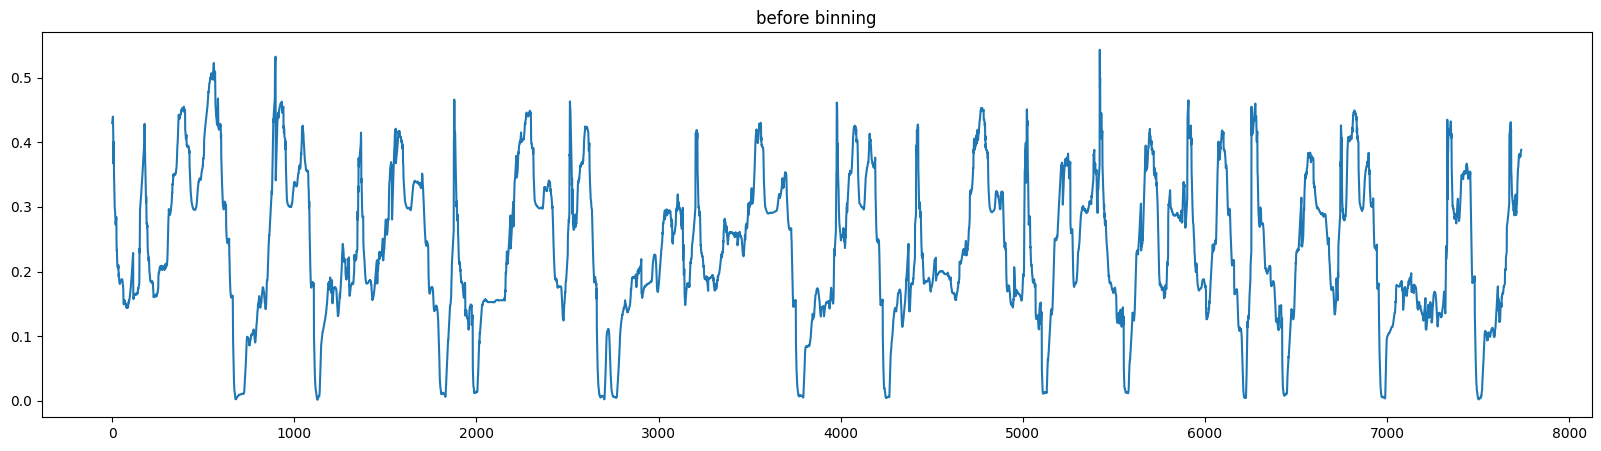

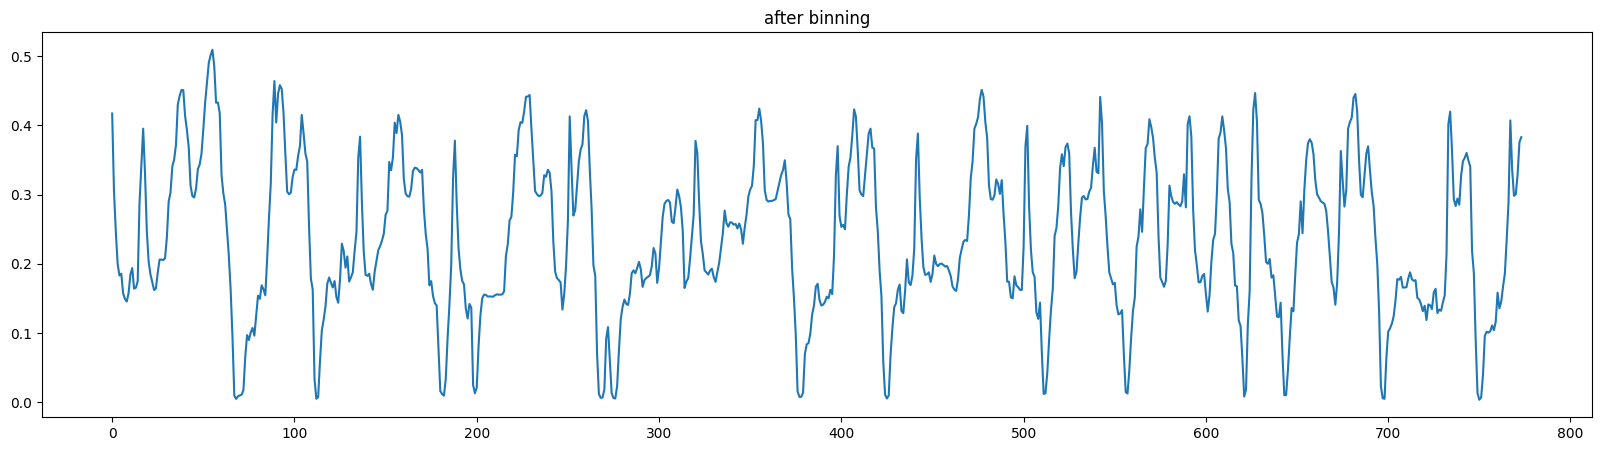

In [32]:
plt.figure(figsize=(20,5))
plt.title('before binning')
plt.plot(df['aDistReach_3'])
plt.show()

plt.figure(figsize=(20,5))
plt.title('after binning')
plt.plot(df_binned)
plt.show()


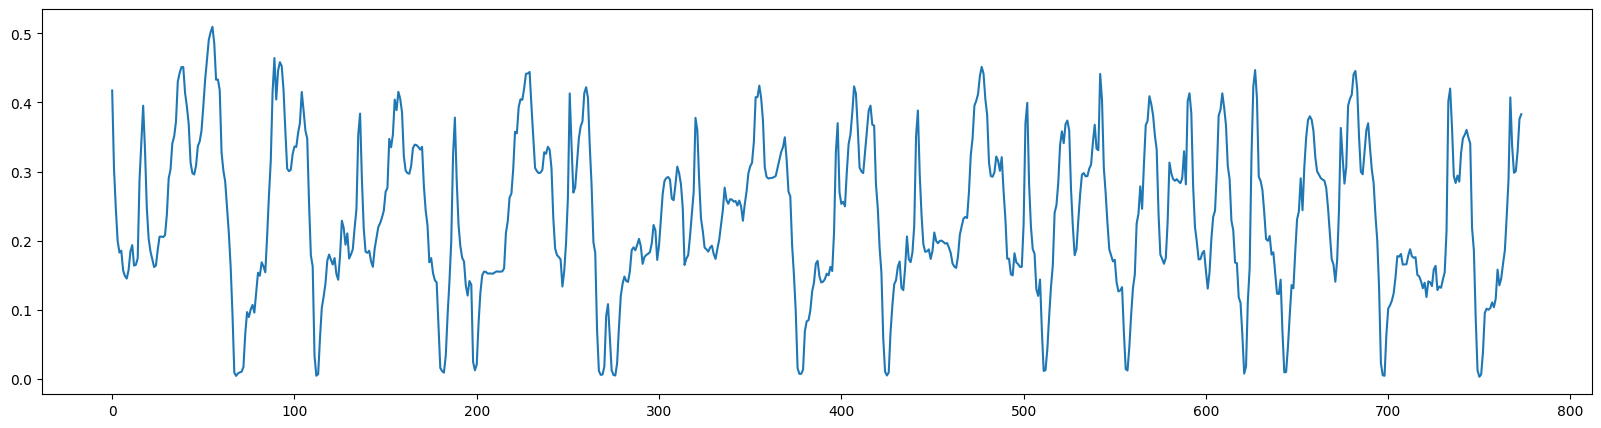

In [29]:
plt.figure(figsize=(20,5))
plt.plot(df_binned)

In [ ]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']

for j in np.arange(2, 16):
    df_tr = df[df['trial'] == j]
    
    # Shift columns in HG by -50
    HG_shifted = df_tr[HG].shift(-70)
    
    # Drop NaNs after shifting
    df_tr_shifted = df_tr.copy()
    df_tr_shifted[HG] = HG_shifted
    df_tr_shifted = df_tr_shifted.dropna()  # Drop rows with NaN values

    # Convert to NumPy arrays
    HG_np = df_tr_shifted[HG].to_numpy()
    HG_np_scaled = np.array([min_max_scaling(HG_np[:, k]) for k in range(HG_np.shape[1])]).T
    Dist_np = df_tr_shifted[Dist].to_numpy()

    fig, axs = plt.subplots(4, 1, figsize=(20, 10), linewidth=0.01)  
    for i in np.arange(4):
        ax = axs[i]
        ax.plot(HG_np_scaled[:, i], label='Head gaze', linewidth=1.5, color='blue')  # True values in blue
        ax.plot(Dist_np[:, i], label='Dist', linewidth=1.5, color='orange')  # Predicted values in orange
        ax.set_ylabel(f'feeder {i+1}')

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'[A]Head gaze vs [A]Distance to feeders - trial {j}')
            ax.legend()
        
    plt.savefig(f'HGvsDist_trial_{j}.png')
    plt.show()


## Set up

In [11]:
class TrialDataset(Dataset):
    def __init__(self, df, X, y):
        self.df = df
        self.X = X
        self.y = y
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Get the features for the trial
        features = trial_data[self.X].values  # Shape: [sequence_length, num_features]
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Get the labels for the trial (assuming the same label for the entire trial)
        labels = trial_data[self.y].values  # Change this if you need a different structure for labels
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        features_tensor = features_tensor.squeeze(0).squeeze(0)
        labels_tensor = labels_tensor.squeeze(0).squeeze(0)
        
        return features_tensor, labels_tensor

In [12]:

import torch
import torch.nn as nn

class GRUCore(nn.Module):
    def __init__(self, hidden_size, input_size=1, bias=True):
        super().__init__()
        self.gru = nn.GRUCell(input_size, hidden_size, bias=bias)
        self.hidden_size = hidden_size
        self.hidden_states = None 
        
    def init_state(self, batch_size):
        # Initialize hidden state with zeros, requires_grad=False since it's a hidden state
        return torch.zeros(batch_size, self.hidden_size)
        
    def forward(self, x, hidden_state=None, reverse=True):
        """
        x is expected to have shape [batch_size, sequence_length, input_size]
        """
        # Check if the input is 3D, which is typical for sequence modeling (batch, sequence_length, input_size)
        if len(x.shape) != 3:
            raise RuntimeError(f"Expected 3D input to GRUCore, but got input of size: {x.shape}")
        
        batch_size, seq_length, _ = x.shape  # Extract dimensions
        

        # Initialize hidden state if not provided
        hidden_state = self.init_state(batch_size) if hidden_state is None else hidden_state
        
        # Reverse sequence if required
        rng = range(seq_length)
       # rng = reversed(rng) if reverse else rng
        
        hidden_states = []
        
        # Iterate through each time step
        for t in rng:
            input_t = x[:, t:t+1, :]
            # Slice the input for the current time step: shape [batch_size, input_size]
            hidden_state = self.gru(input_t, hidden_state)  # Pass through GRUCell: shape [batch_size, hidden_size]
            hidden_states.append(hidden_state)
        
        # Stack hidden states along the time dimension (seq_length): shape [batch_size, seq_length, hidden_size]
        hidden_states = torch.stack(hidden_states, dim=1)
        
        # If reversed, hidden states need to be flipped to match the original time order
        if reverse:
            hidden_states = torch.flip(hidden_states, dims=[1])
        
        return hidden_states


In [34]:
import torch
import torch.nn as nn

class GRUCore(nn.Module):
    def __init__(self, hidden_size, input_size=1, bias=True):
        super().__init__()
        # Initialize the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, bias=bias, batch_first=True)  # Set batch_first=True
        self.hidden_size = hidden_size
        self.hidden_states = None

    def init_state(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size)  # Shape for GRU [num_layers, batch_size, hidden_size]

    def forward(self, x, hidden_state=None, reverse=True):
        """
        x is expected to have shape [batch_size, sequence_length, input_size]
        """
        # Check if the input is 3D, which is typical for sequence modeling (batch, sequence_length, input_size)
        if len(x.shape) != 3:
            raise RuntimeError(f"Expected 3D input to GRUCore, but got input of size: {x.shape}")

        batch_size, seq_length, _ = x.shape  # Extract dimensions
        
        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self.init_state(batch_size)  # Shape: [1, batch_size, hidden_size]

        # Pass through GRU layer; returns output and final hidden state
        output, hidden_state = self.gru(x, hidden_state)  # output shape: [batch_size, seq_length, hidden_size]

        return output  # Return both output and final hidden state


In [26]:

data = 'data_model_v1.csv'
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3']
set_value = 6
shift = 30
batch_size = 13
df = pd.read_csv(data)
df = df.drop(columns='id')
df = df[df['trial'] != 1]
# Step 1: Find the minimum length of all trials
trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
min_length = trial_lengths.min()            # Find the shortest sequence length

# Step 2: Cut all trials to the length of the shortest sequence
df = df.groupby('trial').head(min_length).reset_index(drop=True)

#save_dir = '/kaggle/working/plots/4d_model'
#os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
#shifted_df = shift_dataframe(df,shift,columns_to_shift)
# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_lagged'
        trial_df[new_col_name] = trial_df[col].shift(-shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
    
selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
shifted_df = shifted_df[selected_columns]
#print(shifted_df.columns)
features = ['aDistReach_3_lagged']
train_set = shifted_df[(shifted_df['trial'] != set_value)]

train_dataset = TrialDataset(train_set, X=features, y=labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
val_set = shifted_df[(shifted_df['trial'] == set_value)]
val_dataset = TrialDataset(val_set, X=features, y=labels)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
lengths = []
for X,y in val_dataloader:
    print(X.shape)
    print(y.shape)

torch.Size([1, 305, 1])
torch.Size([1, 305, 1])


In [298]:

# Step 1: Find the minimum length of all trials
trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
min_length = trial_lengths.min()            # Find the shortest sequence length

# Step 2: Cut all trials to the length of the shortest sequence
df_cut = df.groupby('trial').head(min_length).reset_index(drop=True)


In [35]:
hidden_size = 8
batch_size = 1
core = GRUCore(hidden_size)
readout = LinearReadout(hidden_size)
model = CoreAndReadout(core, readout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
#loss_fn = nn.PoissonNLLLoss()
loss_fn = nn.MSELoss()
n_epochs = 800

In [38]:
import os
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/toy_data_2'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [32]:
train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch 0, train loss: 0.3615362048149109, train acc: 0.0, val loss: 0.25606653094291687, val acc: 0.0
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<c

KeyboardInterrupt: 

In [37]:
save_dir

NameError: name 'save_dir' is not defined

Epoch 0, train loss: 0.04292914643883705, train acc: 0.0, val loss: 0.021822206676006317, val acc: 0.0
Epoch 50, train loss: 0.013032523915171623, train acc: 0.0, val loss: 0.02440335415303707, val acc: 0.0
Epoch 100, train loss: 0.011686115525662899, train acc: 0.0, val loss: 0.021377868950366974, val acc: 0.0
Epoch 150, train loss: 0.010052564553916454, train acc: 0.0, val loss: 0.017983119934797287, val acc: 0.0


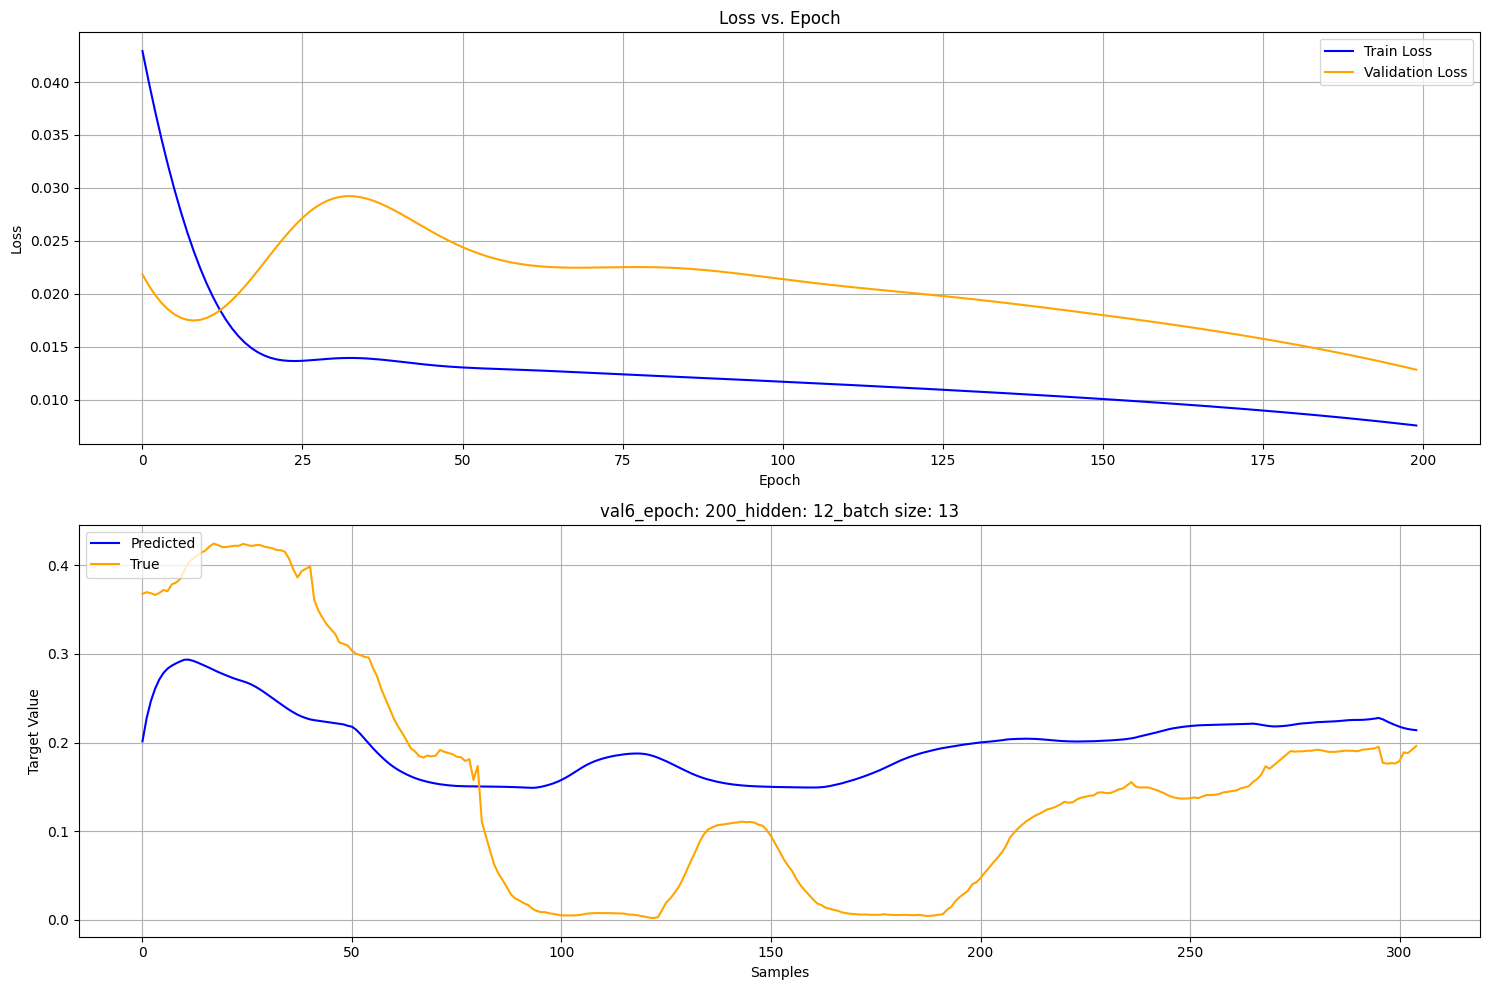

Epoch 0, train loss: 0.016886286437511444, train acc: 0.0, val loss: 0.034803442656993866, val acc: 0.0
Epoch 50, train loss: 0.011569212190806866, train acc: 0.0, val loss: 0.020782114937901497, val acc: 0.0
Epoch 100, train loss: 0.0078016468323767185, train acc: 0.0, val loss: 0.01299693901091814, val acc: 0.0
Epoch 150, train loss: 0.004012417048215866, train acc: 0.0, val loss: 0.005568973254412413, val acc: 0.0
Epoch 200, train loss: 0.0017696588765829802, train acc: 0.0, val loss: 0.003009169129654765, val acc: 0.0
Epoch 250, train loss: 0.0015953911934047937, train acc: 0.0, val loss: 0.0022988931741565466, val acc: 0.0
Epoch 300, train loss: 0.0014962416607886553, train acc: 0.0, val loss: 0.002116965129971504, val acc: 0.0
Epoch 350, train loss: 0.0014084691647440195, train acc: 0.0, val loss: 0.0019165721023455262, val acc: 0.0


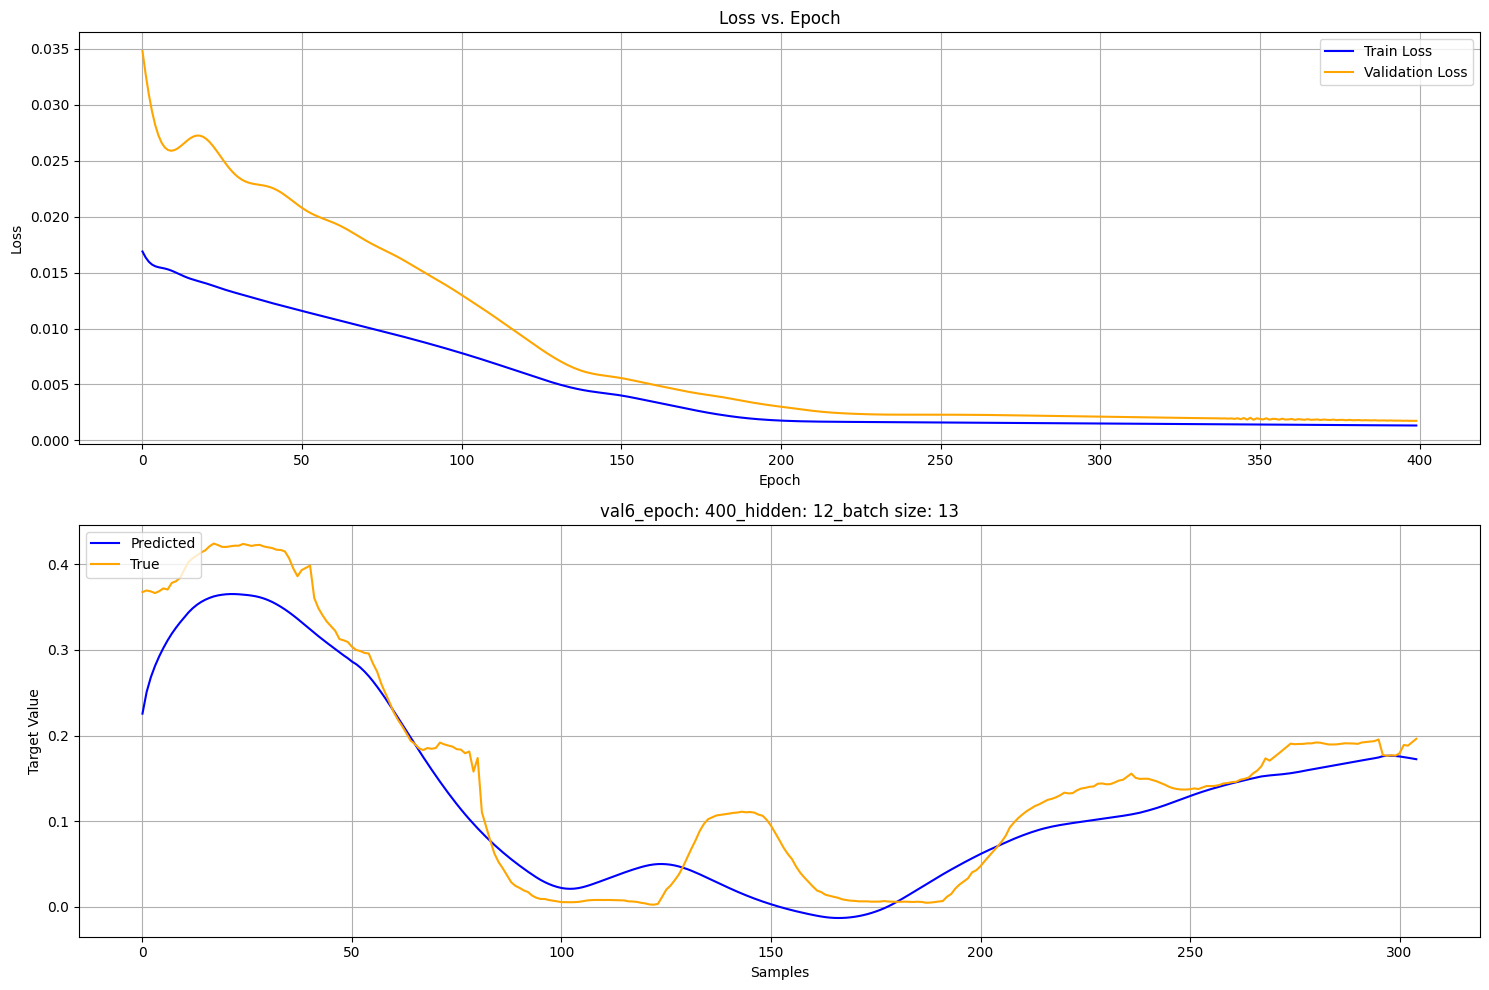

Epoch 0, train loss: 0.08600663393735886, train acc: 0.0, val loss: 0.04885241016745567, val acc: 0.0
Epoch 50, train loss: 0.010617751628160477, train acc: 0.0, val loss: 0.02105572819709778, val acc: 0.0
Epoch 100, train loss: 0.009154386818408966, train acc: 0.0, val loss: 0.0164211206138134, val acc: 0.0
Epoch 150, train loss: 0.007078761234879494, train acc: 0.0, val loss: 0.011857748031616211, val acc: 0.0


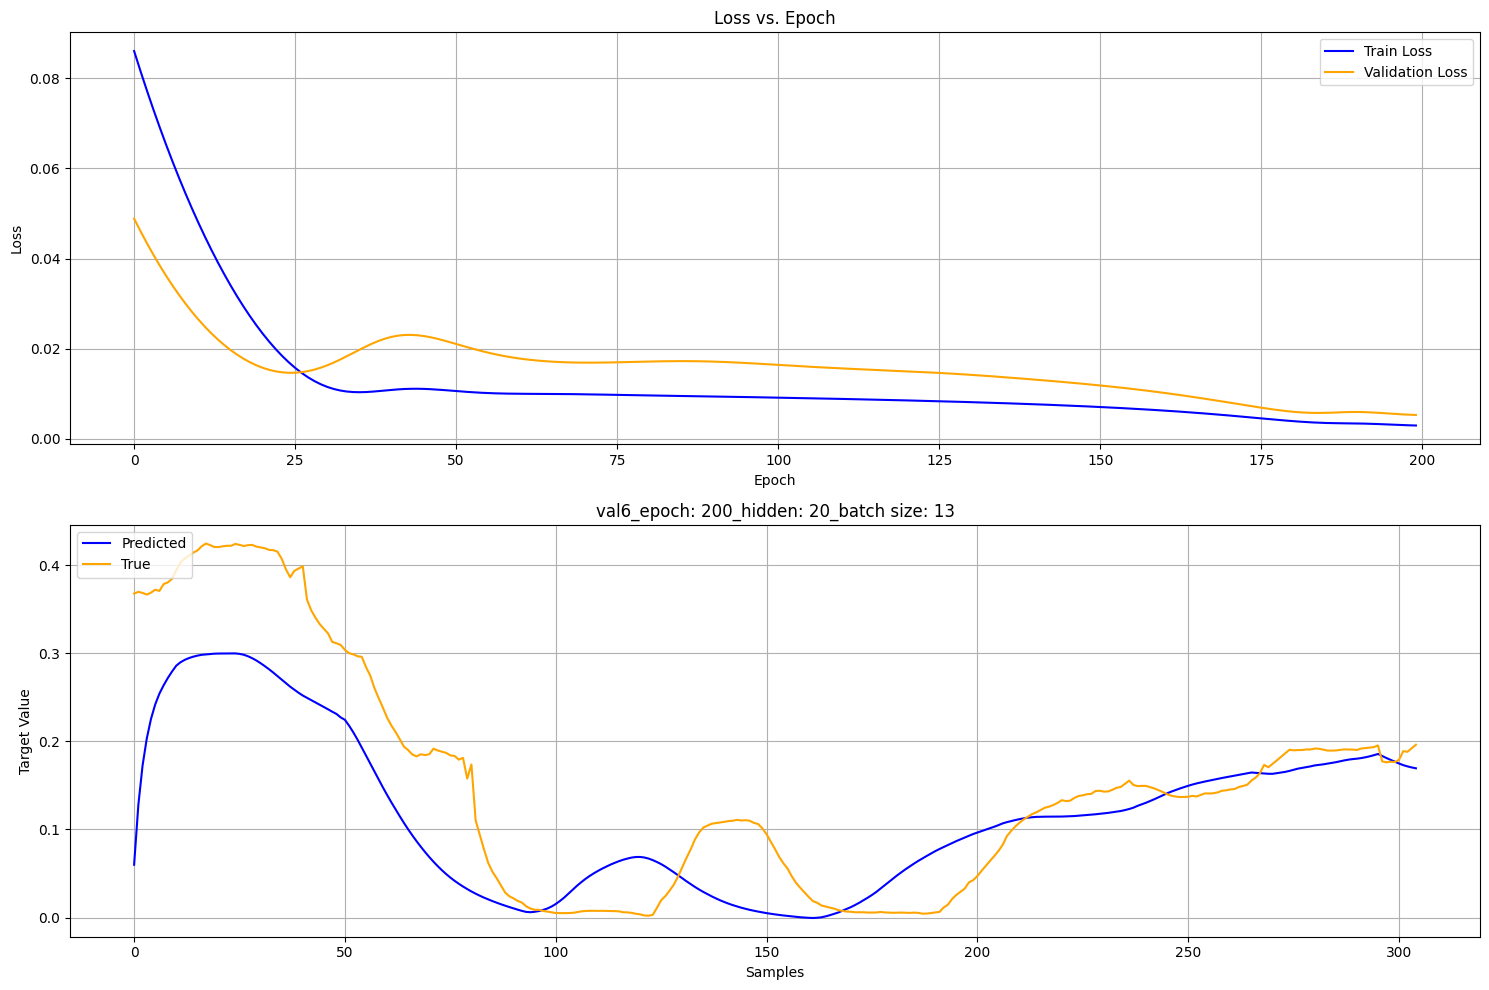

Epoch 0, train loss: 0.055995624512434006, train acc: 0.0, val loss: 0.027612026780843735, val acc: 0.0
Epoch 50, train loss: 0.013690772466361523, train acc: 0.0, val loss: 0.024023547768592834, val acc: 0.0
Epoch 100, train loss: 0.011520396918058395, train acc: 0.0, val loss: 0.02095290832221508, val acc: 0.0
Epoch 150, train loss: 0.008135017938911915, train acc: 0.0, val loss: 0.014096707105636597, val acc: 0.0
Epoch 200, train loss: 0.002247751923277974, train acc: 0.0, val loss: 0.0034116876777261496, val acc: 0.0
Epoch 250, train loss: 0.0016602060059085488, train acc: 0.0, val loss: 0.0024178503081202507, val acc: 0.0
Epoch 300, train loss: 0.0015920716105028987, train acc: 0.0, val loss: 0.0021997999865561724, val acc: 0.0
Epoch 350, train loss: 0.0015295670600607991, train acc: 0.0, val loss: 0.0020593658555299044, val acc: 0.0


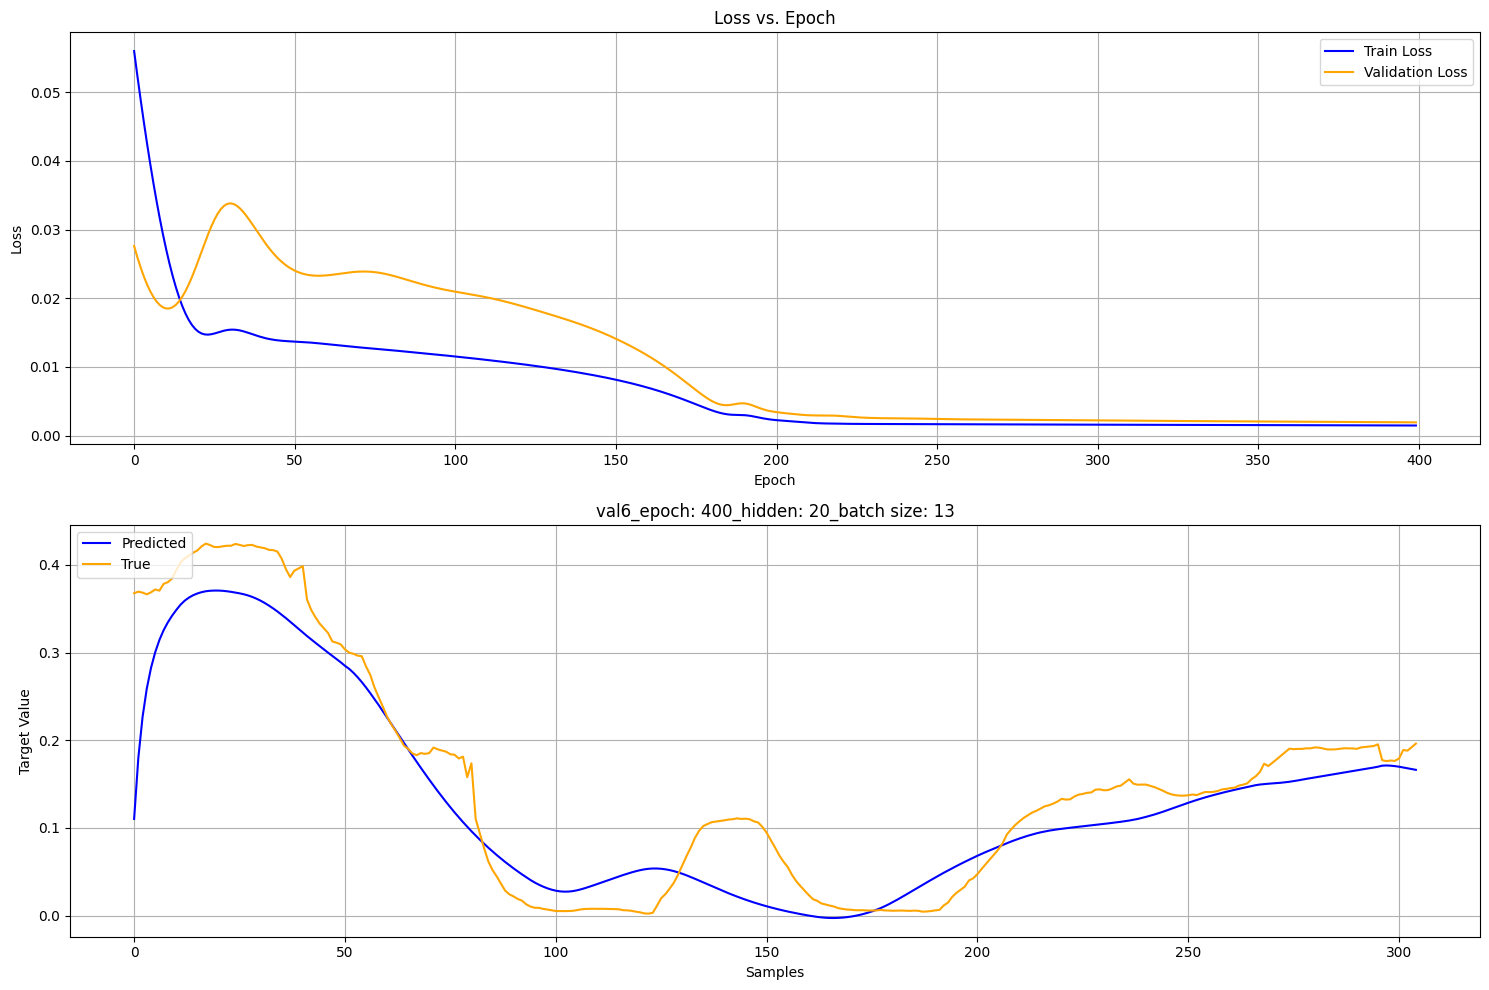

In [40]:

hidden_values = [12,20]
epochs_values = [200,400]
batch_size_values = [13]

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset(train_set, X=features, y=labels)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset(val_set, X=features, y=labels)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(y_val_pred_np[:, i], label='Predicted', color='blue')
            axes[1].plot(y_val_actual_np[:, i], label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

Epoch 0, train loss: 0.10613373667001724, train acc: 0.0, val loss: 0.060008808970451355, val acc: 0.0
Epoch 50, train loss: 0.011446984484791756, train acc: 0.0, val loss: 0.022563781589269638, val acc: 0.0
Epoch 100, train loss: 0.00980009138584137, train acc: 0.0, val loss: 0.017648644745349884, val acc: 0.0
Epoch 150, train loss: 0.008364133536815643, train acc: 0.0, val loss: 0.014537371695041656, val acc: 0.0
Epoch 200, train loss: 0.006208132952451706, train acc: 0.0, val loss: 0.010142941027879715, val acc: 0.0
Epoch 250, train loss: 0.002422132296487689, train acc: 0.0, val loss: 0.0043564122170209885, val acc: 0.0


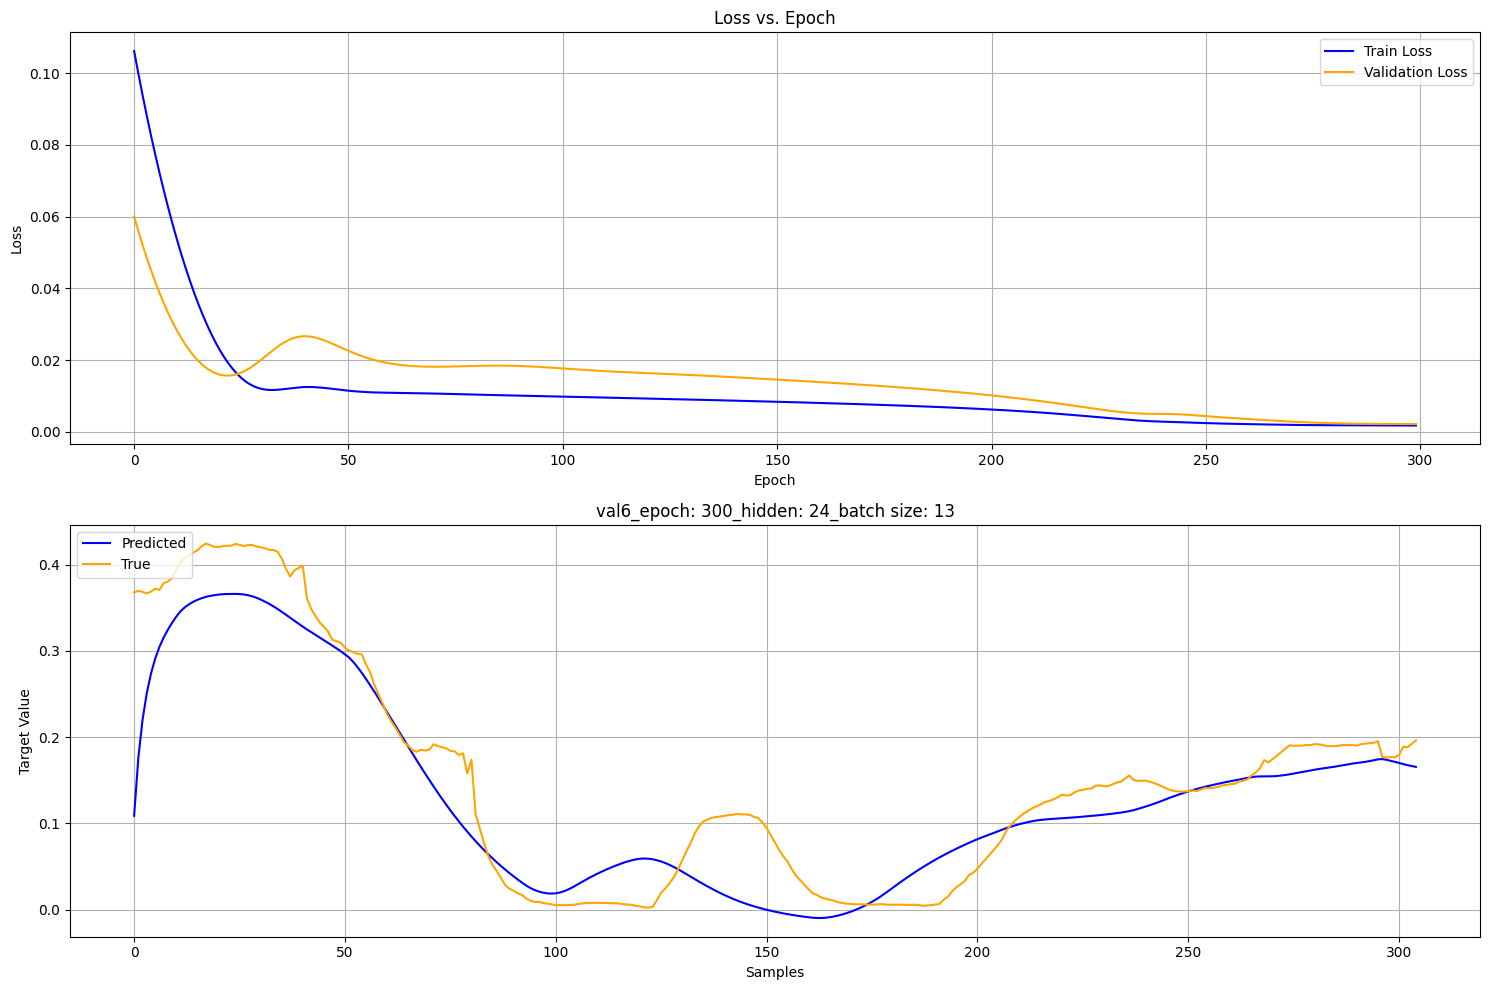

Epoch 0, train loss: 0.05230455473065376, train acc: 0.0, val loss: 0.024968614801764488, val acc: 0.0
Epoch 50, train loss: 0.011690441519021988, train acc: 0.0, val loss: 0.020494064316153526, val acc: 0.0
Epoch 100, train loss: 0.00794703233987093, train acc: 0.0, val loss: 0.013918685726821423, val acc: 0.0
Epoch 150, train loss: 0.0026872155722230673, train acc: 0.0, val loss: 0.004780130926519632, val acc: 0.0
Epoch 200, train loss: 0.0017145014135167003, train acc: 0.0, val loss: 0.002556647639721632, val acc: 0.0
Epoch 250, train loss: 0.001555996248498559, train acc: 0.0, val loss: 0.0020787538960576057, val acc: 0.0


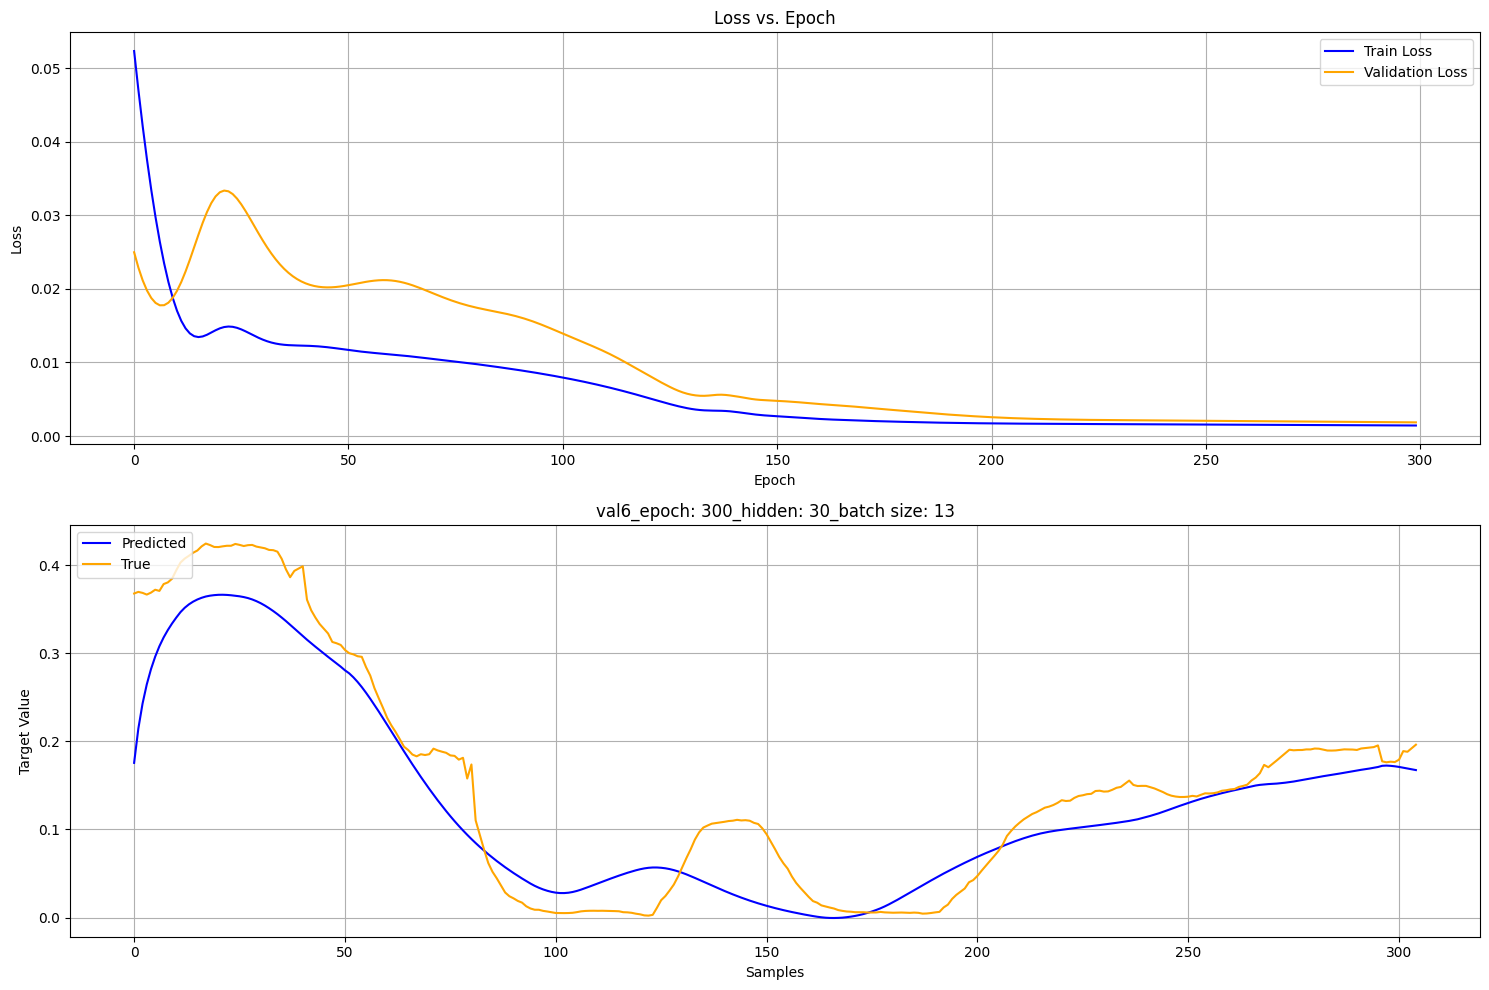

Epoch 0, train loss: 0.07557720690965652, train acc: 0.0, val loss: 0.03552849218249321, val acc: 0.0
Epoch 50, train loss: 0.011433775536715984, train acc: 0.0, val loss: 0.021143458783626556, val acc: 0.0
Epoch 100, train loss: 0.008920175023376942, train acc: 0.0, val loss: 0.015873543918132782, val acc: 0.0
Epoch 150, train loss: 0.0033763449173420668, train acc: 0.0, val loss: 0.005855221766978502, val acc: 0.0
Epoch 200, train loss: 0.0020765194203704596, train acc: 0.0, val loss: 0.003326584817841649, val acc: 0.0
Epoch 250, train loss: 0.0018123239278793335, train acc: 0.0, val loss: 0.002525957766920328, val acc: 0.0


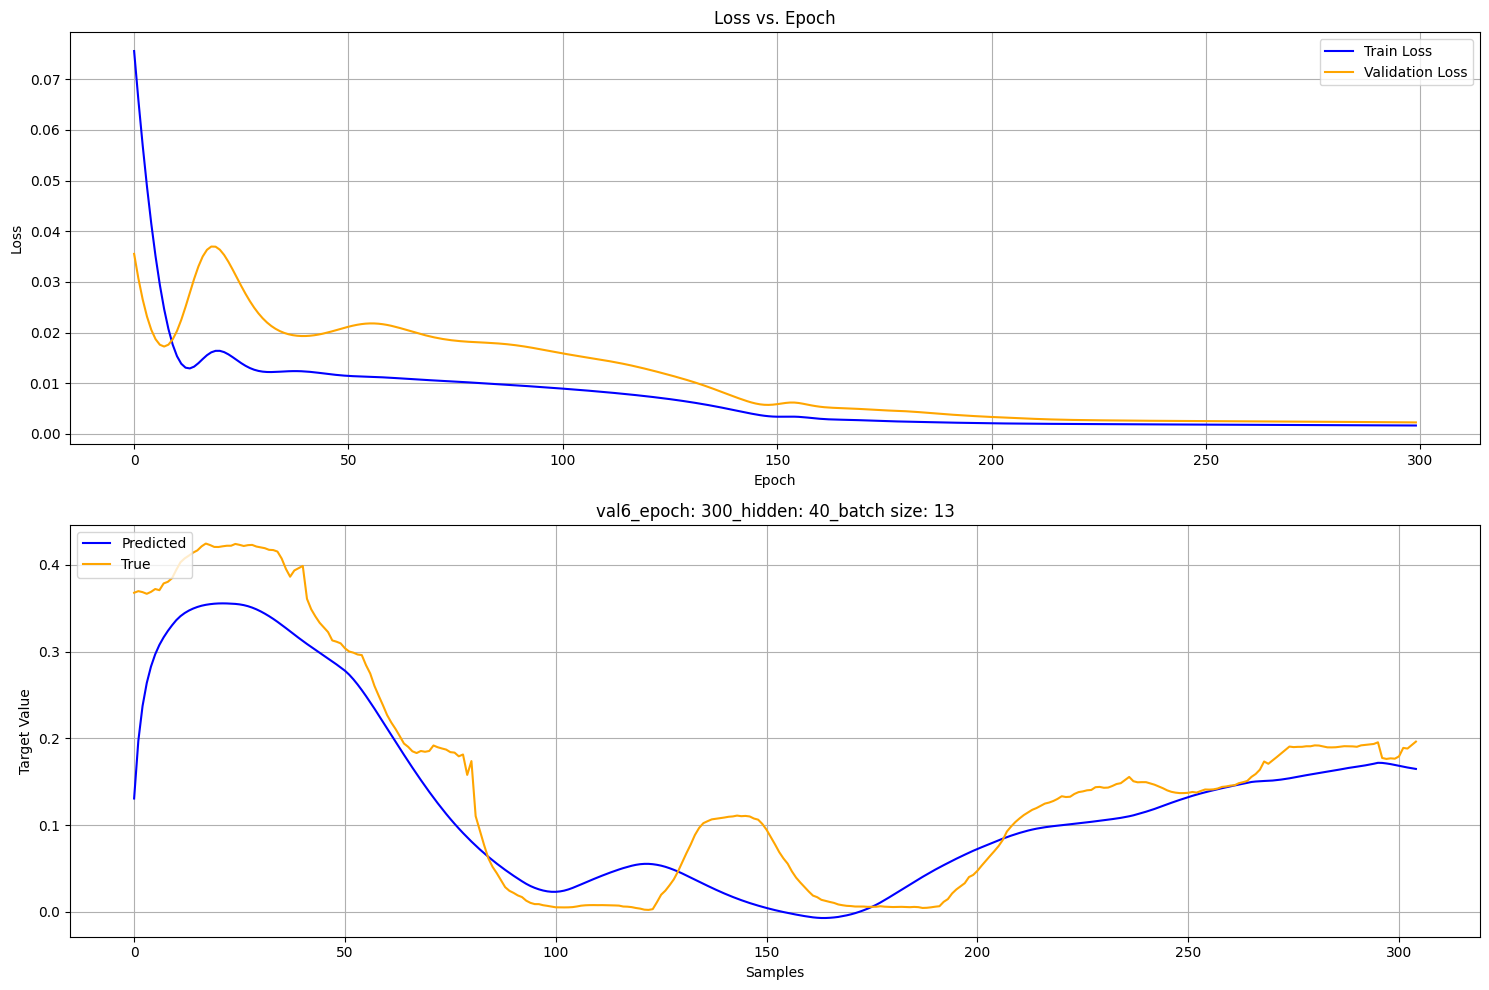

In [42]:

hidden_values = [24,30,40]
epochs_values = [300]
batch_size_values = [13]

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset(train_set, X=features, y=labels)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset(val_set, X=features, y=labels)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(y_val_pred_np[:, i], label='Predicted', color='blue')
            axes[1].plot(y_val_actual_np[:, i], label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

In [41]:
import torch
import torch.nn as nn

class GRUCore_hidden(nn.Module):
    def __init__(self, hidden_size, input_size=1, bias=True):
        super().__init__()
        # Initialize the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, bias=bias, batch_first=True)  # Set batch_first=True
        self.hidden_size = hidden_size
        self.hidden_states = None

    def init_state(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size)  # Shape for GRU [num_layers, batch_size, hidden_size]

    def forward(self, x, hidden_state=None, reverse=True):
        """
        x is expected to have shape [batch_size, sequence_length, input_size]
        """
        # Check if the input is 3D, which is typical for sequence modeling (batch, sequence_length, input_size)
        if len(x.shape) != 3:
            raise RuntimeError(f"Expected 3D input to GRUCore, but got input of size: {x.shape}")

        batch_size, seq_length, _ = x.shape  # Extract dimensions
        
        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self.init_state(batch_size)  # Shape: [1, batch_size, hidden_size]

        # Pass through GRU layer; returns output and final hidden state
        output, hidden_state = self.gru(x, hidden_state)  # output shape: [batch_size, seq_length, hidden_size]

        return hidden_state  # Return both output and final hidden state

import os
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/toy_data_2/toy_data_hidden'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

hidden_values = [12,20]
epochs_values = [200,400]
batch_size_values = [13]

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore_hidden(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset(train_set, X=features, y=labels)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset(val_set, X=features, y=labels)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(y_val_pred_np[:, i], label='Predicted', color='blue')
            axes[1].plot(y_val_actual_np[:, i], label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

c:\Users\kacpe\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([13, 305])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (13) must match the size of tensor b (305) at non-singleton dimension 1

Epoch 0, train loss: 4.865730285644531, train acc: 0.0, val loss: 10.10185432434082, val acc: 0.0
Epoch 50, train loss: 2.6535556316375732, train acc: 0.0, val loss: 6.3141655921936035, val acc: 0.0
Epoch 100, train loss: 0.8694426417350769, train acc: 0.0, val loss: 3.2205748558044434, val acc: 0.0
Epoch 150, train loss: 0.6444182991981506, train acc: 0.0, val loss: 2.371217727661133, val acc: 0.0
Epoch 200, train loss: 0.5487800240516663, train acc: 0.0, val loss: 2.088836193084717, val acc: 0.0
Epoch 250, train loss: 0.4643508791923523, train acc: 0.0, val loss: 1.7866452932357788, val acc: 0.0
Epoch 300, train loss: 0.39922210574150085, train acc: 0.0, val loss: 1.541080355644226, val acc: 0.0
Epoch 350, train loss: 0.35299089550971985, train acc: 0.0, val loss: 1.3517247438430786, val acc: 0.0
Epoch 400, train loss: 0.3230716288089752, train acc: 0.0, val loss: 1.211972713470459, val acc: 0.0
Epoch 450, train loss: 0.3034413158893585, train acc: 0.0, val loss: 1.110920786857605, v

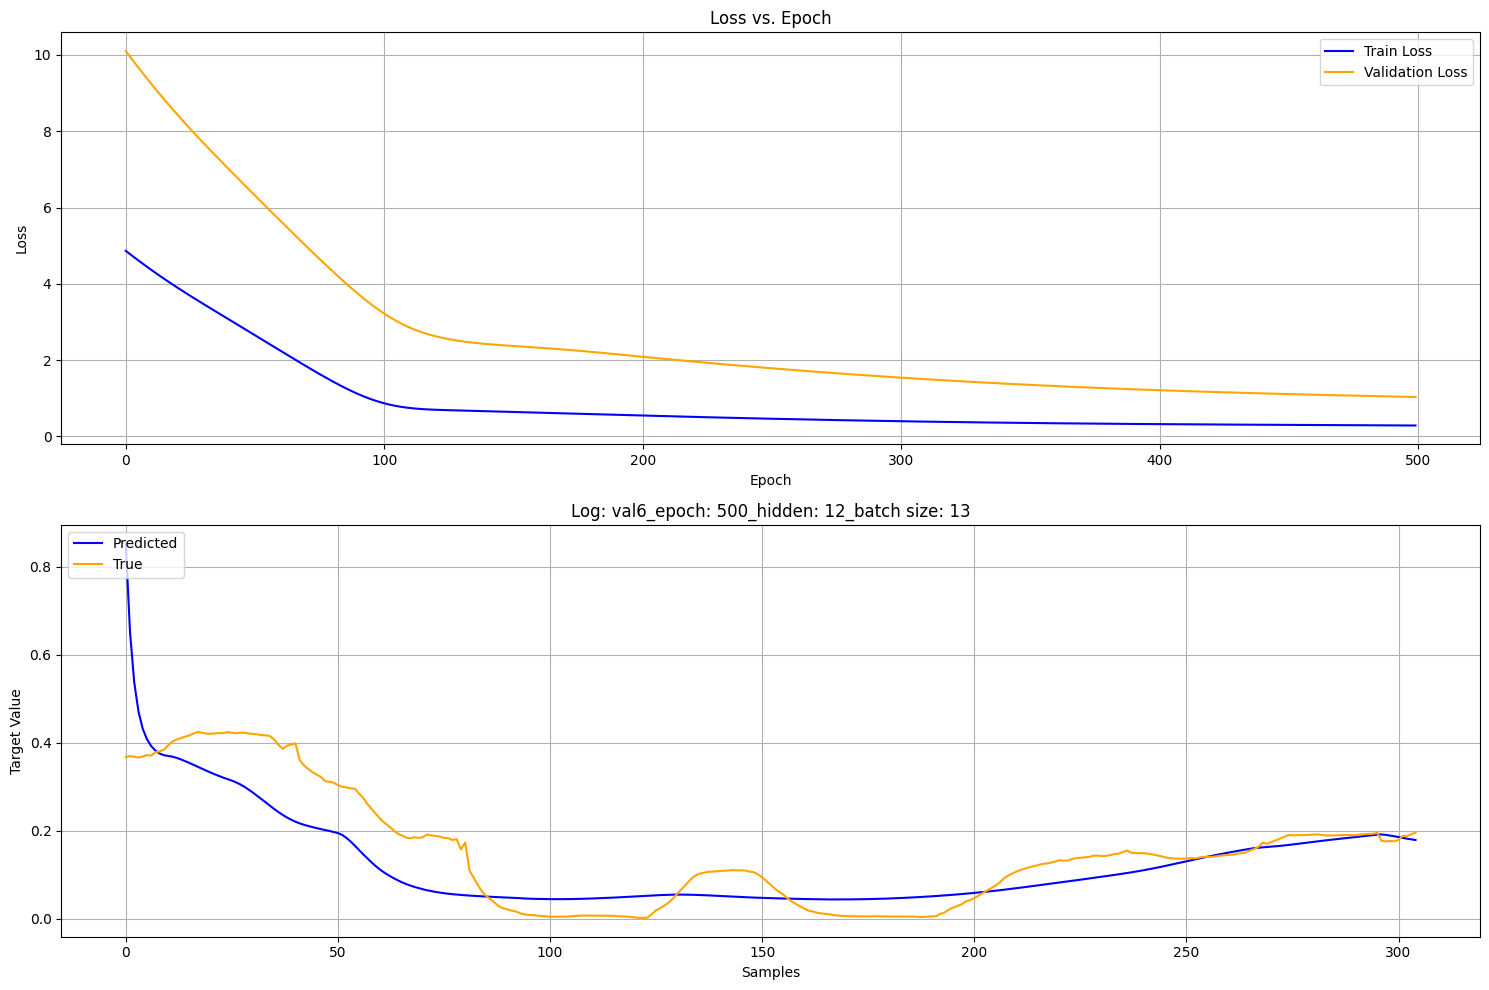

Epoch 0, train loss: 4.020534992218018, train acc: 0.0, val loss: 9.091446876525879, val acc: 0.0


KeyboardInterrupt: 

In [51]:
hidden_values = [12,24,36]
epochs_values = [500]
batch_size_values = [13]

import os
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/toy_data_log'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset(train_set, X=features, y=labels)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset(val_set, X=features, y=labels)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(np.exp(y_val_pred_np[:, i]), label='Predicted', color='blue')
            axes[1].plot(np.exp(y_val_actual_np[:, i]), label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'Log: val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

Epoch 0, train loss: 4.50153923034668, train acc: 0.0, val loss: 10.449845314025879, val acc: 0.0
Epoch 50, train loss: 2.7043230533599854, train acc: 0.0, val loss: 7.13230037689209, val acc: 0.0
Epoch 100, train loss: 1.0499227046966553, train acc: 0.0, val loss: 3.863494873046875, val acc: 0.0
Epoch 150, train loss: 0.738385796546936, train acc: 0.0, val loss: 2.7224984169006348, val acc: 0.0
Epoch 200, train loss: 0.6425678730010986, train acc: 0.0, val loss: 2.444498062133789, val acc: 0.0
Epoch 250, train loss: 0.5281900763511658, train acc: 0.0, val loss: 2.0549917221069336, val acc: 0.0
Epoch 300, train loss: 0.4323541820049286, train acc: 0.0, val loss: 1.7178152799606323, val acc: 0.0
Epoch 350, train loss: 0.3661912679672241, train acc: 0.0, val loss: 1.4596656560897827, val acc: 0.0


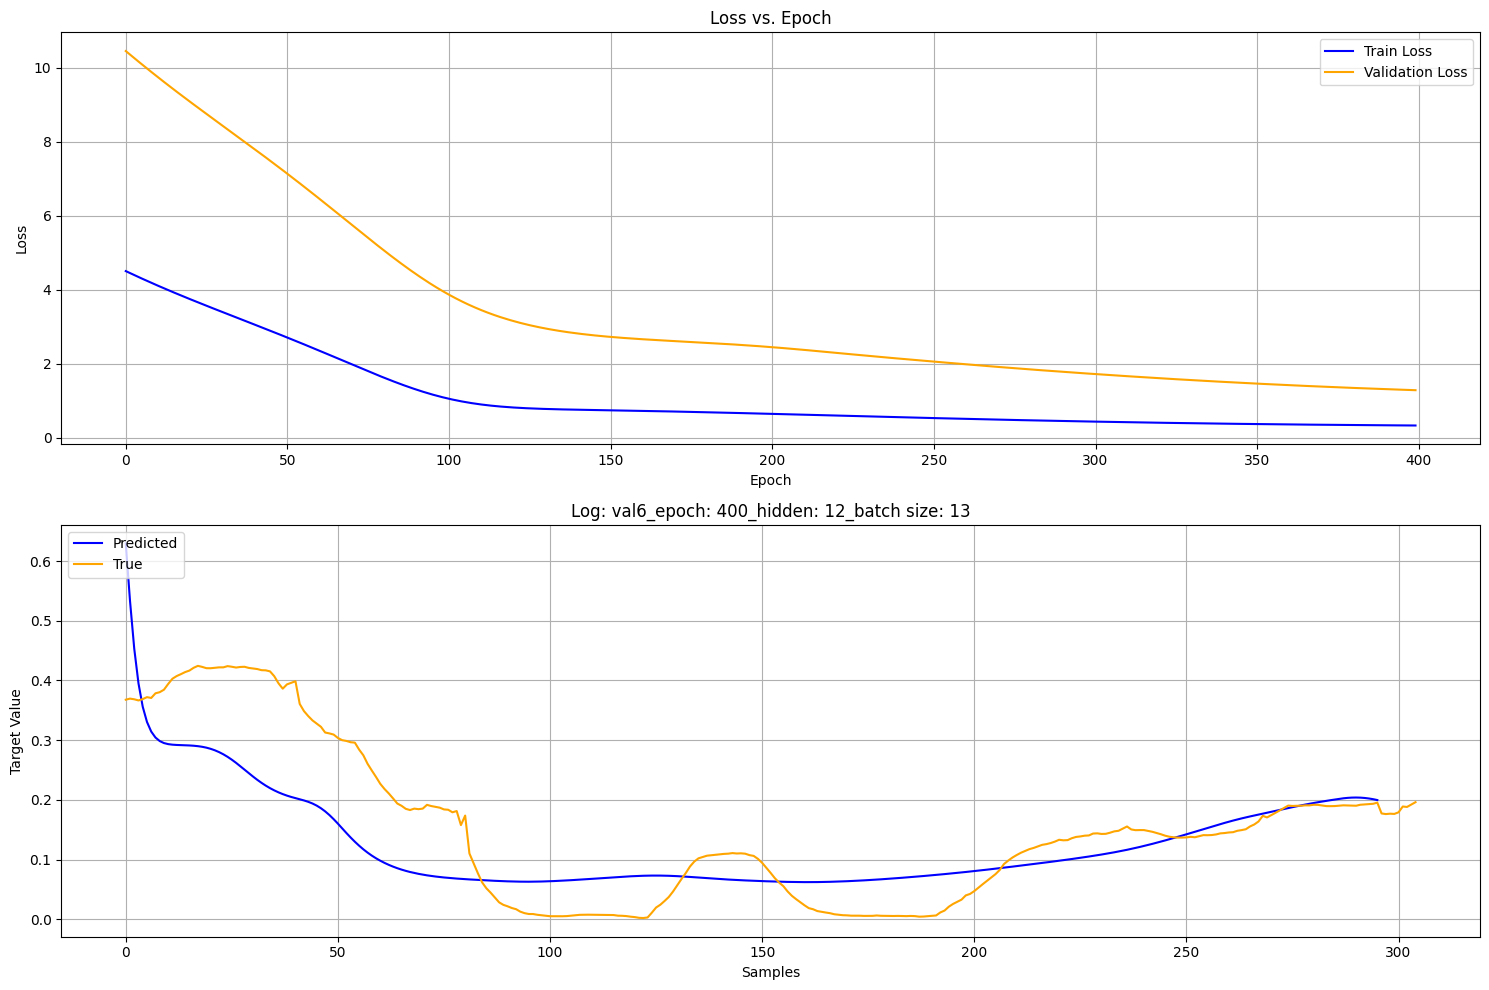

In [53]:
import torch
from torch.utils.data import Dataset

import torch
from torch.utils.data import Dataset
import pandas as pd

class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=10):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor



hidden_values = [12]
epochs_values = [400]
batch_size_values = [13]

import os
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/toy_data_log_seq10'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(np.exp(y_val_pred_np[:, i]), label='Predicted', color='blue')
            axes[1].plot(np.exp(y_val_actual_np[:, i]), label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'Log: val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

In [55]:


class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=10):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor



hidden_values = [16,24,32]
epochs_values = [400,600,1000]
batch_size_values = [13]

import os
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/toy_data_log_seq10'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for h in hidden_values:
    for e in epochs_values:
        for b in batch_size_values:
            hidden_size = h
            batch_size = 13
            core = GRUCore(hidden_size)
            readout = LinearReadout(hidden_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            #loss_fn = nn.PoissonNLLLoss()
            loss_fn = nn.MSELoss()
            n_epochs = e           
            data = 'data_model_v1.csv'
            labels = ['aDistReach_3']
            columns_to_shift = ['aDistReach_3']
            set_value = 6
            shift = 30
            df = pd.read_csv(data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]
            # Step 1: Find the minimum length of all trials
            trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/4d_model'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_lagged'
                    trial_df[new_col_name] = trial_df[col].shift(-shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
                
            selected_columns = ['trial','aDistReach_3','aDistReach_3_lagged']
            shifted_df = shifted_df[selected_columns]
            #print(shifted_df.columns)
            features = ['aDistReach_3_lagged']
            train_set = shifted_df[(shifted_df['trial'] != set_value)]

            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Use batch_size=1
            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1




            train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

            # Create a figure with 3 subplots (1 row, 2 columns)
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust size and layout

            # First subplot - Loss vs Epoch
            axes[0].plot(train_losses, label='Train Loss', color='blue')
            axes[0].plot(val_losses, label='Validation Loss', color='orange')
            axes[0].set_title('Loss vs. Epoch')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend(loc='upper right')
            axes[0].grid()

            # Second subplot - Validation Prediction vs True Values
            y_val_pred_np = yPred_val.detach().cpu().numpy().T
            y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)

            # Assuming the index `i` is defined and valid
            i = 0  # You can modify this to loop over multiple indices
            axes[1].plot(np.exp(y_val_pred_np[:, i]), label='Predicted', color='blue')
            axes[1].plot(np.exp(y_val_actual_np[:, i]), label='True', color='orange')

            # Set titles and labels
            axes[1].set_title(f'Log: val{set_value}_epoch: {n_epochs}_hidden: {hidden_size}_batch size: {batch_size}')
            axes[1].set_xlabel('Samples')
            axes[1].set_ylabel('Target Value')
            axes[1].legend(loc='upper left')
            axes[1].grid()

            # Adjust layout
            plt.tight_layout()

            # Save the plot
            plot_filename = f'val{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)
            fig.savefig(plot_dir)

            # Show the figure
            plt.show()

Epoch 0, train loss: 3.7359611988067627, train acc: 0.0, val loss: 8.862613677978516, val acc: 0.0


In [ ]:
train_set[['aDistReach_3']].shape

In [ ]:
y_val_pred_np = yPred_val.detach().cpu().numpy().T
y_val_actual_np = val_set['aDistReach_3'].values.reshape(-1, 1)
print(y_val_pred_np)

In [ ]:
(y_val_pred_np.shape)
#(y_val_actual_np.shape)

In [ ]:
for i in range(1):
    plt.figure(figsize=(15, 4))
    
    # Plot for validation data
    plt.plot(y_val_pred_np[:, i], label='Predicted', color='blue')
    plt.plot(y_val_actual_np[:, i], label='True', color='orange')
    
    # Set titles and labels
    plt.title(f'Validation Set:{set_value} {labels[i]}')
    plt.xlabel('Samples')
    plt.ylabel('Feature Value')
    plt.legend(loc='upper left')
    plt.grid()
    #plot_filename = f'{save_dir}validation_plot_feature_{i}_epoch_{epoch+1}.png'
    #plt.savefig(plot_filename)
    # Show the plot
    plt.show()

# Sinewave data

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Generate sinusoidal data
shift = 50
X = np.sin(np.linspace(0, 100, 10000))  # 10000 time steps
Y = np.roll(X, -shift)  # Shift by 10 steps
Y[-shift:] = np.nan  # Set the last 10 elements to NaN

# Remove NaN values for simplicity
X = X[:-shift]
Y = Y[:-shift]

# Reshape X and Y from (9990,) to (9990, 1)
X = X.reshape((9950, 1))
Y = Y.reshape((9950, 1))

# Step 4: Split into training and testing sets (use raw data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Step 5: Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape (num_train_samples, 1)
Y_train = torch.tensor(Y_train, dtype=torch.float32)  # Shape (num_train_samples, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)    # Shape (num_test_samples, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float32)    # Shape (num_test_samples, 1)


# Step 3: Instantiate the GRU model
input_dim = 1  # One feature per timestep (the sine wave values)
hidden_dim = 70
output_dim = 1  # Predict the next value in the sequence

model = GRUCellNet(input_dim, hidden_dim, output_dim)

# Step 8: Set up loss, optimizer, and ReduceLROnPlateau scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Reduce the learning rate when the loss has plateaued (patience=10, factor=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Step the scheduler based on the loss
    scheduler.step(loss)  # Pass the metric you want to monitor (training loss in this case)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
# Step 10: Make predictions on the test set
model.eval()
with torch.no_grad():
    predicted_test = model(X_test)
    predicted_train = model(X_train)

# Convert predictions to NumPy arrays
predicted_train_np = predicted_train.numpy()
predicted_test_np = predicted_test.numpy()

# Find maximum values
train_predicted_max = np.max(predicted_train_np)
test_predicted_max = np.max(predicted_test_np)

print('Train predicted max:', train_predicted_max)
print('Test predicted max:', test_predicted_max)

# Step 11: Plot the test results
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='True Test Values', color='green')
plt.plot(predicted_test_np, label='Predicted Test Values', color='red')
plt.title('Test Results')
plt.legend()
plt.show()

# Step 11: Plot the training results
plt.figure(figsize=(10, 6))
plt.plot(Y_train, label='True Train Values', color='green')
plt.plot(predicted_train_np, label='Predicted Train Values', color='red')
plt.title('Training Results')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Step 1: Generate sinusoidal data
shift = 30
n = 3000
Y = np.sin(np.linspace(0, 100, n))  # 10000 time steps
X = np.roll(Y, -shift)  # Shift by 10 steps
X[-shift:] = np.nan  # Set the last 10 elements to NaN

# Remove NaN values for simplicity
X = X[:-shift]
Y = Y[:-shift]

# Reshape X and Y from (9990,) to (9990, 1)
X = X.reshape((n-shift, 1))
Y = Y.reshape((n-shift, 1))

# Step 4: Split into training and testing sets (use raw data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Step 5: Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape (num_train_samples, 1)
Y_train = torch.tensor(Y_train, dtype=torch.float32)  # Shape (num_train_samples, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)    # Shape (num_test_samples, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float32)    # Shape (num_test_samples, 1)

plt.plot(X,label='X',c='red')
plt.plot(Y,label='Y',c='darkblue')
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader  # Import TensorDataset and DataLoader
# Step 2: Create sequences from X and Y
seq_length = 50
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_seq = create_sequences(X, seq_length)
Y_seq = create_sequences(Y, seq_length)


# Step 3: Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, shuffle=False)

# Step 4: Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape (num_train_samples, seq_length)
Y_train = torch.tensor(Y_train, dtype=torch.float32)  # Shape (num_train_samples, seq_length)
X_test = torch.tensor(X_test, dtype=torch.float32)    # Shape (num_test_samples, seq_length)
Y_test = torch.tensor(Y_test, dtype=torch.float32)    # Shape (num_test_samples, seq_length)

# Step 5: Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of checking a batch from the dataloader
for batch_x, batch_y in train_dataloader:
    print("Batch X shape:", batch_x.shape)  # Should be (batch_size, seq_length)
    print("Batch Y shape:", batch_y.shape)  # Should be (batch_size, seq_length)
    break

In [ ]:
plt.plot(X,c='red')
plt.plot(Y,c='darkblue')

In [626]:
hidden_size = 10
batch_size = 1
core = GRUCore(hidden_size)
readout = LinearReadout(hidden_size)
model = CoreAndReadout(core, readout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
#loss_fn = nn.PoissonNLLLoss()
loss_fn = nn.MSELoss()
n_epochs = 10

train_losses, train_accs, val_losses, val_accs, yPred_tr, yPred_val = run_training(train_dataloader, test_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)

RuntimeError: Expected 2D input to GRUCore, but got input of size: torch.Size([32, 50, 1])

In [608]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
       # x = torch.sigmoid(x)
       # return self.nonlinearity(x)
        return x

In [627]:
core = GRUCore(hidden_size)
readout = LinearReadout(hidden_size)
model = CoreAndReadout(core, readout)

for X,Y in train_dataloader:
  #  out, _ = core(X)
   # type(out)
  #  out = readout(out)
    out = model(out)
    print(out)
    

tensor([[-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572],
        [-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572],
        [-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572],
        ...,
        [-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572],
        [-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572],
        [-0.1274, -0.0844, -0.0636,  ..., -0.0523, -0.0548, -0.0572]],
       grad_fn=<SqueezeBackward1>)
tensor([[-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591],
        [-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591],
        [-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591],
        ...,
        [-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591],
        [-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591],
        [-0.1384, -0.1009, -0.0828,  ..., -0.0658, -0.0636, -0.0591]],
       grad_fn=<SqueezeBackward1>)
tensor([[-0.1382, -0.1001, -0.0813,  ..., -0.0628, -0.0609, -0

# Packed sequences

In [70]:
class GRUCore(nn.Module):
    def __init__(self, hidden_size, input_size=1, bias=True):
        super().__init__()
        # Initialize the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, bias=bias, batch_first=True)  # Set batch_first=True
        self.hidden_size = hidden_size
        self.hidden_states = None

    def init_state(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size)  # Shape for GRU [num_layers, batch_size, hidden_size]

    def forward(self, x, hidden_state=None, reverse=True):
        """
        x is expected to have shape [batch_size, sequence_length, input_size]
        """
        # Check if the input is 3D, which is typical for sequence modeling (batch, sequence_length, input_size)
        if len(x.shape) != 3:
            raise RuntimeError(f"Expected 3D input to GRUCore, but got input of size: {x.shape}")

        batch_size, seq_length, _ = x.shape  # Extract dimensions
        
        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self.init_state(batch_size)  # Shape: [1, batch_size, hidden_size]

        # Pass through GRU layer; returns output and final hidden state
        output, hidden_state = self.gru(x, hidden_state)  # output shape: [batch_size, seq_length, hidden_size]

        return output  # Return both output and final hidden state

In [71]:
class ExperimentEncoder(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, device=None):
        super().__init__()
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        
        return factors

In [72]:
class LinearReadout(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        #return x.squeeze(dim=2)
        return x
    
    
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Output layer to transform the hidden state to output size
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, hidden_size)
        gru_out, hidden = self.gru(x, hidden)  # Forward pass through GRU
        
        # Apply the linear layer to each time step's output
        output = self.linear(gru_out)  # Output shape will be (batch_size, seq_len, output_size)
        return output # Return output and hidden state

In [73]:
class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=1):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor

In [74]:
class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=1):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor

In [75]:
def collate_packed_sequences(batch):
    X, Y = zip(*batch)
    X = [torch.Tensor(elem).to(device) for elem in X]
    Y = [torch.Tensor(elem).to(device) for elem in Y]
    return pack_sequence(X, enforce_sorted=False), Y

In [76]:
os.chdir('C:\\Users\\kacpe\\Desktop\\lab_rotation_git\\')

In [69]:
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3','oDistReach3']
hidden_size = 10
set_value = 7
batch_size = 13
lag_word = '_lagged'
input_size = len(columns_to_shift)
output_size = len(labels)
core = GRUCore(hidden_size,input_size)
readout = LinearReadout(hidden_size, output_size)
model = CoreAndReadout(core, readout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
loss_fn = nn.MSELoss()
n_epochs = 500           
data = 'data_model_v1.csv'

shift = 1
df = pd.read_csv(data)
def bin_trial_data(trial_df):
    return trial_df.groupby(trial_df.index // 5).mean()

# Apply binning within each 'trial' group
df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
df[columns_to_shift] = df[columns_to_shift].apply(np.log)
df = df.drop(columns='id')
df = df[df['trial'] != 1]
# Step 1: Find the minimum length of all trials
#trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
#min_length = trial_lengths.min()            # Find the shortest sequence length

# Step 2: Cut all trials to the length of the shortest sequence
#df = df.groupby('trial').head(min_length).reset_index(drop=True)

#   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
#  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
#shifted_df = shift_dataframe(df,shift,columns_to_shift)
# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + lag_word
        trial_df[new_col_name] = trial_df[col].shift(-shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



train_set = shifted_df[(shifted_df['trial'] != set_value)]
train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)

val_set = shifted_df[(shifted_df['trial'] == set_value)]
val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)


In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=13, shuffle=True, collate_fn=collate_packed_sequences)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)

In [29]:
device = get_device()

Using device: cpu


In [196]:
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
      #  cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        
        return rates
    
    
class LinearReadout(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        #return x.squeeze(dim=2)
        return x

In [50]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        return x

In [60]:
def train(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:

        optimizer.zero_grad()
        
        y_pred = model(x)
        
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), y_pred

In [61]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())
    
    return np.mean(epoch_loss), y_pred

In [62]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        
        val_losses.append(epoch_val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
            
    return train_losses, val_losses, yPred_tr, yPred_val

In [144]:
class M2S_Loss(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='sum')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            # Pad sequences to ensure they have the same length
            padded_y_pred = pad_sequence([seq for seq in y_pred], batch_first=True)
            padded_y = pad_sequence([seq for seq in y], batch_first=True)
            
            # Compute the loss (MSE in this case) between the padded sequences
            loss = self.criterion(padded_y_pred, padded_y) / len(y_pred)  # average over the batch
            return loss
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [126]:
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/packed_sequence_with_human'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [163]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class ExperimentEncoder2(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, device=None):
        super().__init__()
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # Unidirectional GRU
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        # factors shape: (batch_size, seq_length, hidden_size)
        factors, _ = self.gru(input_, initial_hidden_state)

        # Unpack the output
        factors = unpack_sequence(factors)  # This returns a list of tensors (one for each sequence)
        
        return factors  # Return a list of tensors instead of a single tensor
      
class NonlinearDecoder2(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nonlinearity = nn.ReLU()
        self.device = device
        
    def forward(self, factors):
        # Concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
        cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        if self.nonlinearity is not None: 
            rates = [self.nonlinearity(rate) for rate in rates]
        
        return [rates]  # Return a list of length 1 containing the rates
    
def train2(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        
        y_pred = model(x)  # y_pred will be a list of length 1
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), y_pred  # Return predictions in list format


def validate2(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            y_pred = model(x)  # y_pred will be a list of length 1
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())
    
    return np.mean(epoch_loss), y_pred  # Return predictions in list format

def run_training2(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train2(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate2(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        
        val_losses.append(epoch_val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
            
    return train_losses, val_losses, yPred_tr, yPred_val


In [80]:
class M2S_Loss2(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='sum')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            # Pad sequences to ensure they have the same length
            padded_y_pred = pad_sequence([seq for seq in y_pred], batch_first=True)
            padded_y = pad_sequence([seq for seq in y], batch_first=True)
            
            # Move to the same device
            device = padded_y_pred.device
            padded_y = padded_y.to(device)
            
            # Create a mask to ignore padding tokens
            mask = (padded_y != 0).float()
            
            # Compute the loss (MSE in this case) between the padded sequences
            loss = self.criterion(padded_y_pred * mask, padded_y * mask)
            return loss
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [327]:
hidden_size

16

In [348]:
labels = ['aDistReach_3']
columns_to_shift = ['aDistReach_3']
batch_size = 13
lag_word = '_lagged'
input_size = len(columns_to_shift)
output_size = len(labels)
core = ExperimentEncoder(input_size,hidden_size)
readout = LinearReadout(hidden_size, output_size)
model = CoreAndReadout(core, readout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
loss_fn = nn.MSELoss()
loss_fn = M2S_Loss2(nn.MSELoss())
data = 'data_model_v1.csv'
shift = 30
df = pd.read_csv(data)
def bin_trial_data(trial_df):
    return trial_df.groupby(trial_df.index // 5).mean()
#df[labels] = df[labels].apply(np.log)
df[columns_to_shift] = df[columns_to_shift].apply(np.log)
df = df.drop(columns='id')
df = df[df['trial'] != 1]
# Step 1: Find the minimum length of all trials
#trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
#min_length = trial_lengths.min()            # Find the shortest sequence length

# Step 2: Cut all trials to the length of the shortest sequence
#df = df.groupby('trial').head(min_length).reset_index(drop=True)

#save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
#os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
#shifted_df = shift_dataframe(df,shift,columns_to_shift)
# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()
print(df['aDistReach_3'])
# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + lag_word
        trial_df[new_col_name] = trial_df[col].shift(-shift)
        #print(trial_df['aDistReach_3_lagged'])

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()
    #print(trial_df.head())


    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


train_set = shifted_df[(shifted_df['trial'] != set_value)]
train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)

val_set = shifted_df[(shifted_df['trial'] == set_value)]
val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
train_losses, val_losses, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_function, n_epochs, scheduler=None, device=None, verbose=True)


161    -1.117599
162    -1.104479
163    -1.091293
164    -1.078057
165    -1.064786
          ...   
7732   -0.970593
7733   -0.957282
7734   -0.952862
7735   -0.948422
7736   -0.946021
Name: aDistReach_3, Length: 7576, dtype: float64


TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [347]:
for x,y in train_dataloader:
    out = core(x)
    readout(out)
    

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [77]:
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/packed_fixedLoss'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [83]:
device = get_device()

Using device: cpu


Epoch 0, train loss: 0.11133609712123871, val loss: 0.11299038678407669
Epoch 10, train loss: 0.04205441474914551, val loss: 0.036479562520980835
Epoch 20, train loss: 0.011901602149009705, val loss: 0.01097777858376503
Epoch 30, train loss: 0.008391179144382477, val loss: 0.014879070222377777
Epoch 40, train loss: 0.009329121559858322, val loss: 0.01666349731385708
Epoch 50, train loss: 0.008178232237696648, val loss: 0.013006878085434437
Epoch 60, train loss: 0.00802293885499239, val loss: 0.011326988227665424
Epoch 70, train loss: 0.008040989749133587, val loss: 0.01123832631856203
Epoch 80, train loss: 0.007968151941895485, val loss: 0.011684847064316273
Epoch 90, train loss: 0.007958229631185532, val loss: 0.01193858403712511
Epoch 100, train loss: 0.007943708449602127, val loss: 0.011792768724262714
Epoch 110, train loss: 0.007931023836135864, val loss: 0.011605875566601753
Epoch 120, train loss: 0.007921085692942142, val loss: 0.01155799999833107
Epoch 130, train loss: 0.0079112

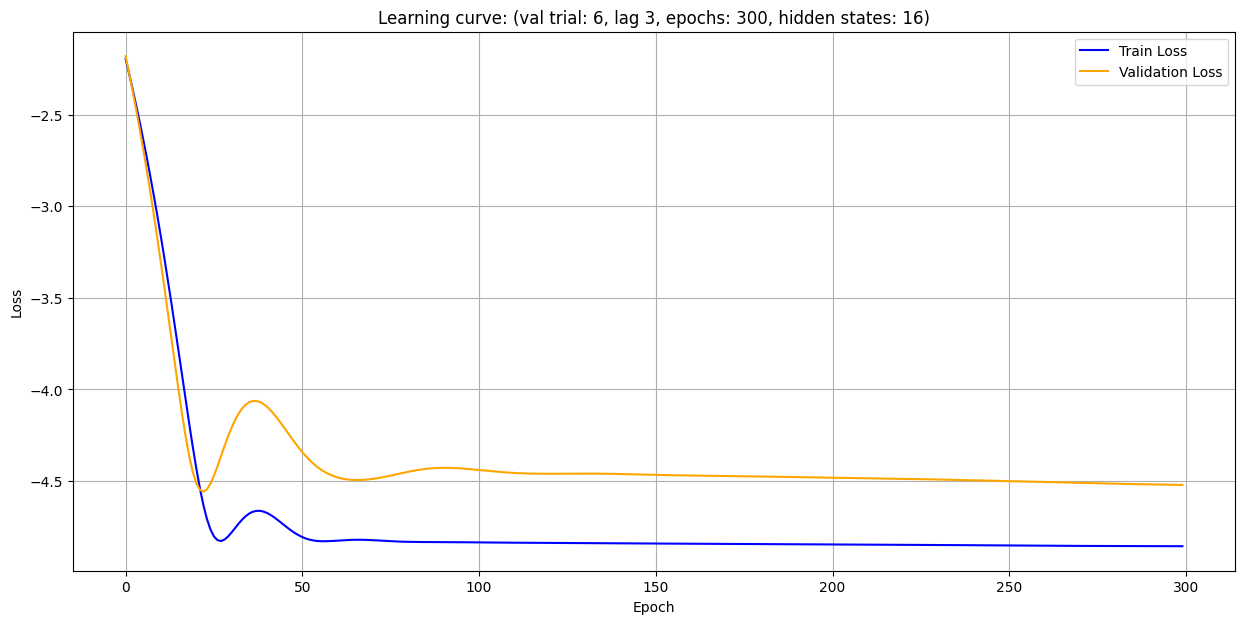

NameError: name 'create_lineplots' is not defined

In [84]:
hidden_values = [16,32]
epoch_values = [300,700]
val_values = [6,7,8]

for h in hidden_values:
    for e in epoch_values:
        for v in val_values: 
            hidden_size= h
            n_epochs = e
            set_value = v
            labels = ['aDistReach_3']
            columns_to_shift = ['oDistReach3']
            batch_size = 13
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss_fn = nn.MSELoss()
            loss_function = M2S_Loss2(nn.MSELoss())
            data = 'data_model_v1.csv'
            def bin_trial_data(trial_df):
                return trial_df.groupby(trial_df.index // 5).mean()
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            shift = 3
            df = pd.read_csv(data)
            
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]

            # Step 1: Find the minimum length of all trials
            #trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            #min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            #df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()
            
            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


            train_set = shifted_df[(shifted_df['trial'] != set_value)]
            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)

            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)


            train_losses, val_losses, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_function, n_epochs, scheduler=None, device=None, verbose=True)
            # Create a figure for the learning curve
            fig, ax = plt.subplots(figsize=(15, 7))  # Adjust size if necessary

            # Plot both Train and Validation Loss on the same axis
            ax.plot(np.log(train_losses), label='Train Loss', color='blue')
            ax.plot(np.log(val_losses), label='Validation Loss', color='orange')

            # Set title, labels, and legend
            ax.set_title((f'Learning curve: (val trial: {set_value}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend(loc='upper right')
            ax.grid()

            # Save the learning curve plot
            plot_name = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}_LC.png'
            lc_dir = os.path.join(save_dir, plot_name)
            plt.savefig(lc_dir)
            plt.show()

            # Second subplot - Validation Prediction vs True Values
            # Assuming yPred_val is a list of length 1
            y_val_pred_np = yPred_val[0].detach().cpu().numpy()  # Extract first element and convert to numpy

            # Collect true values from validation dataset
            y_val_true_np = []

            # Iterate through the validation dataloader to gather true values
            for X_batch, y_batch in val_dataloader:
                # Assuming y_batch is a list of length 1
                y_val_true_np.append(y_batch[0].numpy())  # Extract first element and convert to numpy

            # Flatten the list of arrays into a single array
            y_val_true_np = np.concatenate(y_val_true_np, axis=0)

            # Create a line plot comparing predictions vs true values
            plot_filename = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)

            # Ensure that you are plotting the correct values, applying exp if needed
            create_lineplots(np.exp(y_val_pred_np), np.exp(y_val_true_np), labels, trial=set_value, 
                            shift=shift, n_epochs=n_epochs, hidden_size=hidden_size, 
                            file_path=plot_dir,features=features, size=(18, 5))
            
    
    
    

In [79]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, num_layers=1, dropout=0.0, device=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device

        # Define the GRU layer
        self.gru = nn.GRU(input_size=hidden_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True, 
                          dropout=dropout)

        # Output linear layer to transform GRU outputs to desired output size
        self.fc = nn.Linear(hidden_size, output_size)

        # Optional dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, factors):
        # Ensure the input is a list of sequences (tensors)
        if not isinstance(factors, list):
            raise ValueError("Expected input to be a list of sequences.")

        # Get the lengths of each sequence
        lengths = [factor.shape[0] for factor in factors]

        # Concatenate all sequences into a single tensor along the batch dimension
        # The batch size will be the total number of sequences, each with its own sequence length
        cat_fs = torch.cat(factors, dim=0).unsqueeze(1)  # Add batch dimension (for GRU)

        # Pass the concatenated sequence through the GRU
        gru_output, _ = self.gru(cat_fs)

        # Apply the linear transformation (fc) to the GRU output
        rates = self.fc(gru_output)

        # Remove the batch dimension and split the result back into the original list of sequences
        rates = rates.squeeze(1)  # Remove the added batch dimension

        # Split back into the original sequences based on the lengths
        rates = list(torch.split(rates, lengths))  # Convert tuple to list here

        # Return the list of output sequences
        return rates
    
    
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
      #  cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        
        return rates

In [395]:
save_dir = 'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/ANGFeed'
os.makedirs(save_dir, exist_ok=True)

Epoch 0, train loss: 0.0003517312288749963, val loss: 0.004141611512750387


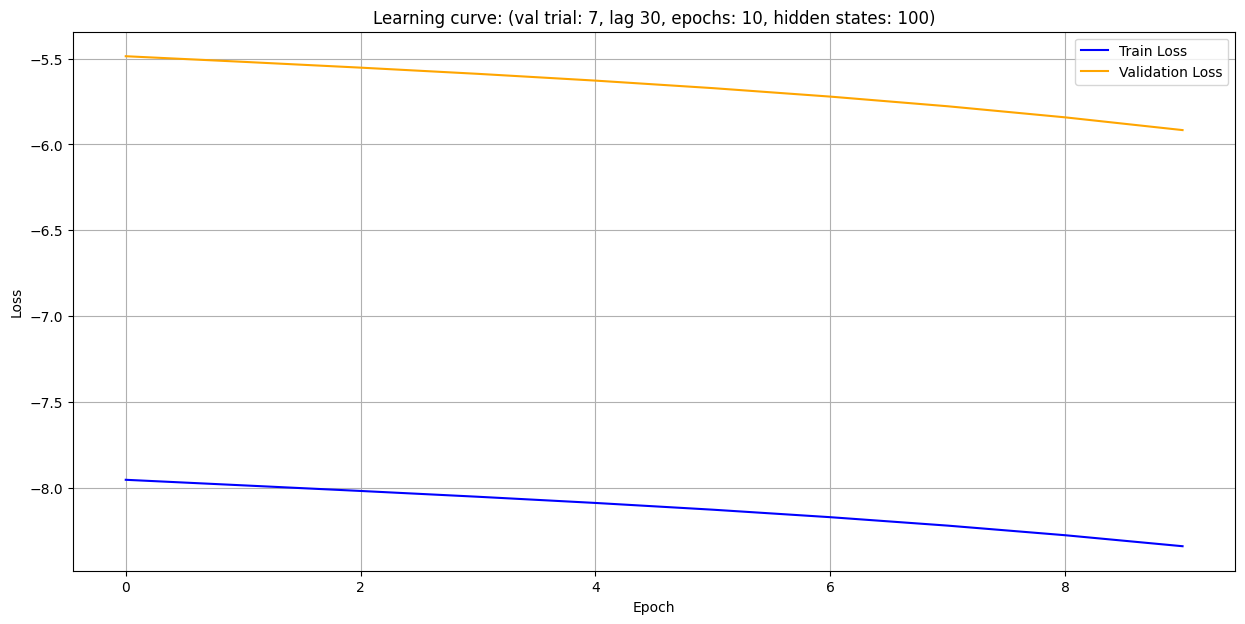

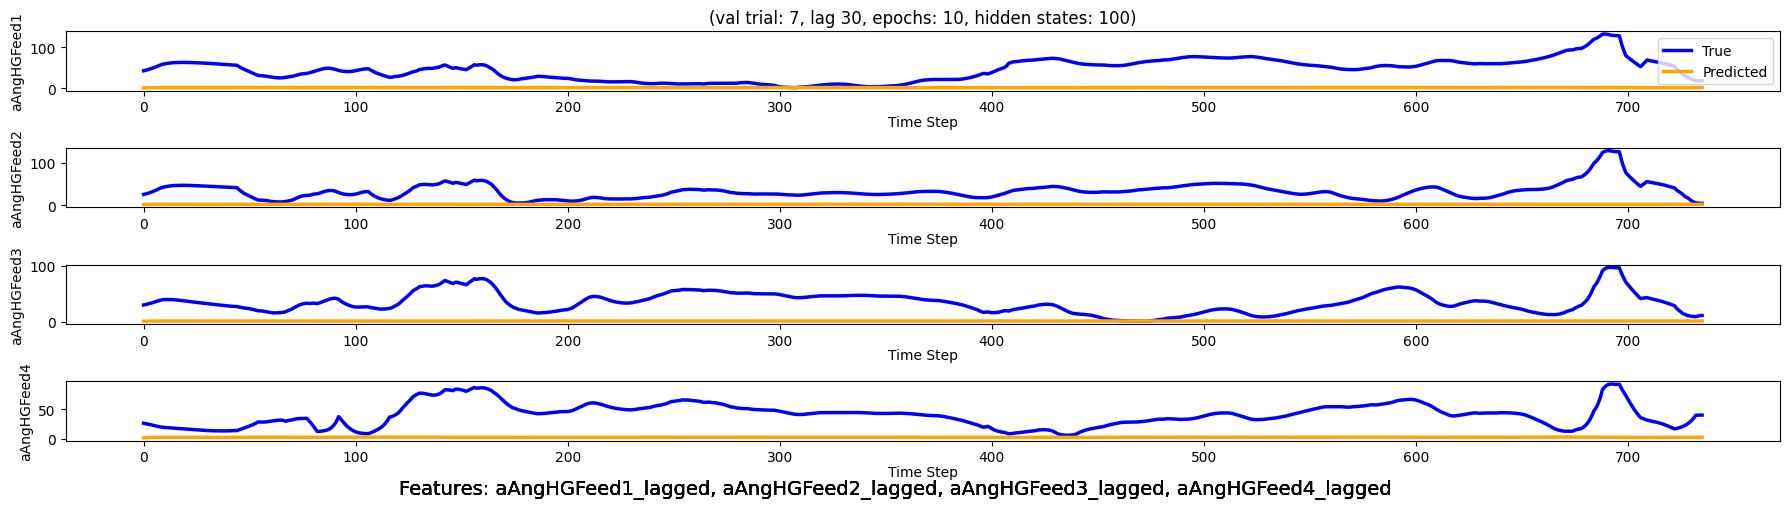

Epoch 0, train loss: 0.0003589453117456287, val loss: 0.004197097849100828
Epoch 100, train loss: 1.4409572031581774e-05, val loss: 0.00015579235332552344
Epoch 200, train loss: 1.420766693627229e-05, val loss: 0.00015377969248220325
Epoch 300, train loss: 1.311029427597532e-05, val loss: 0.00014091221964918077
Epoch 400, train loss: 8.940664883994032e-06, val loss: 9.171356941806152e-05
Epoch 500, train loss: 7.997365173650905e-06, val loss: 8.332345896633342e-05
Epoch 600, train loss: 7.104204996721819e-06, val loss: 7.977763016242534e-05


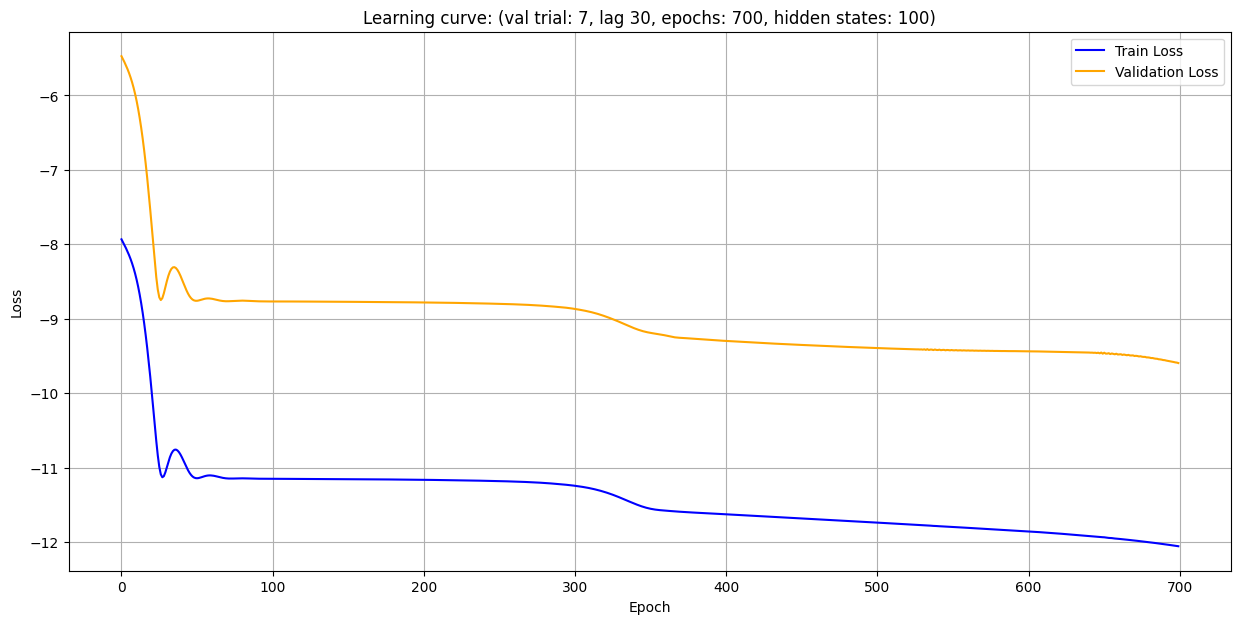

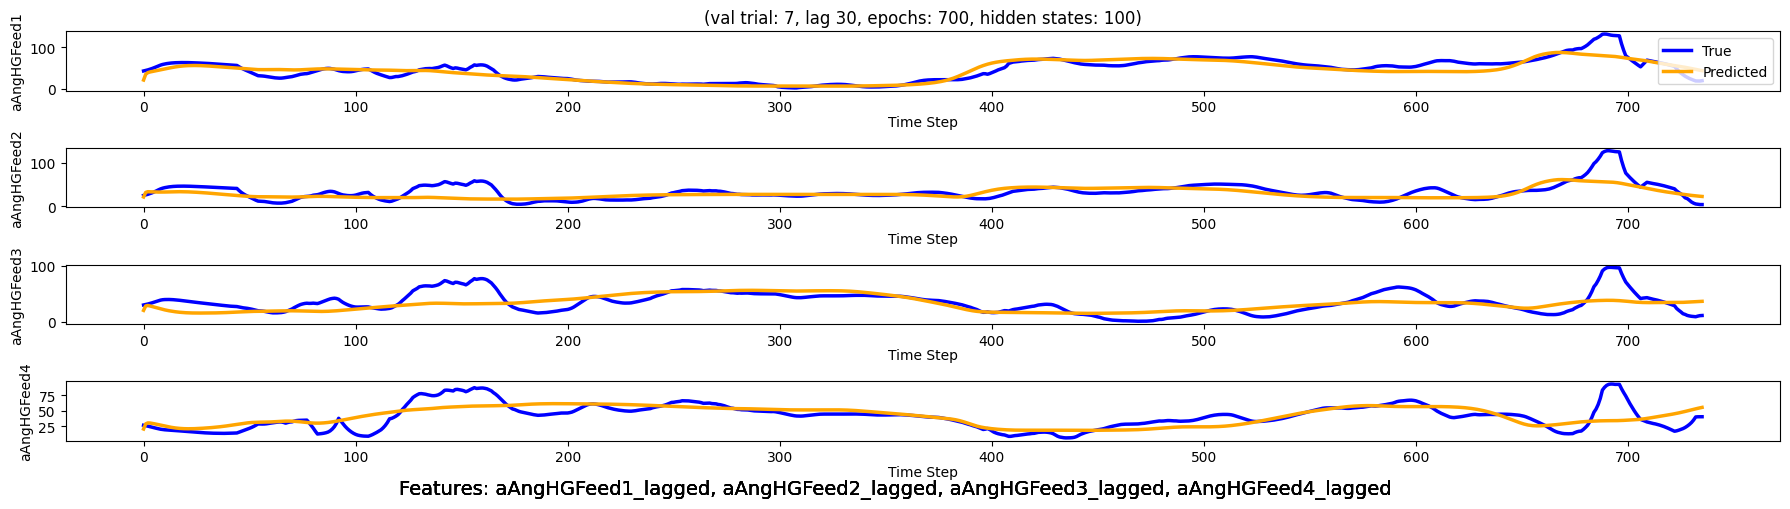

Epoch 0, train loss: 0.0003514584677759558, val loss: 0.004132919479161501
Epoch 100, train loss: 1.4426629604713526e-05, val loss: 0.00015659564814995974
Epoch 200, train loss: 1.4308762729342561e-05, val loss: 0.00015518120198976249
Epoch 300, train loss: 1.3589184163720347e-05, val loss: 0.00014707706577610224
Epoch 400, train loss: 9.208427400153596e-06, val loss: 9.741487156134099e-05
Epoch 500, train loss: 8.479674761474598e-06, val loss: 8.818461355986074e-05
Epoch 600, train loss: 7.826118235243484e-06, val loss: 8.428283763350919e-05
Epoch 700, train loss: 7.215076493594097e-06, val loss: 8.332639117725194e-05
Epoch 800, train loss: 6.397563993232325e-06, val loss: 7.593785994686186e-05
Epoch 900, train loss: 4.905826244794298e-06, val loss: 5.273496208246797e-05


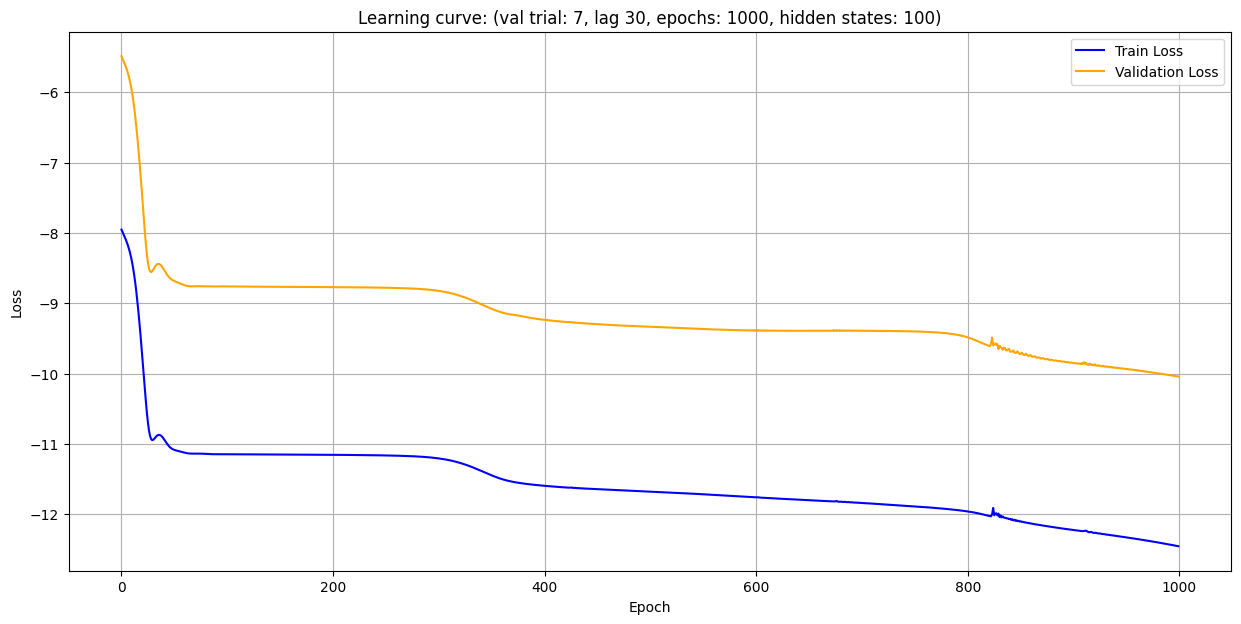

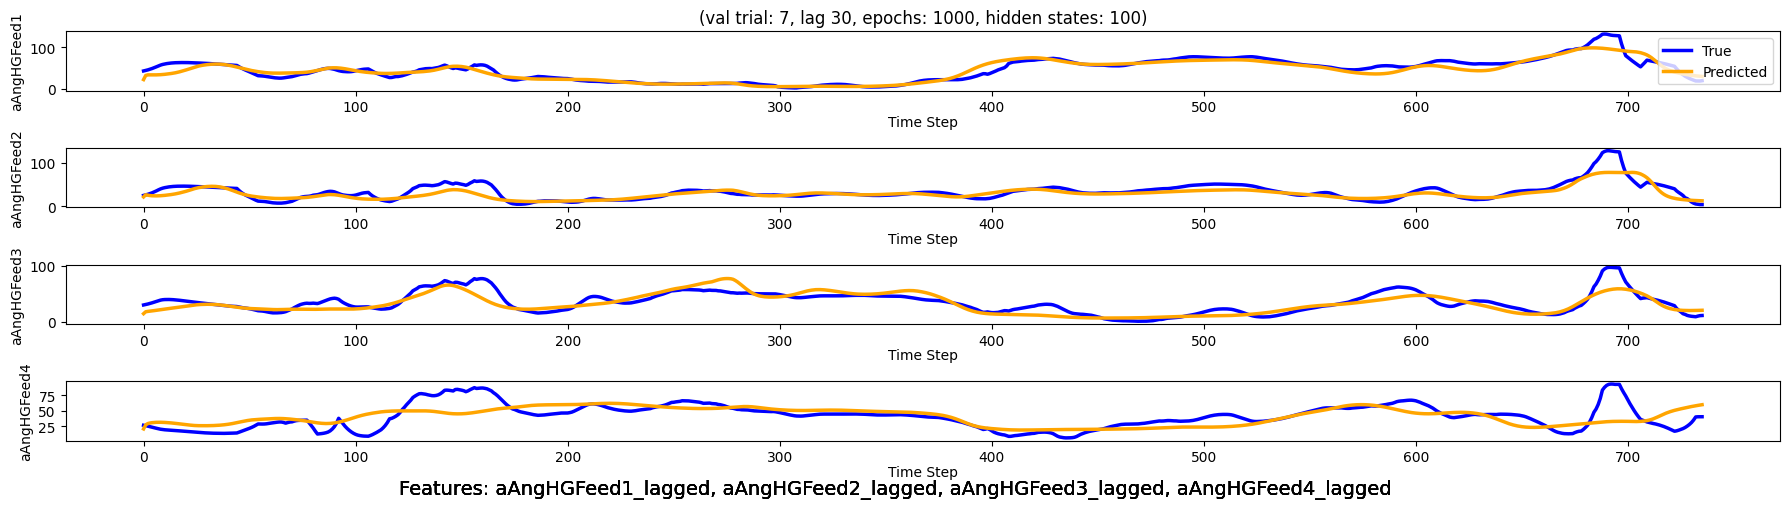

Epoch 0, train loss: 0.000348139728885144, val loss: 0.003995309583842754


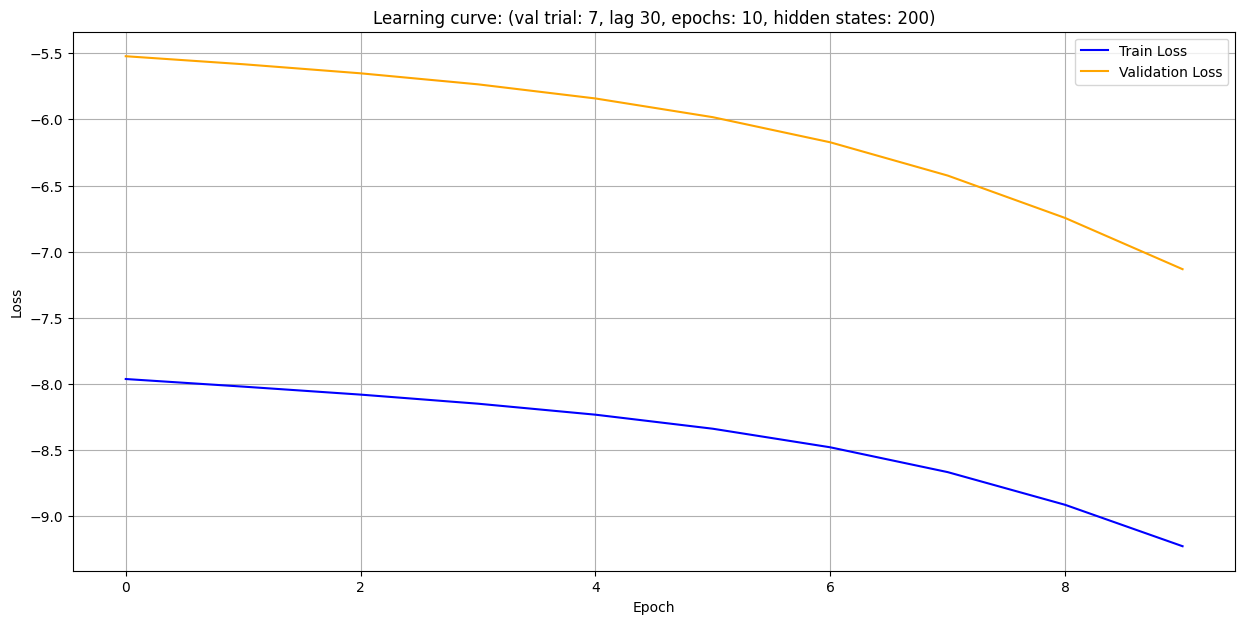

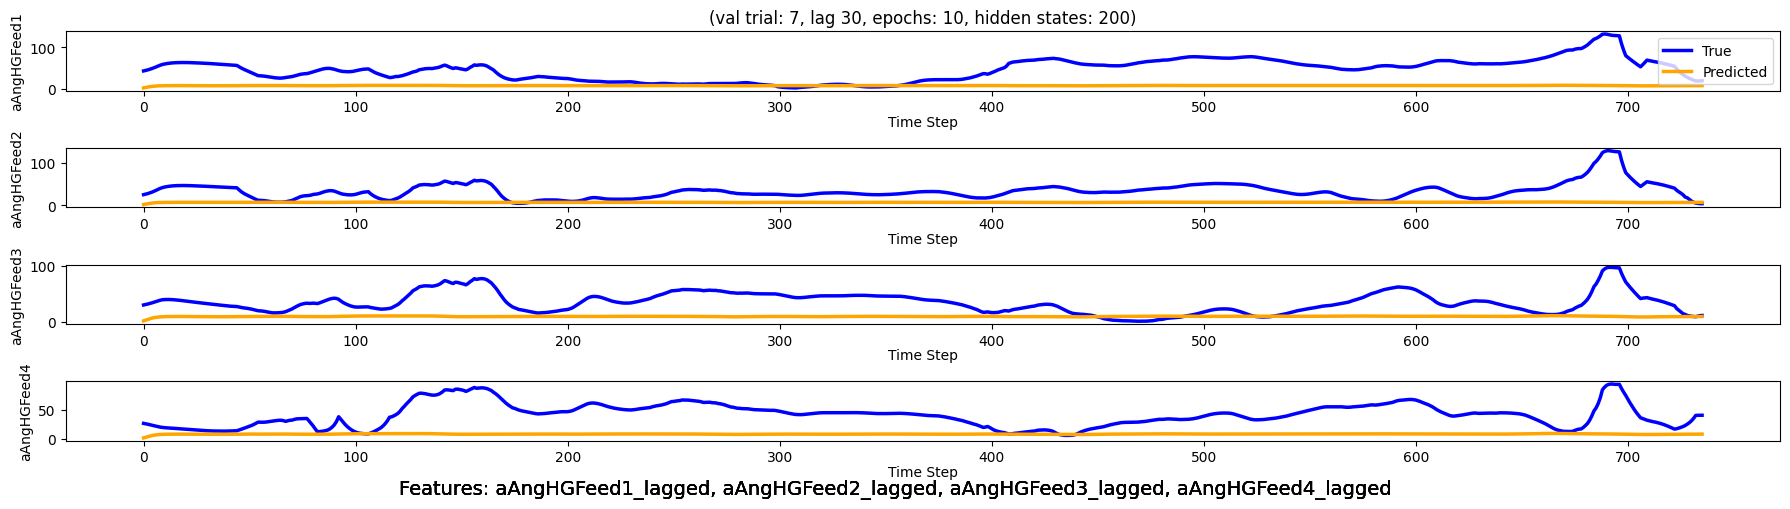

Epoch 0, train loss: 0.00034443510230630636, val loss: 0.003919735085219145
Epoch 100, train loss: 1.4364752132678404e-05, val loss: 0.00015568769595120102
Epoch 200, train loss: 1.3609596862806939e-05, val loss: 0.00014613526582252234
Epoch 300, train loss: 8.631824130134191e-06, val loss: 9.175175364362076e-05
Epoch 400, train loss: 7.678831934754271e-06, val loss: 8.36392937344499e-05


KeyboardInterrupt: 

In [397]:
hidden_values = [100,200,300]
epoch_values = [10,700,1000]
val_values = [7]

for h in hidden_values:
    for e in epoch_values:
        for v in val_values:
            hidden_size= h
            n_epochs = e
            set_value = v
            labels = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
            columns_to_shift = ['aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
            batch_size = 13
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size)
            readout = GRUDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss2(loss)
            data = 'data_model_v1.csv'
            shift = 30
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]

            # Step 1: Find the minimum length of all trials
            #trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
            #min_length = trial_lengths.min()            # Find the shortest sequence length

            # Step 2: Cut all trials to the length of the shortest sequence
            #df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


            train_set = shifted_df[(shifted_df['trial'] != set_value)]
            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)

            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)


            train_losses, val_losses, yPred_tr, yPred_val = run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None, device=None, verbose=True)
            # Create a figure for the learning curve
            fig, ax = plt.subplots(figsize=(15, 7))  # Adjust size if necessary

            # Plot both Train and Validation Loss on the same axis
            ax.plot(np.log(train_losses), label='Train Loss', color='blue')
            ax.plot(np.log(val_losses), label='Validation Loss', color='orange')

            # Set title, labels, and legend
            ax.set_title((f'Learning curve: (val trial: {set_value}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend(loc='upper right')
            ax.grid()

            # Save the learning curve plot
            plot_name = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}_LC.png'
            lc_dir = os.path.join(save_dir, plot_name)
            plt.savefig(lc_dir)
            plt.show()

            # Second subplot - Validation Prediction vs True Values
            # Assuming yPred_val is a list of length 1
            y_val_pred_np = yPred_val[0].detach().cpu().numpy()  # Extract first element and convert to numpy

            # Collect true values from validation dataset
            y_val_true_np = []

            # Iterate through the validation dataloader to gather true values
            for X_batch, y_batch in val_dataloader:
                # Assuming y_batch is a list of length 1
                y_val_true_np.append(y_batch[0].numpy())  # Extract first element and convert to numpy

            # Flatten the list of arrays into a single array
            y_val_true_np = np.concatenate(y_val_true_np, axis=0)

            # Create a line plot comparing predictions vs true values
            plot_filename = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
            plot_dir = os.path.join(save_dir, plot_filename)

            # Ensure that you are plotting the correct values, applying exp if needed
            create_lineplots(np.exp(y_val_pred_np), np.exp(y_val_true_np), labels, trial=set_value, 
                            shift=shift, n_epochs=n_epochs, hidden_size=hidden_size, 
                            file_path=plot_dir,features=features, size=(18, 5))

In [399]:
df.columns

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4'],
      dtype='object')

In [85]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(val trial: {trial}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()

# Correlations

In [419]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalize Head gaze and Distance arrays
HG_np_scaled = np.array([min_max_scaling(HG_np[:, i]) for i in range(HG_np.shape[1])]).T

In [427]:
df[df['trial']==2][HG]

aAngHGFeed1  aAngHGFeed2  aAngHGFeed3  aAngHGFeed4
161     3.972882     3.679684     3.534265     3.019513
162     3.995627     3.707283     3.562454     3.034809
163     3.997371     3.713895     3.565077     3.058552
164     3.995171     3.714780     3.561293     3.071056
165     3.994753     3.715797     3.558252     3.072517
..           ...          ...          ...          ...
893     4.716152     4.751058     4.581637     4.600686
894     4.713718     4.748167     4.579714     4.598951
895     3.959232     3.864458     4.008645     4.011616
896     3.977419     3.882005     4.028216     4.027673
897     3.965875     3.867181     4.015468     4.014625

[737 rows x 4 columns]

In [ ]:
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_lagged'
        trial_df[new_col_name] = trial_df[col].shift(-shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

In [465]:
df.columns

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4'],
      dtype='object')

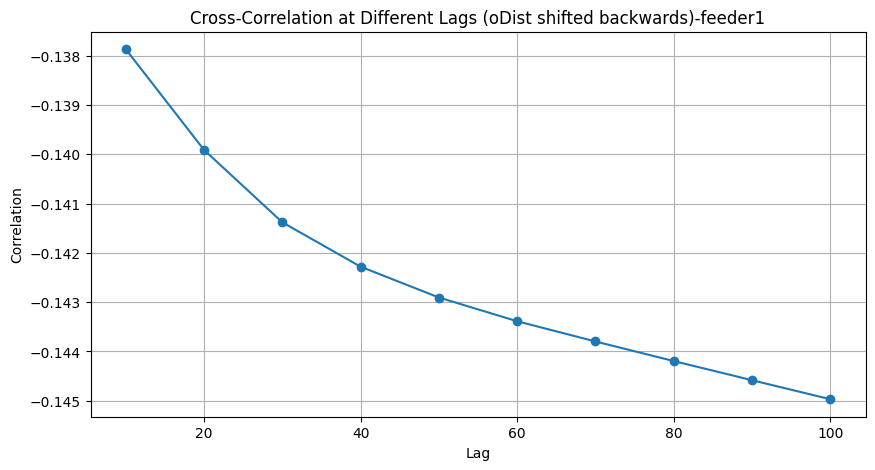

Optimal lag for feeder 1: 10
Maximum correlation for feeder1: -0.13786681364376943


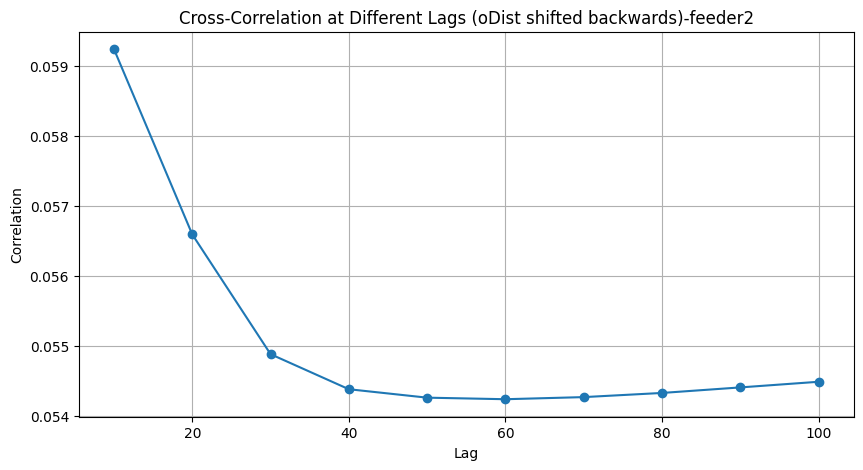

Optimal lag for feeder 2: 10
Maximum correlation for feeder2: 0.0592397222282998


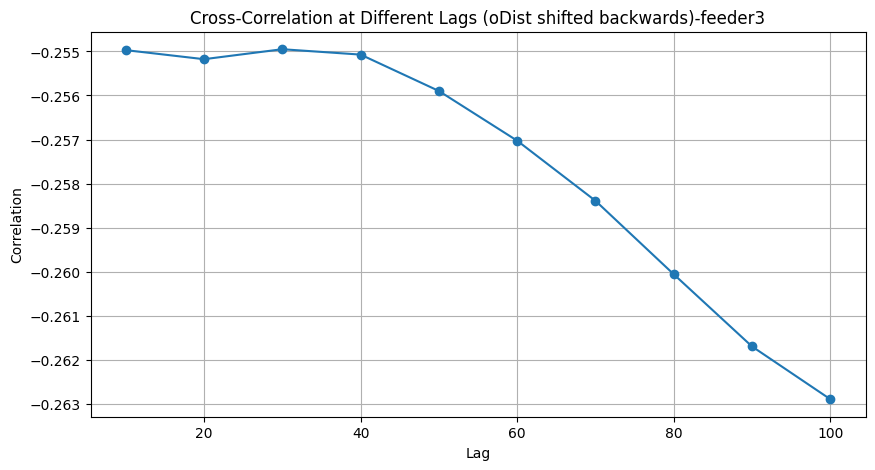

Optimal lag for feeder 3: 30
Maximum correlation for feeder3: -0.2549500940431604


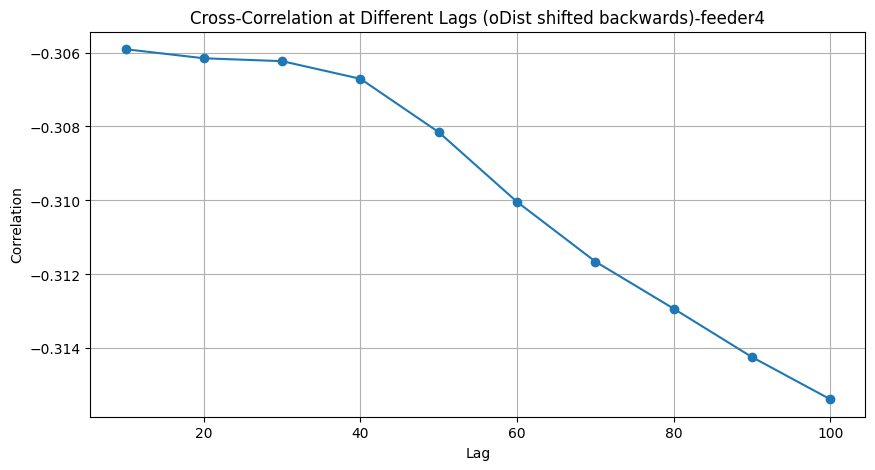

Optimal lag for feeder 4: 10
Maximum correlation for feeder4: -0.3059107313362921


In [467]:
oDist = ['oDistReach1','oDistReach2', 'oDistReach3', 'oDistReach4']
aDist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']
df[HG[0]].to_numpy()
for i in np.arange(4):
    # Example time series (replace these with your actual data)
    time_series_1 = df[aDist[i]].to_numpy()
    time_series_2 = df[oDist[i]].to_numpy()

    # Define the lag intervals you want to check (from 10 to 100 in intervals of 10)
    lags = range(10, 101, 10)

    # Compute cross-correlation for the defined lags
    correlations = []
    for lag in lags:
        # Shift time_series_2 backwards by the current lag
        shifted_series = np.roll(time_series_2, -lag)
        
        # Calculate the correlation using the valid portion of the arrays
        if lag < len(time_series_1):
            corr = np.corrcoef(time_series_1[lag:], shifted_series[:-lag])[0, 1]
        else:
            corr = np.nan  # Not enough data to compute correlation
        
        correlations.append(corr)

    # Plot cross-correlation vs lag
    plt.figure(figsize=(10, 5))
    plt.plot(lags, correlations, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title(f'Cross-Correlation at Different Lags (oDist shifted backwards)-feeder{i+1}')
    plt.grid(True)
    plt.show()

    # Identify the lag with the maximum correlation
    optimal_lag = lags[np.nanargmax(correlations)]  # Use nanargmax to avoid NaN values
    max_correlation = max(correlations)

    print(f"Optimal lag for feeder {i+1}: {optimal_lag}")
    print(f"Maximum correlation for feeder{i+1}: {max_correlation}")

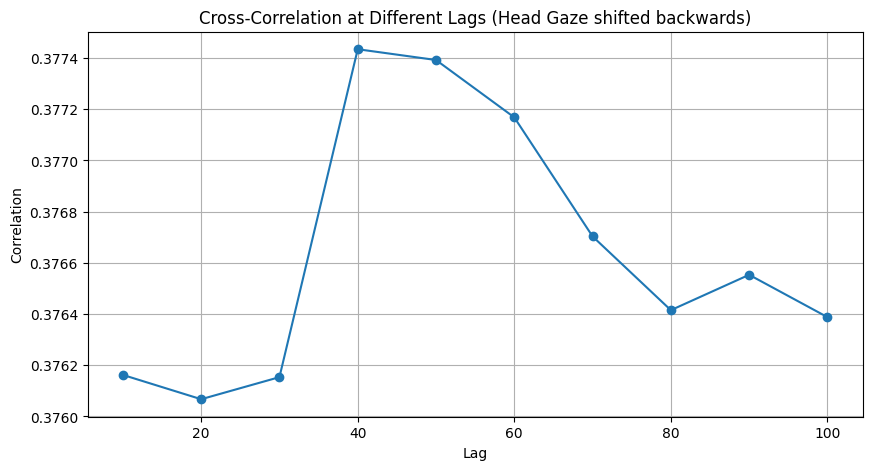

Optimal lag for feeder 1: 40
Maximum correlation for feeder1: 0.3774345335318421


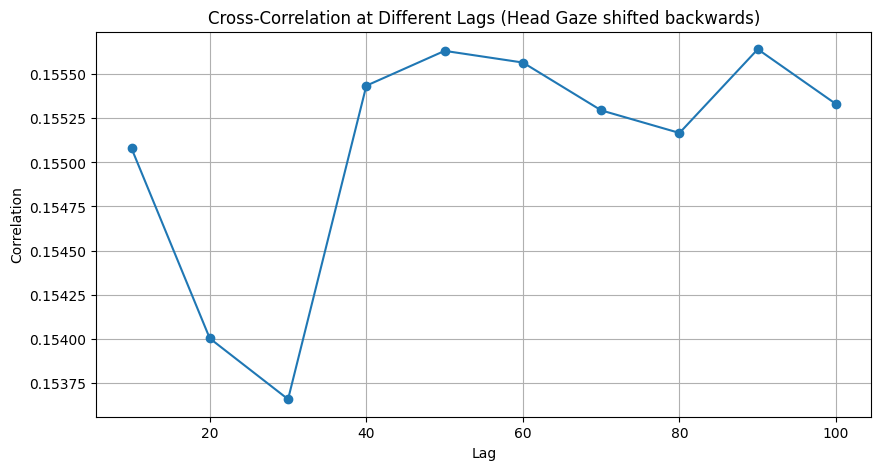

Optimal lag for feeder 2: 90
Maximum correlation for feeder2: 0.15564210900083664


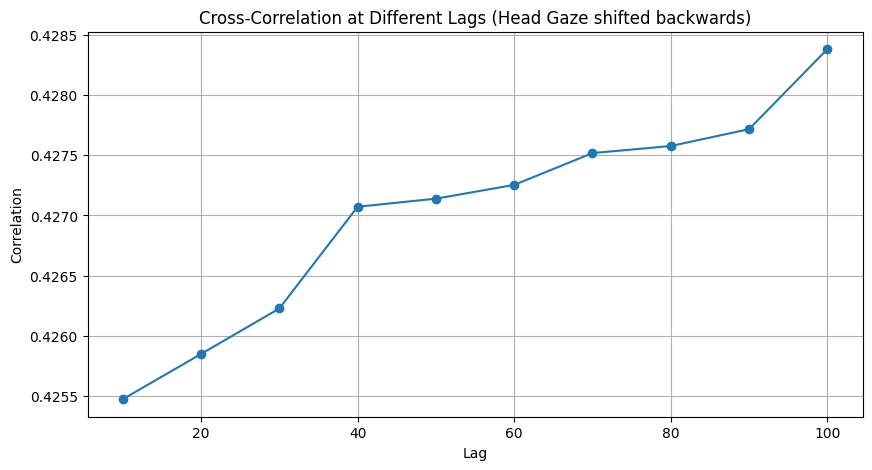

Optimal lag for feeder 3: 100
Maximum correlation for feeder3: 0.4283799066369245


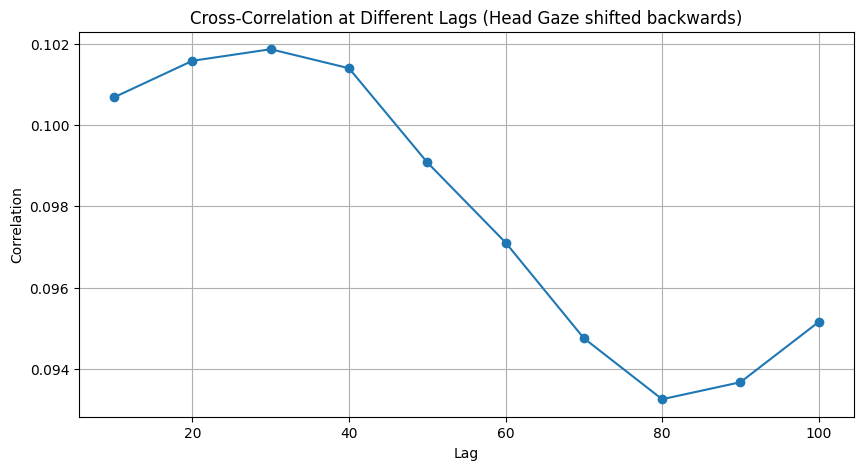

Optimal lag for feeder 4: 30
Maximum correlation for feeder4: 0.10186203269318984


In [454]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']
df[HG[0]].to_numpy()
for i in np.arange(4):
    # Example time series (replace these with your actual data)
    time_series_1 = df[Dist[i]].to_numpy()
    time_series_2 = df[HG[i]].to_numpy()

    # Define the lag intervals you want to check (from 10 to 100 in intervals of 10)
    lags = range(10, 101, 10)

    # Compute cross-correlation for the defined lags
    correlations = []
    for lag in lags:
        # Shift time_series_2 backwards by the current lag
        shifted_series = np.roll(time_series_2, -lag)
        
        # Calculate the correlation using the valid portion of the arrays
        if lag < len(time_series_1):
            corr = np.corrcoef(time_series_1[lag:], shifted_series[:-lag])[0, 1]
        else:
            corr = np.nan  # Not enough data to compute correlation
        
        correlations.append(corr)

    # Plot cross-correlation vs lag
    plt.figure(figsize=(10, 5))
    plt.plot(lags, correlations, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation at Different Lags (Head Gaze shifted backwards)')
    plt.grid(True)
    plt.show()

    # Identify the lag with the maximum correlation
    optimal_lag = lags[np.nanargmax(correlations)]  # Use nanargmax to avoid NaN values
    max_correlation = max(correlations)

    print(f"Optimal lag for feeder {i+1}: {optimal_lag}")
    print(f"Maximum correlation for feeder{i+1}: {max_correlation}")

In [468]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']
df[HG[0]].to_numpy()
for i in np.arange(4):
    # Example time series (replace these with your actual data)
    time_series_1 = df[Dist[i]].to_numpy()
    time_series_2 = df[HG[i]].to_numpy()
    # Shift time_series_2 backwards by the current lag
    shifted_series[i] = np.roll(time_series_2[i], -50)

In [472]:
len(df)

7576

In [455]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']
df[HG[0]].to_numpy()
for i in np.arange(4):
    # Example time series (replace these with your actual data)
    time_series_1 = df[Dist[i]].to_numpy()
    time_series_2 = df[HG[i]].to_numpy()
    # Shift time_series_2 backwards by the current lag
    shifted_series[i] = np.roll(time_series_2[i], -50)
    
    
for j in np.arange(2,16):
    df_tr = df[df['trial']==j]
    HG_np = df_tr[HG].to_numpy()
    HG_np_scaled = np.array([min_max_scaling(HG_np[:, k]) for k in range(HG_np.shape[1])]).T
    Dist_np = df_tr[Dist].to_numpy()


    fig, axs = plt.subplots(4, 1, figsize=(20,10), linewidth=0.01)  
    for i in np.arange(4):
        ax = axs[i]
        ax.plot(HG_np_scaled[:, i], label='Head gaze', linewidth=1.5, color='blue')  # True values in blue
        ax.plot(Dist_np[:, i], label='Dist', linewidth=1.5, color='orange')  # Predicted values in orange
        ax.set_ylabel(f'feeder {i+1}')

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'[A]Head gaze vs [A]Distance to feeders - trial{j}')
            ax.legend()
        
        #ax.set_xlabel('Time Step',labelpad=0.5)
    plt.savefig(f'HGvsDist_trial_{j}.png')
    plt.show()

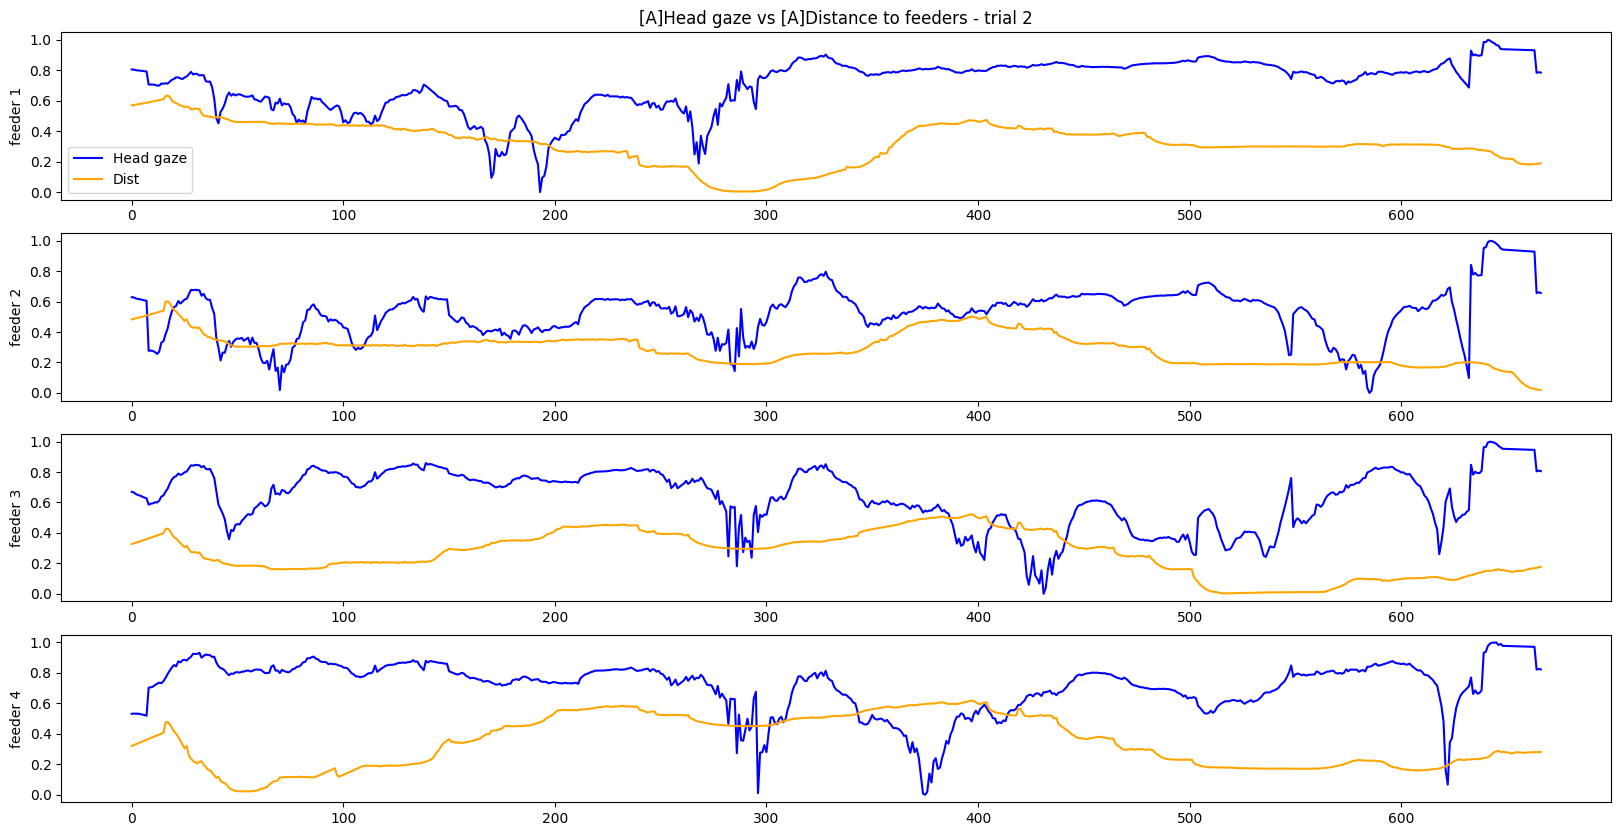

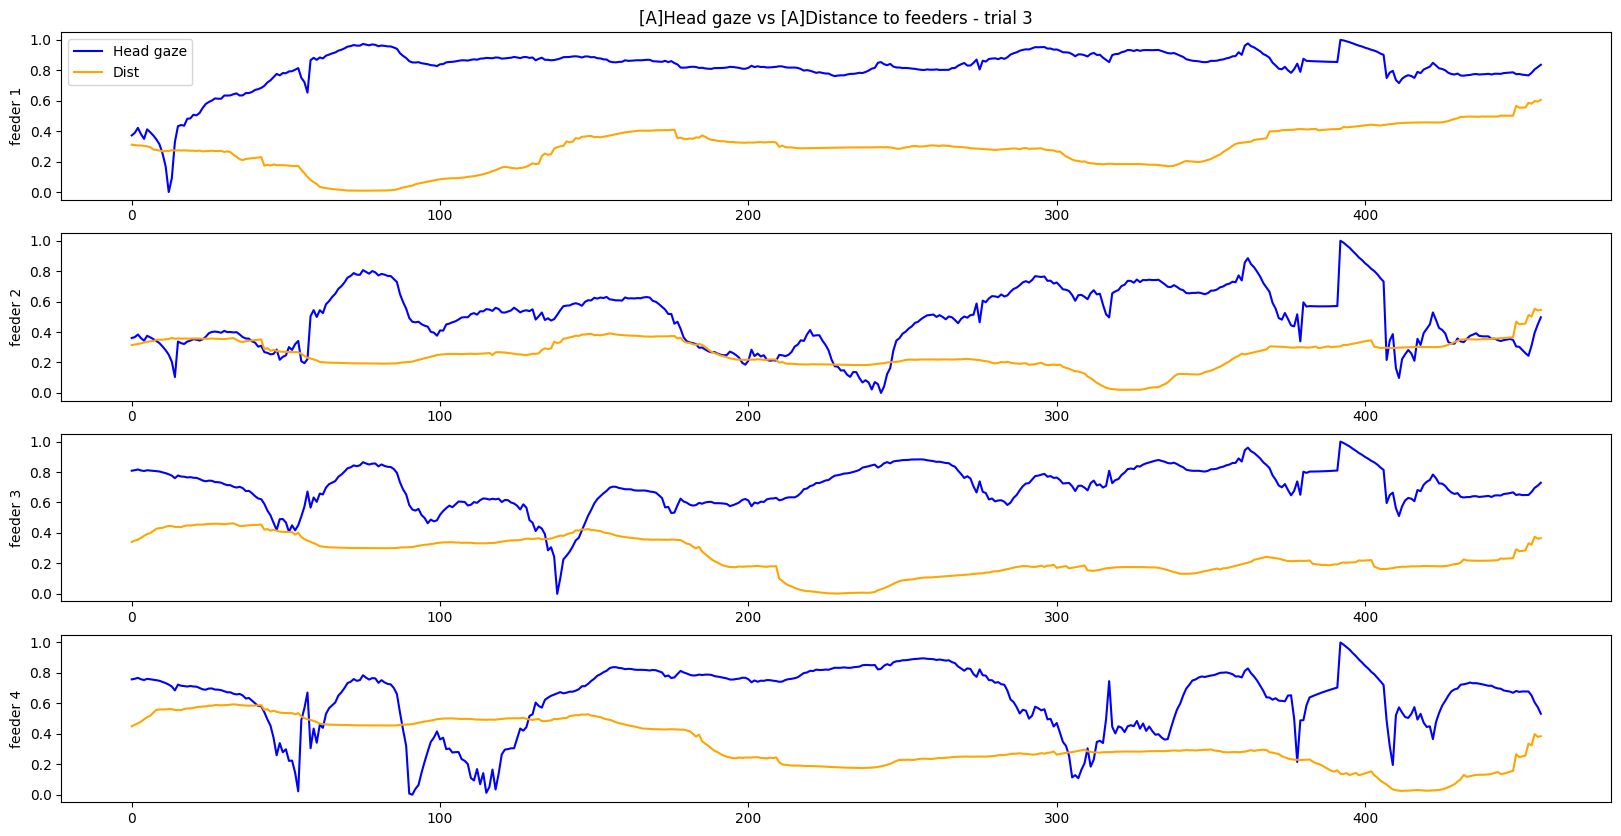

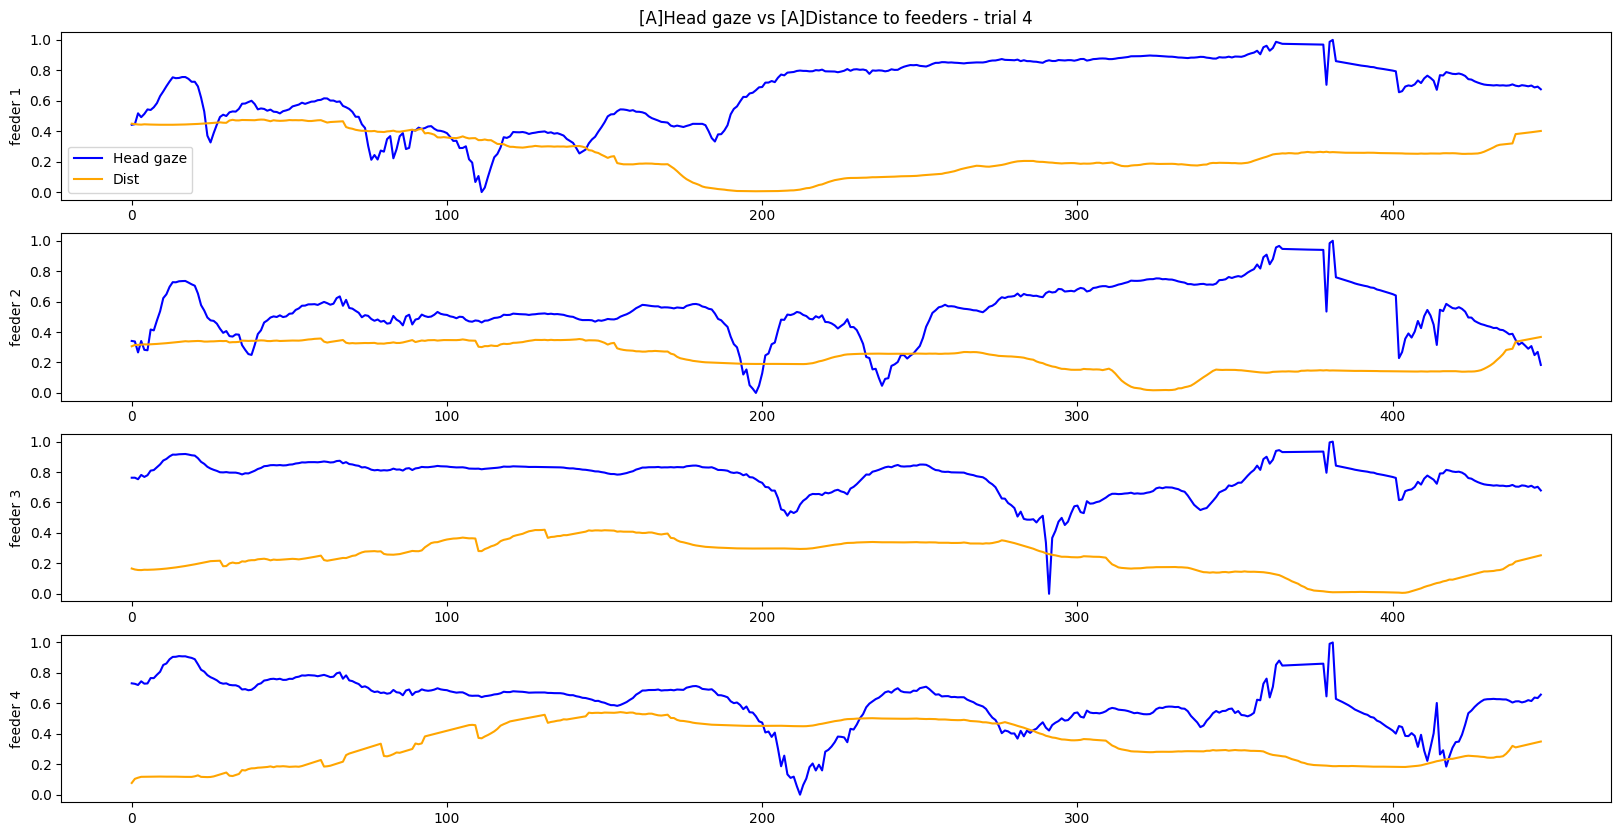

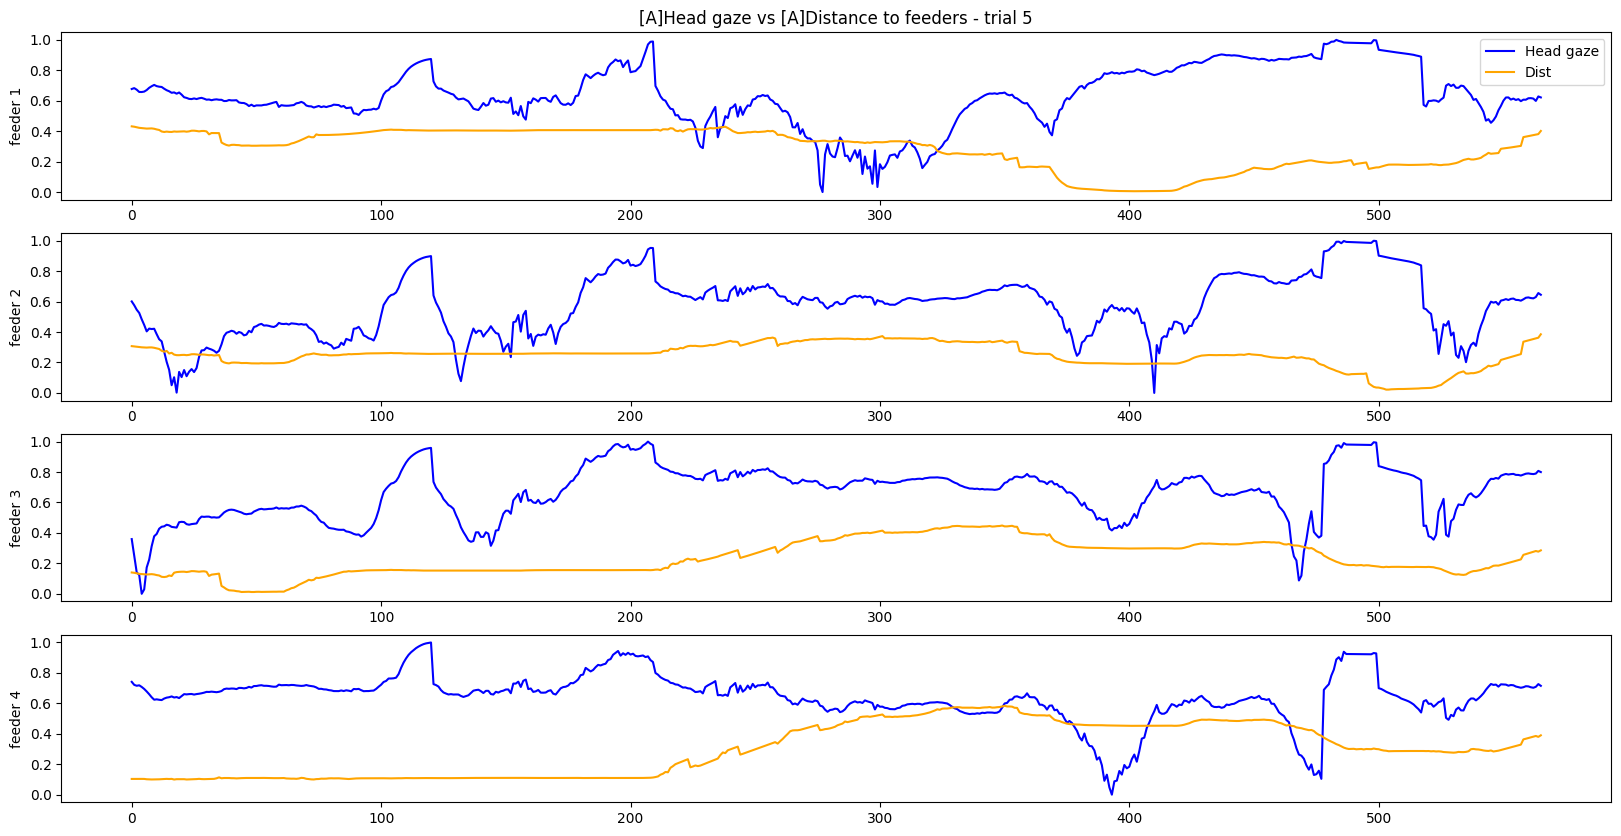

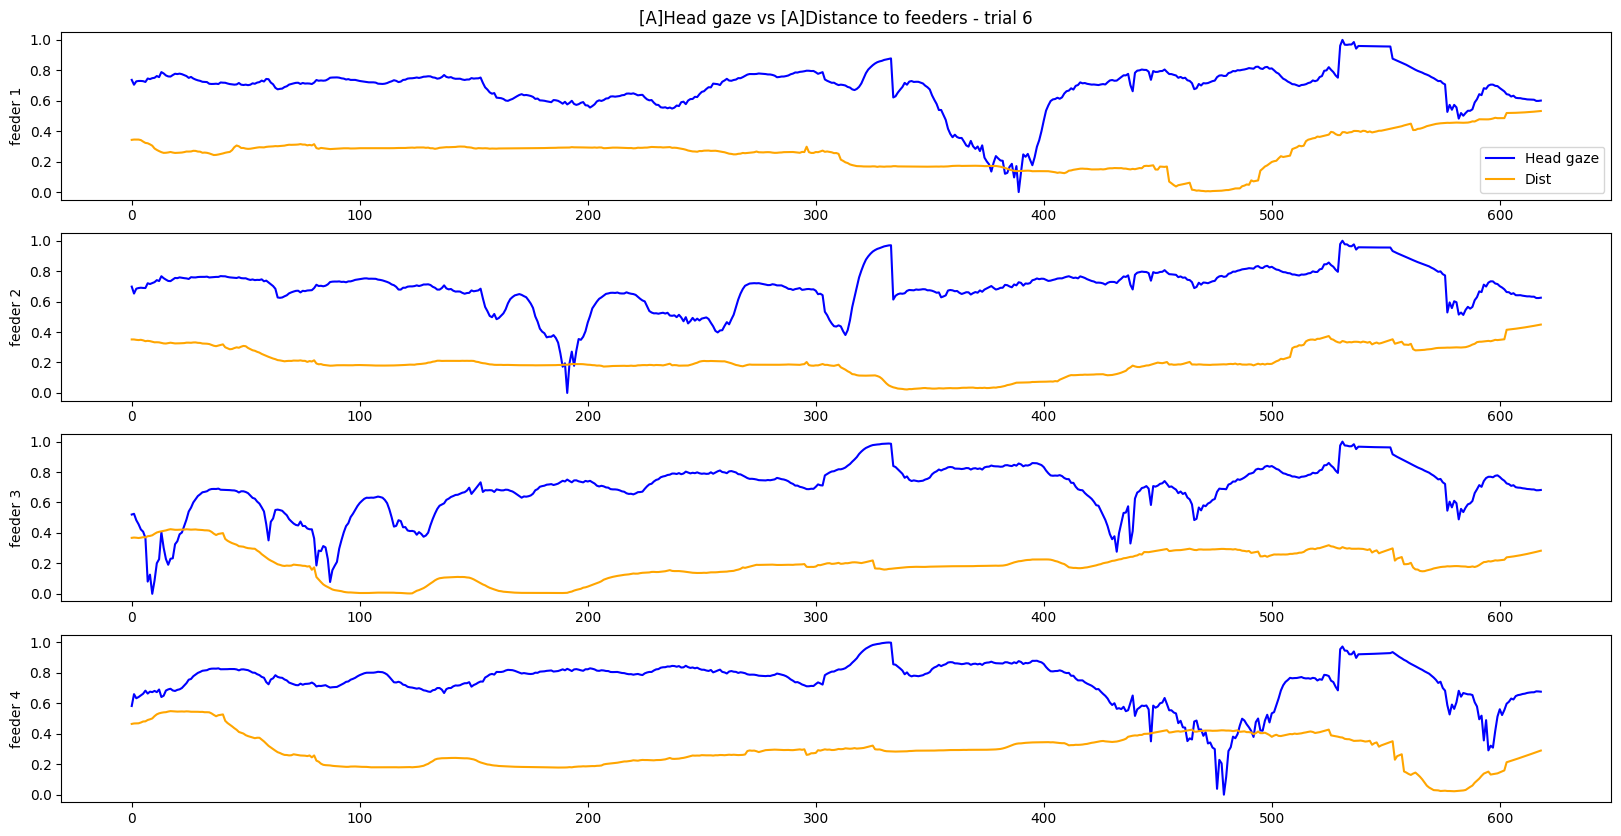

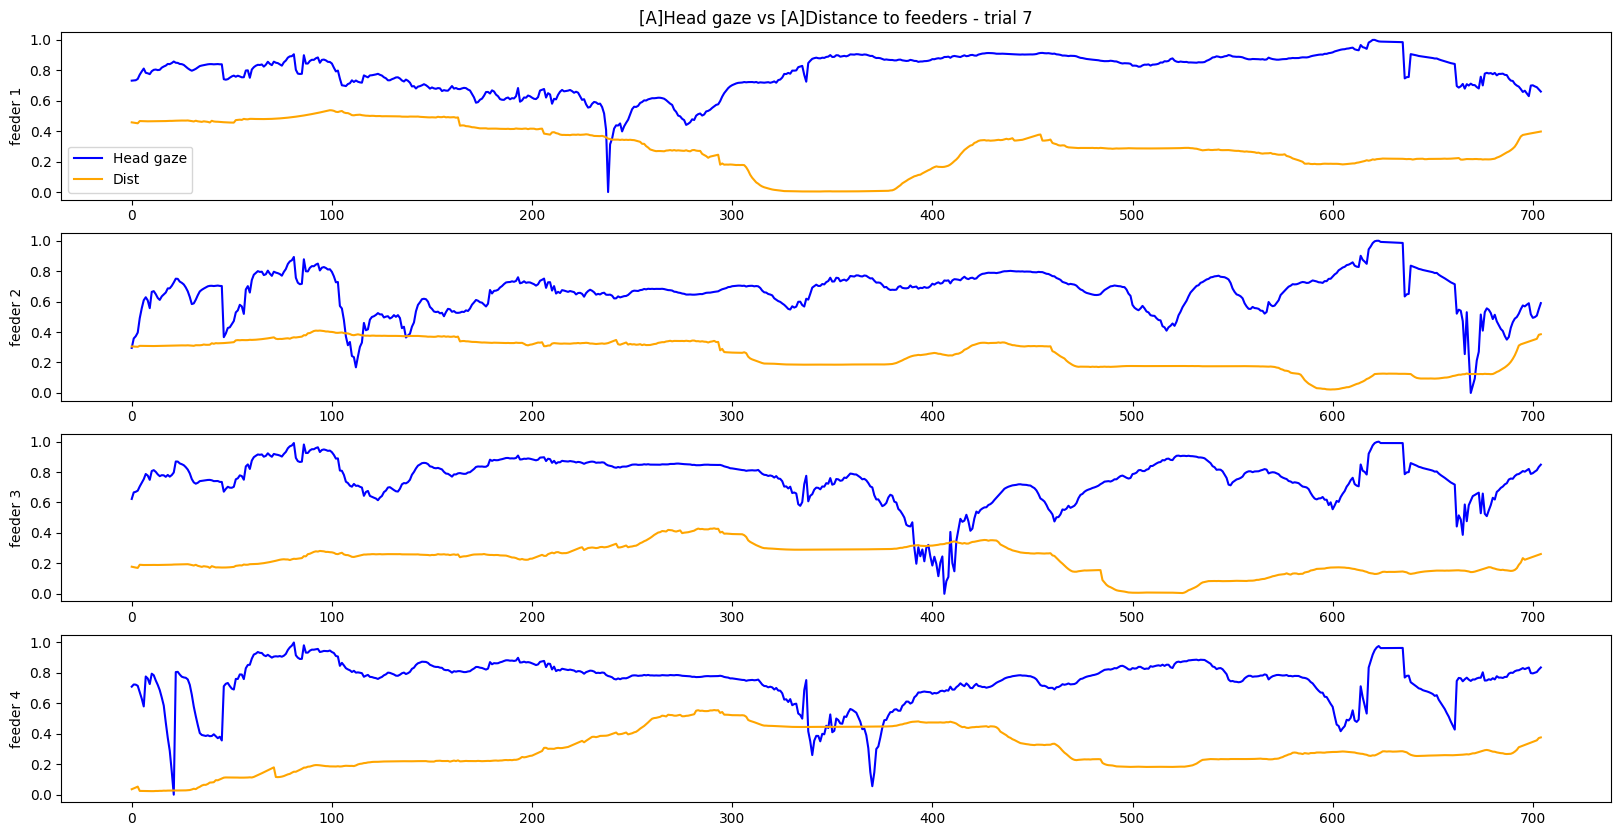

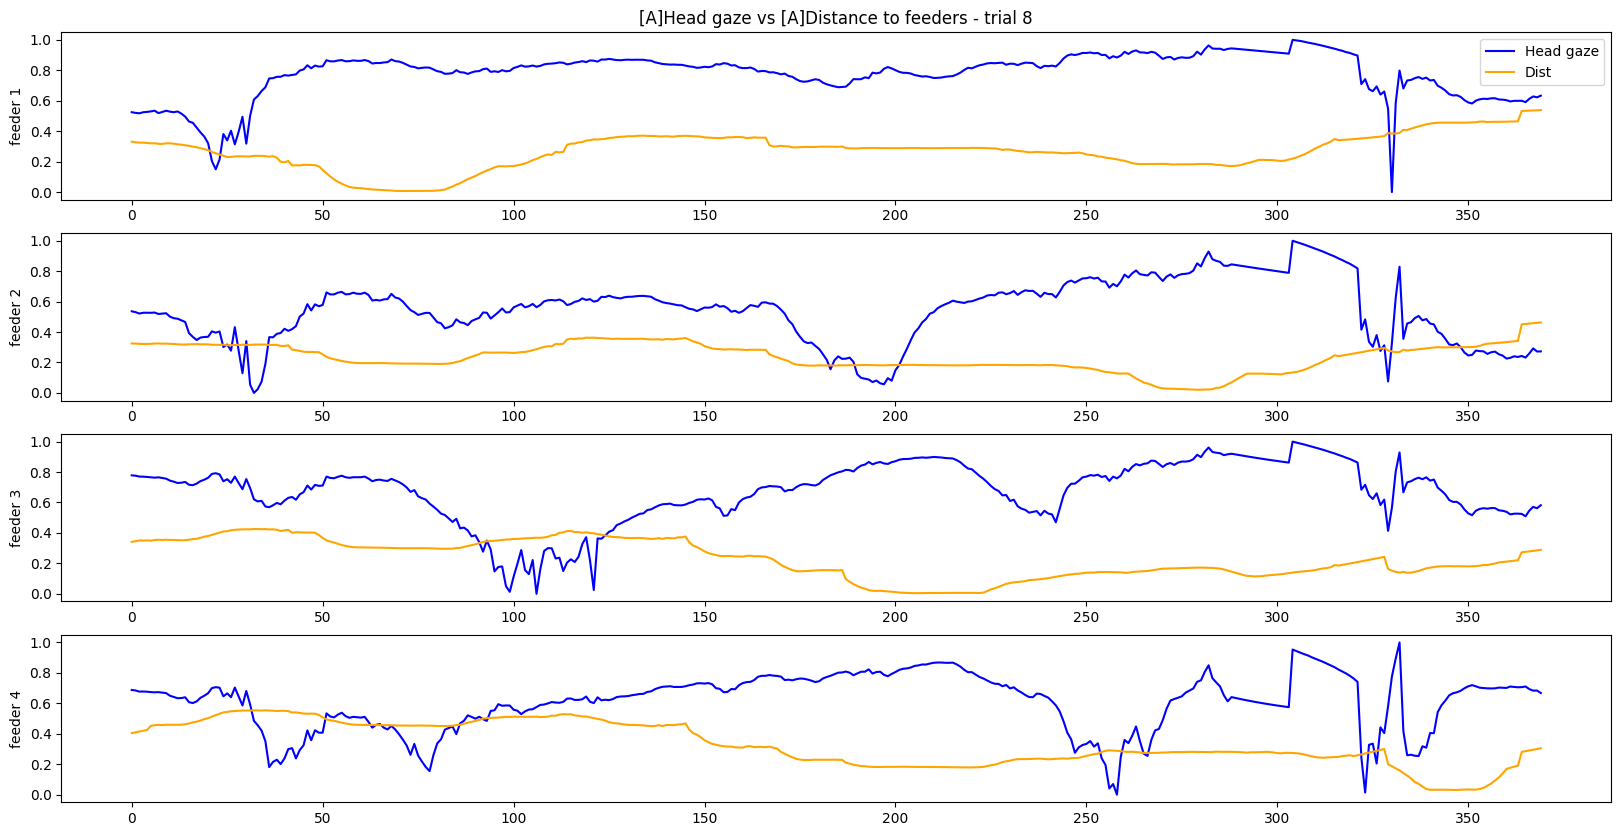

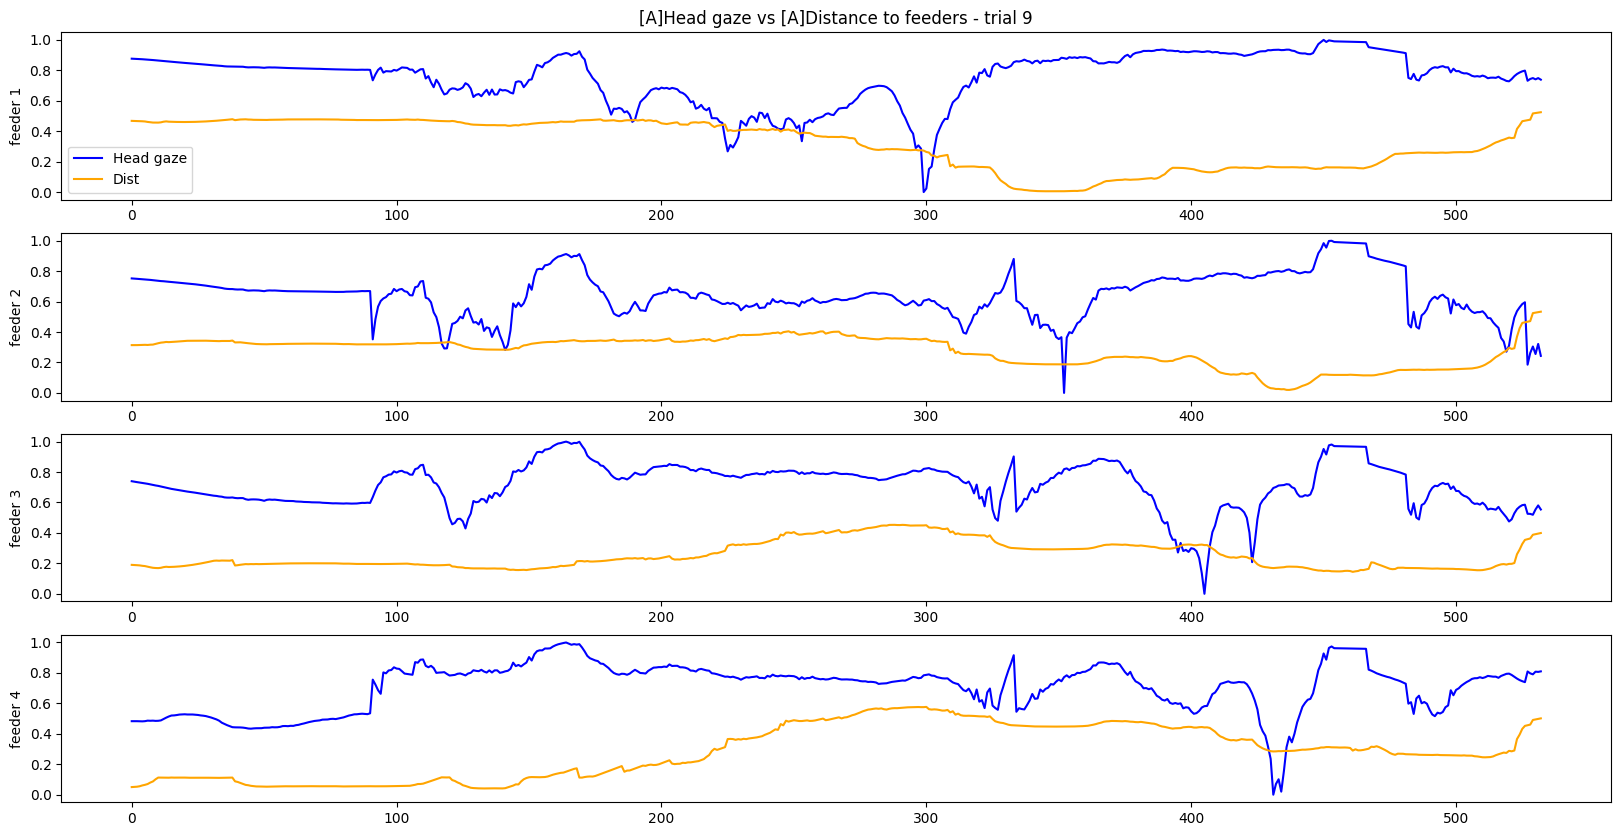

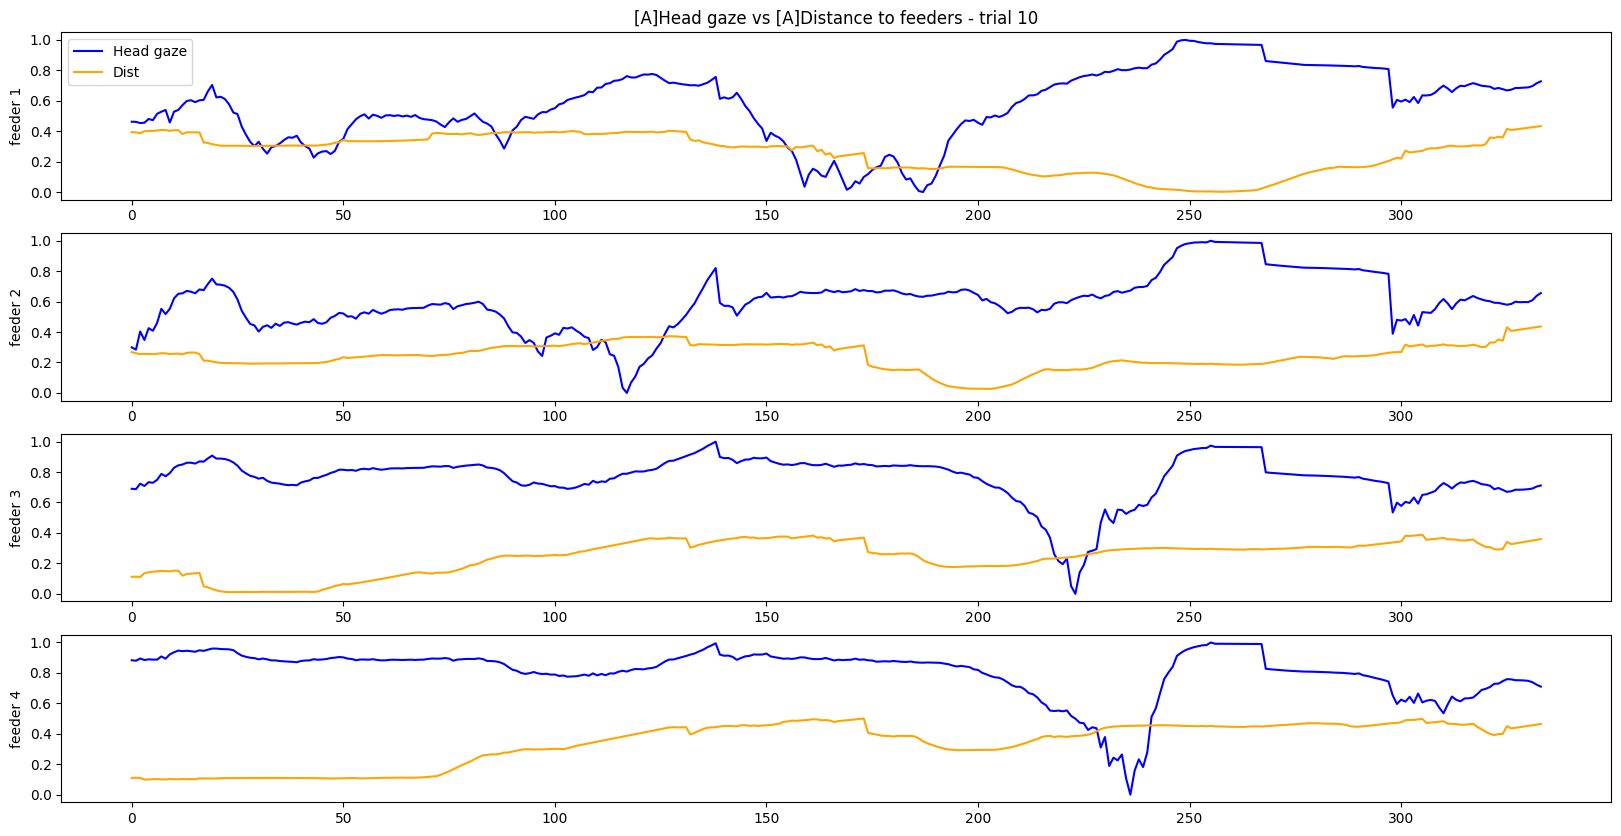

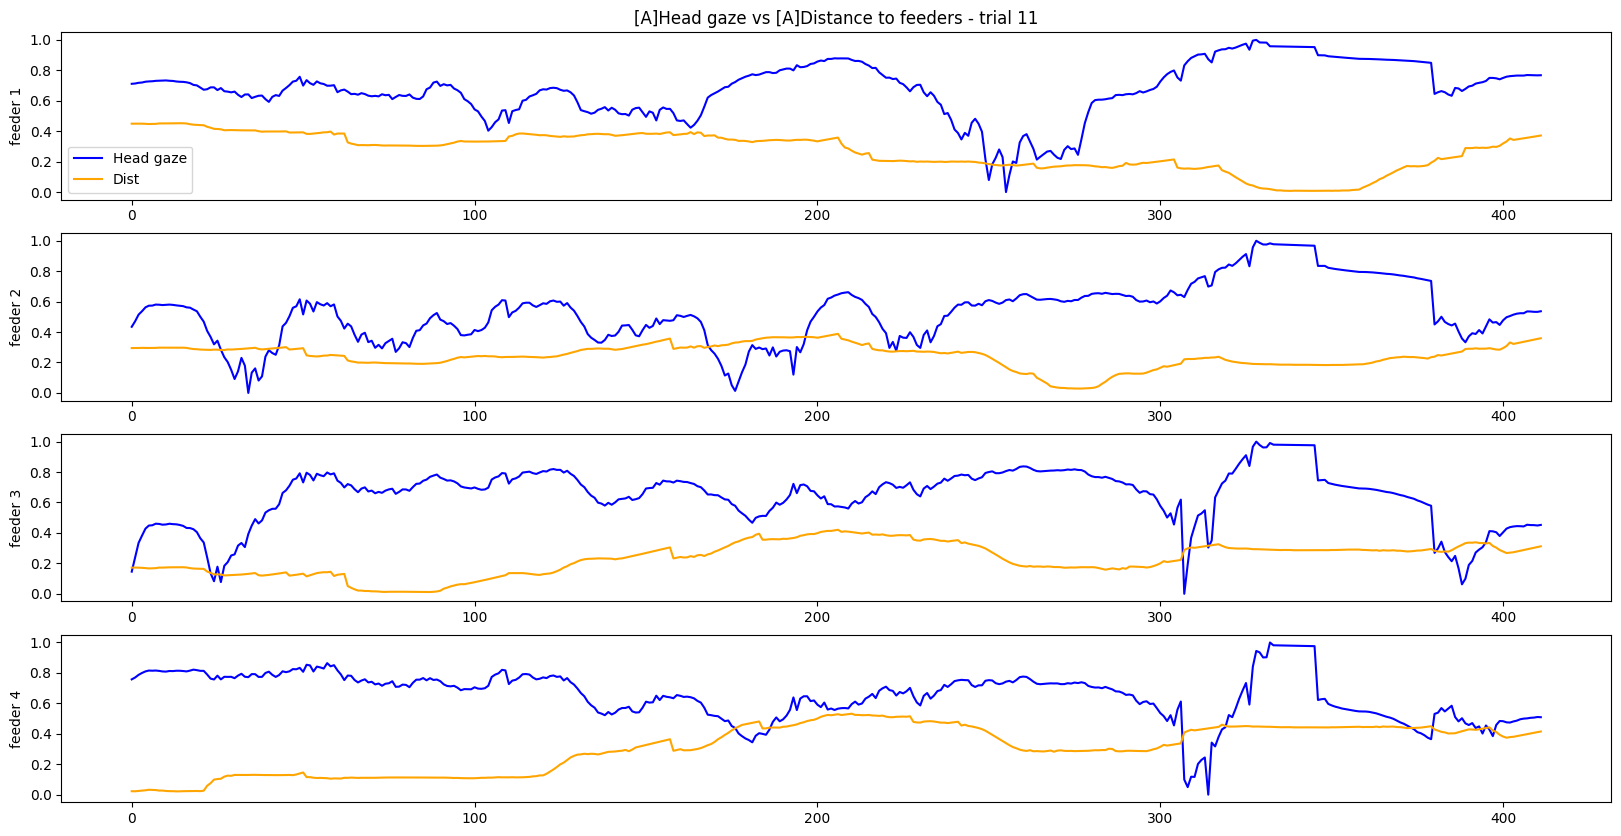

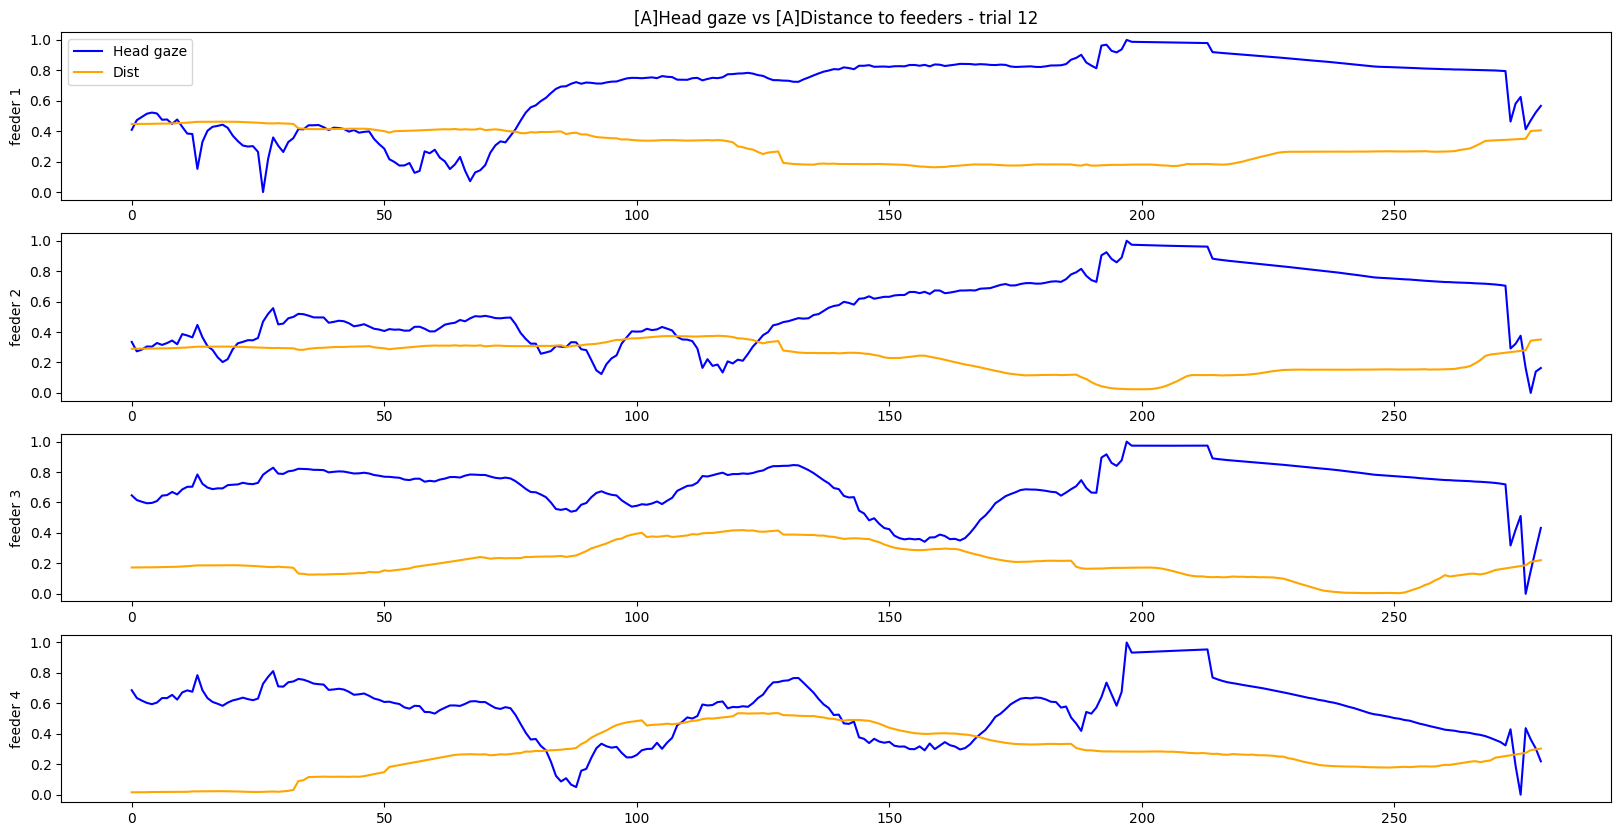

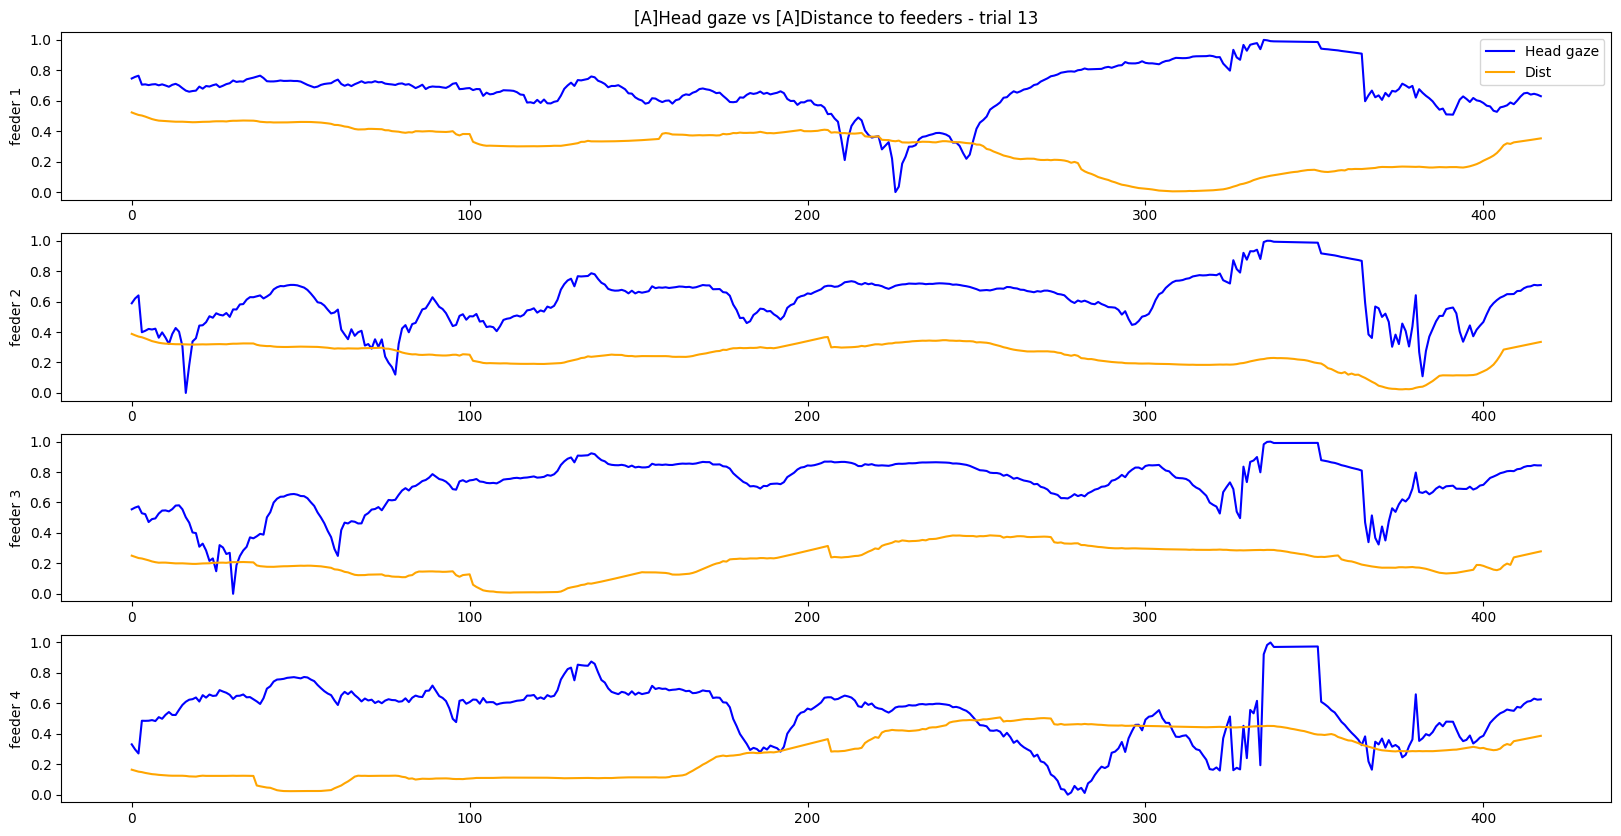

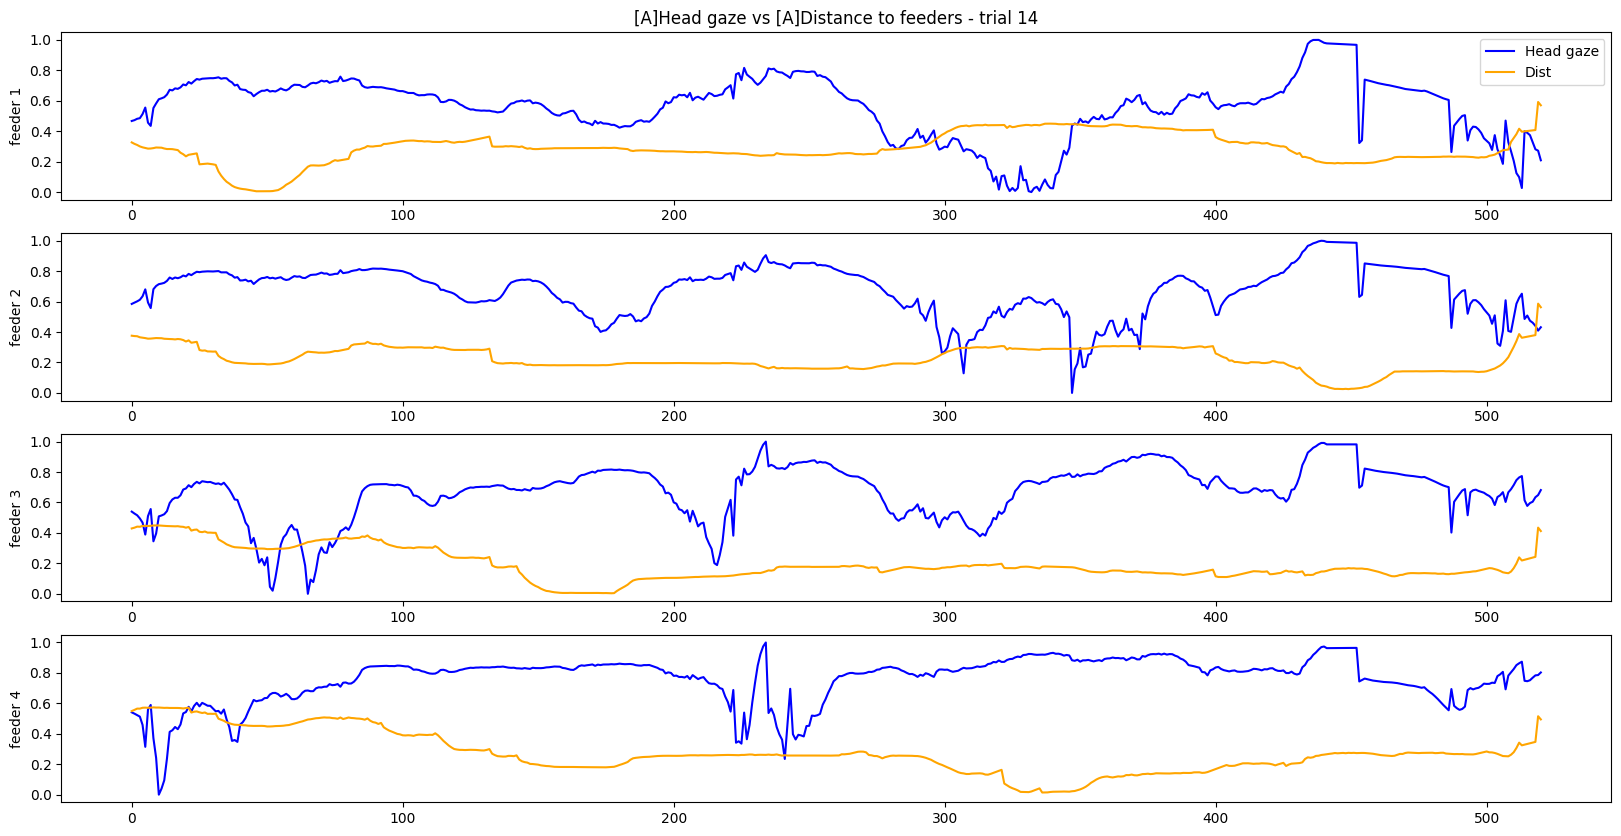

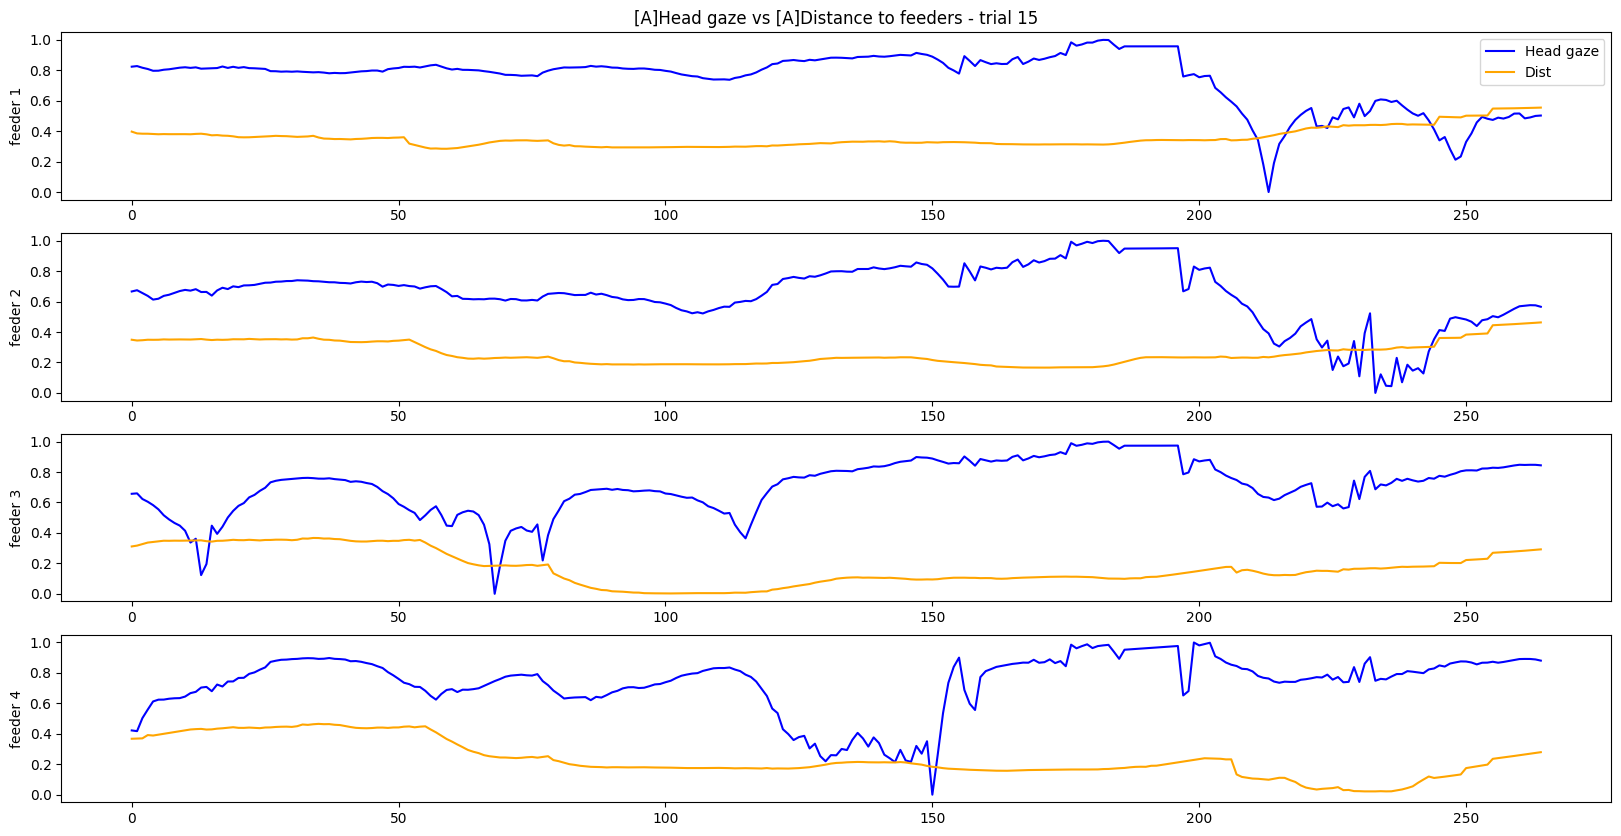

In [474]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']

for j in np.arange(2, 16):
    df_tr = df[df['trial'] == j]
    
    # Shift columns in HG by -50
    HG_shifted = df_tr[HG].shift(-70)
    
    # Drop NaNs after shifting
    df_tr_shifted = df_tr.copy()
    df_tr_shifted[HG] = HG_shifted
    df_tr_shifted = df_tr_shifted.dropna()  # Drop rows with NaN values

    # Convert to NumPy arrays
    HG_np = df_tr_shifted[HG].to_numpy()
    HG_np_scaled = np.array([min_max_scaling(HG_np[:, k]) for k in range(HG_np.shape[1])]).T
    Dist_np = df_tr_shifted[Dist].to_numpy()

    fig, axs = plt.subplots(4, 1, figsize=(20, 10), linewidth=0.01)  
    for i in np.arange(4):
        ax = axs[i]
        ax.plot(HG_np_scaled[:, i], label='Head gaze', linewidth=1.5, color='blue')  # True values in blue
        ax.plot(Dist_np[:, i], label='Dist', linewidth=1.5, color='orange')  # Predicted values in orange
        ax.set_ylabel(f'feeder {i+1}')

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'[A]Head gaze vs [A]Distance to feeders - trial {j}')
            ax.legend()
        
    plt.savefig(f'HGvsDist_trial_{j}.png')
    plt.show()


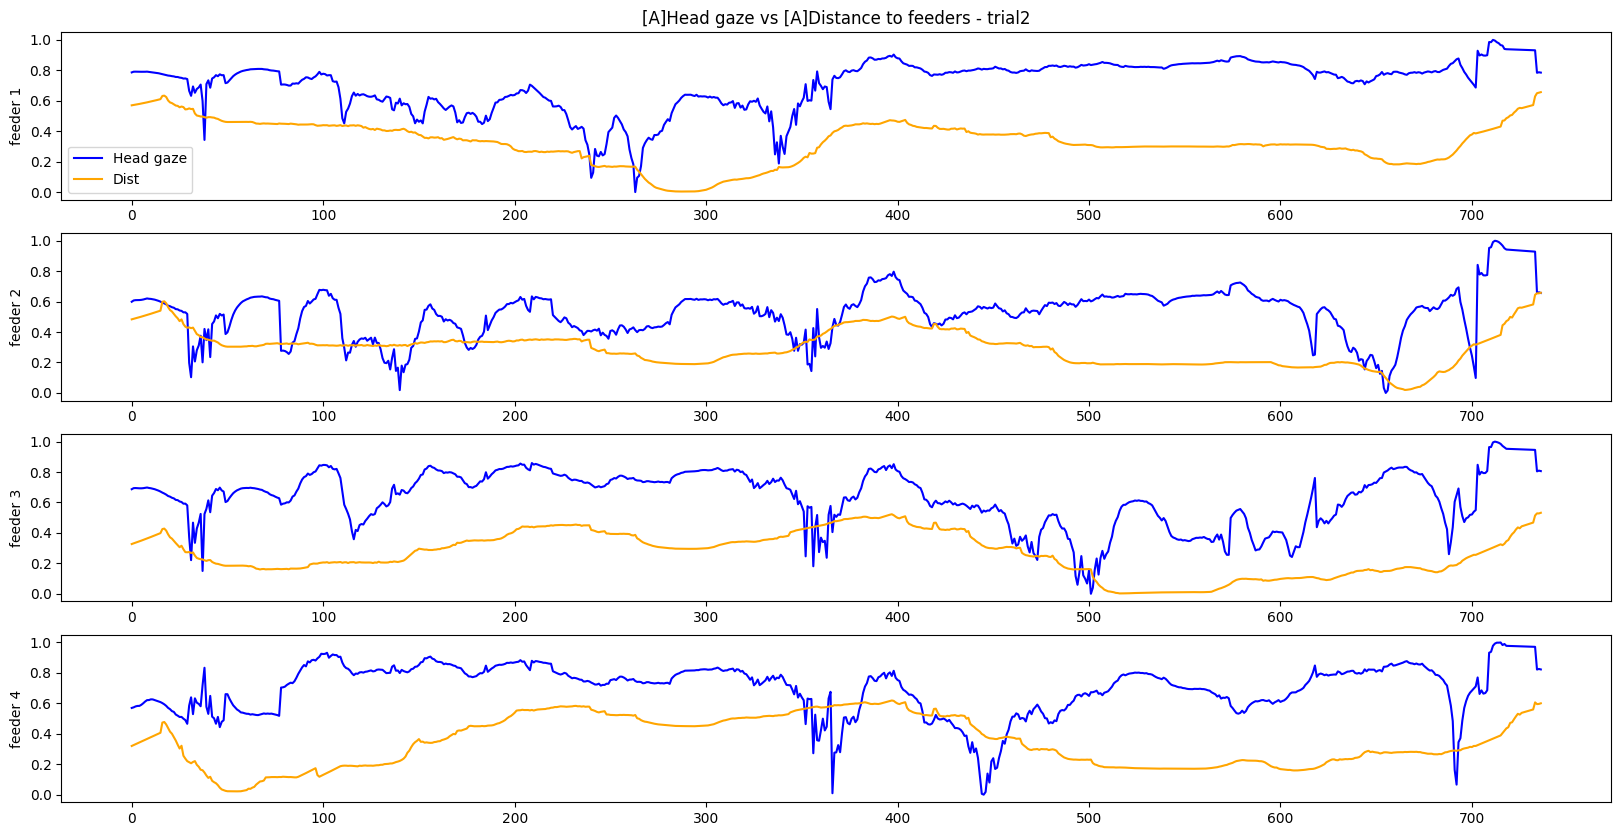

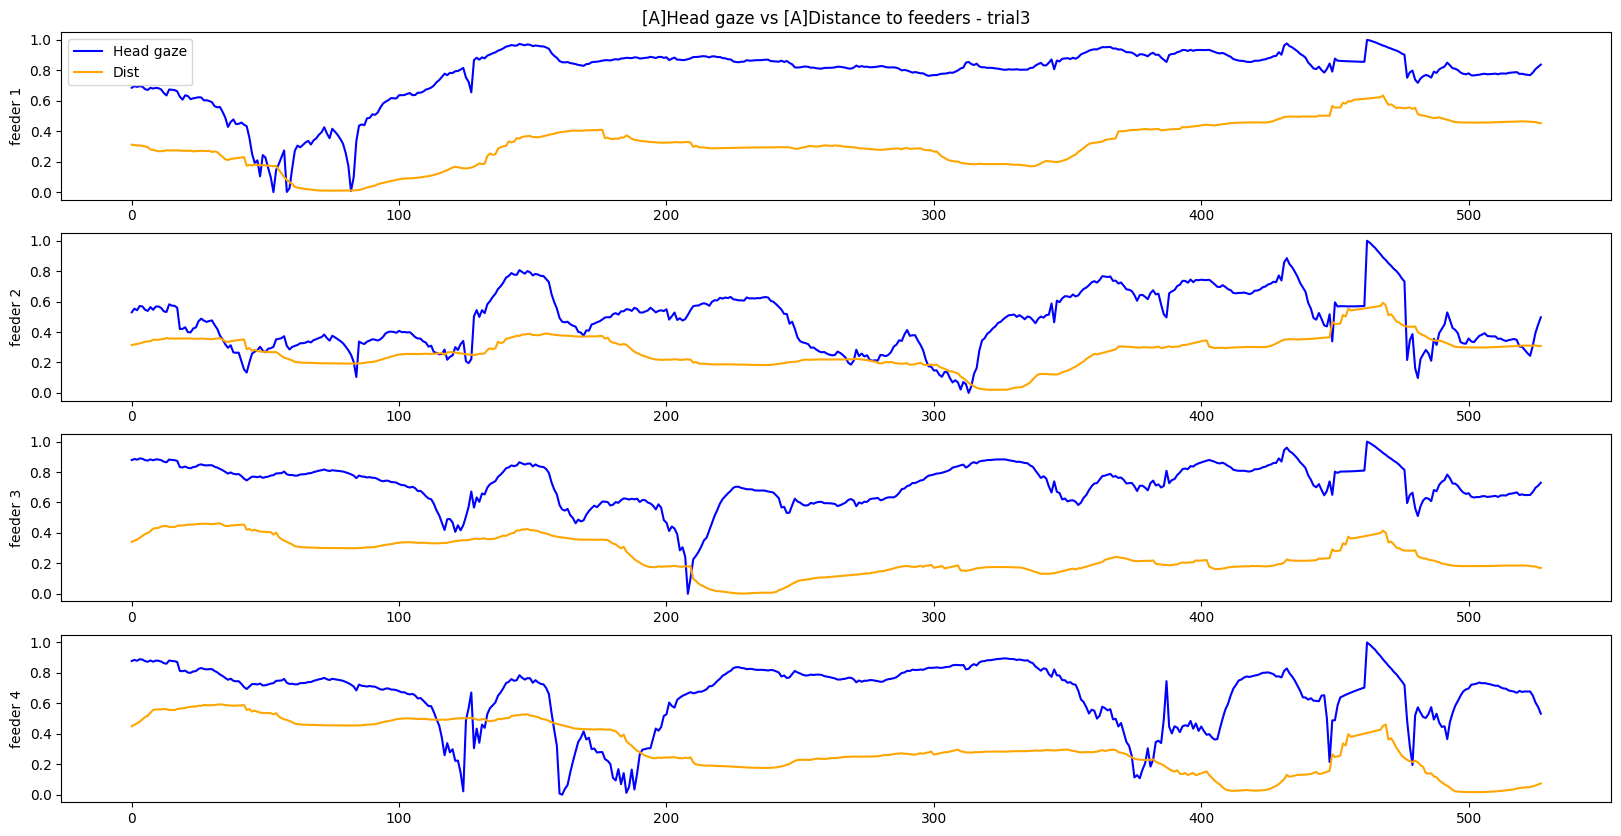

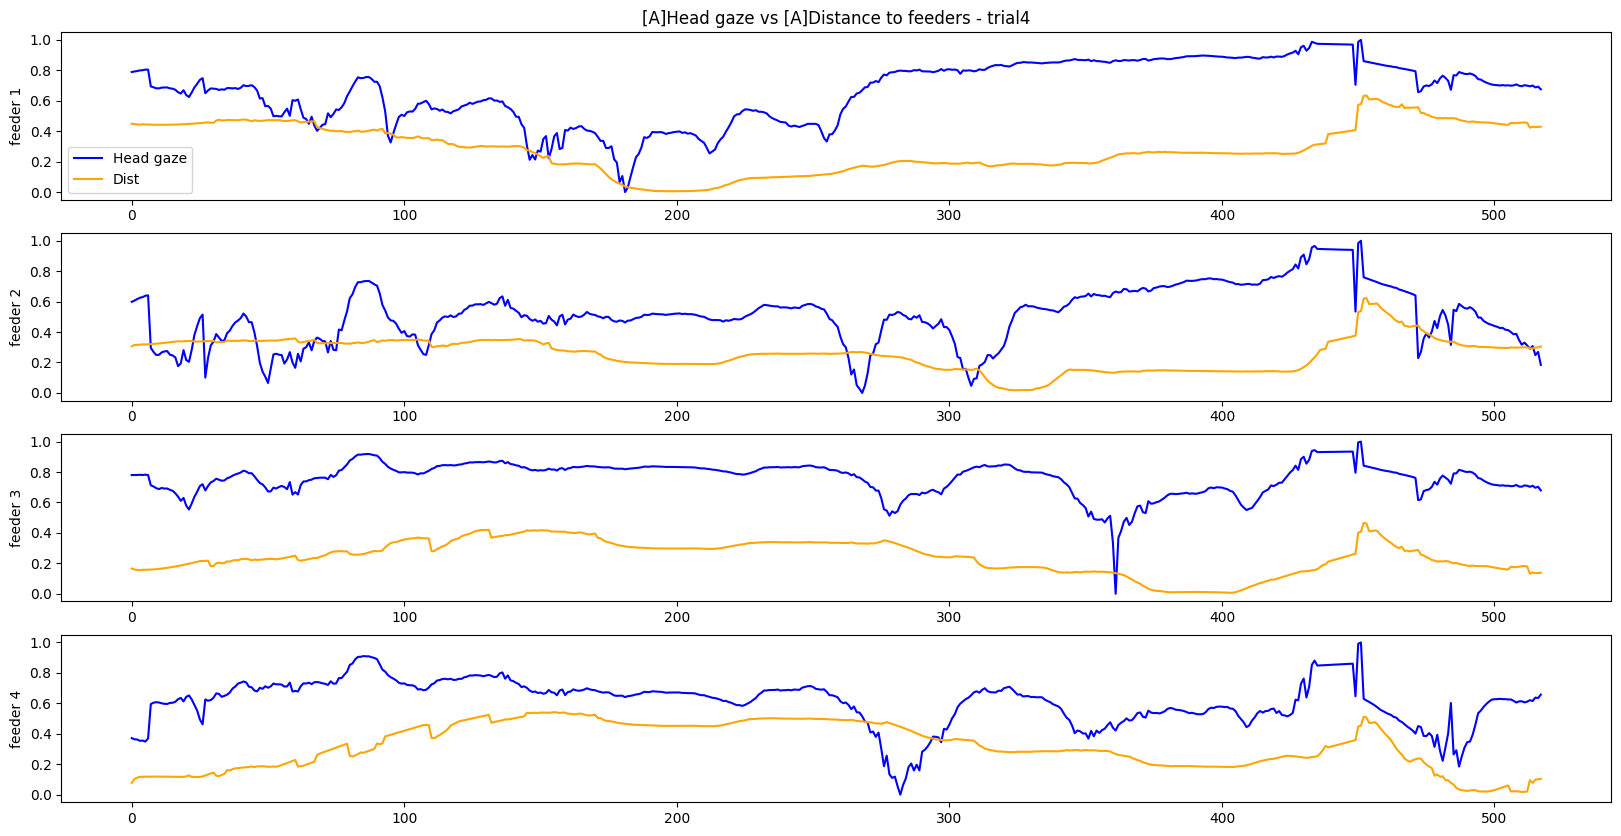

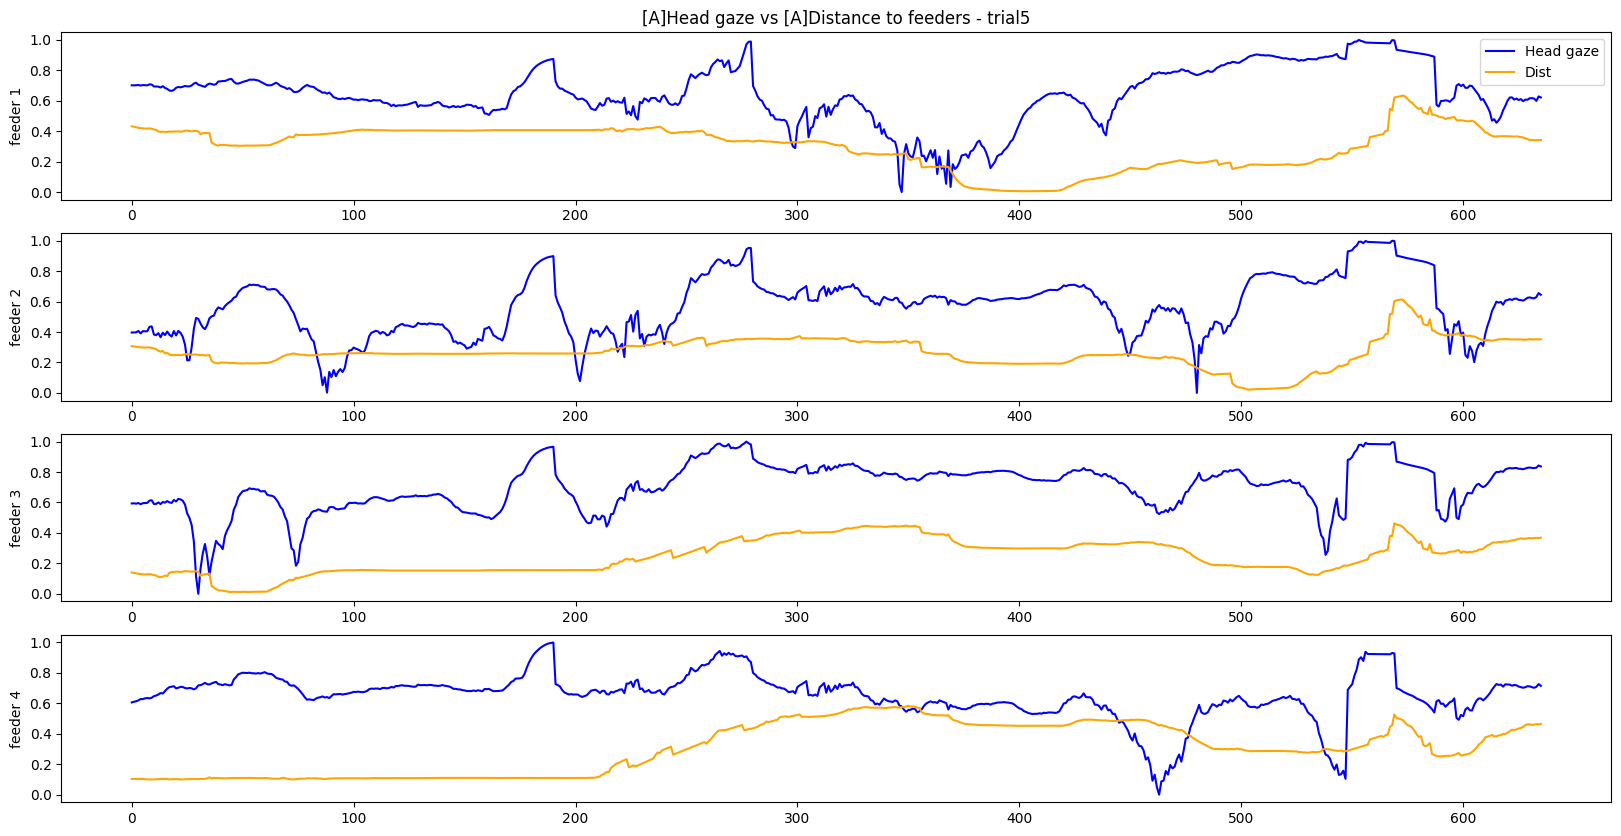

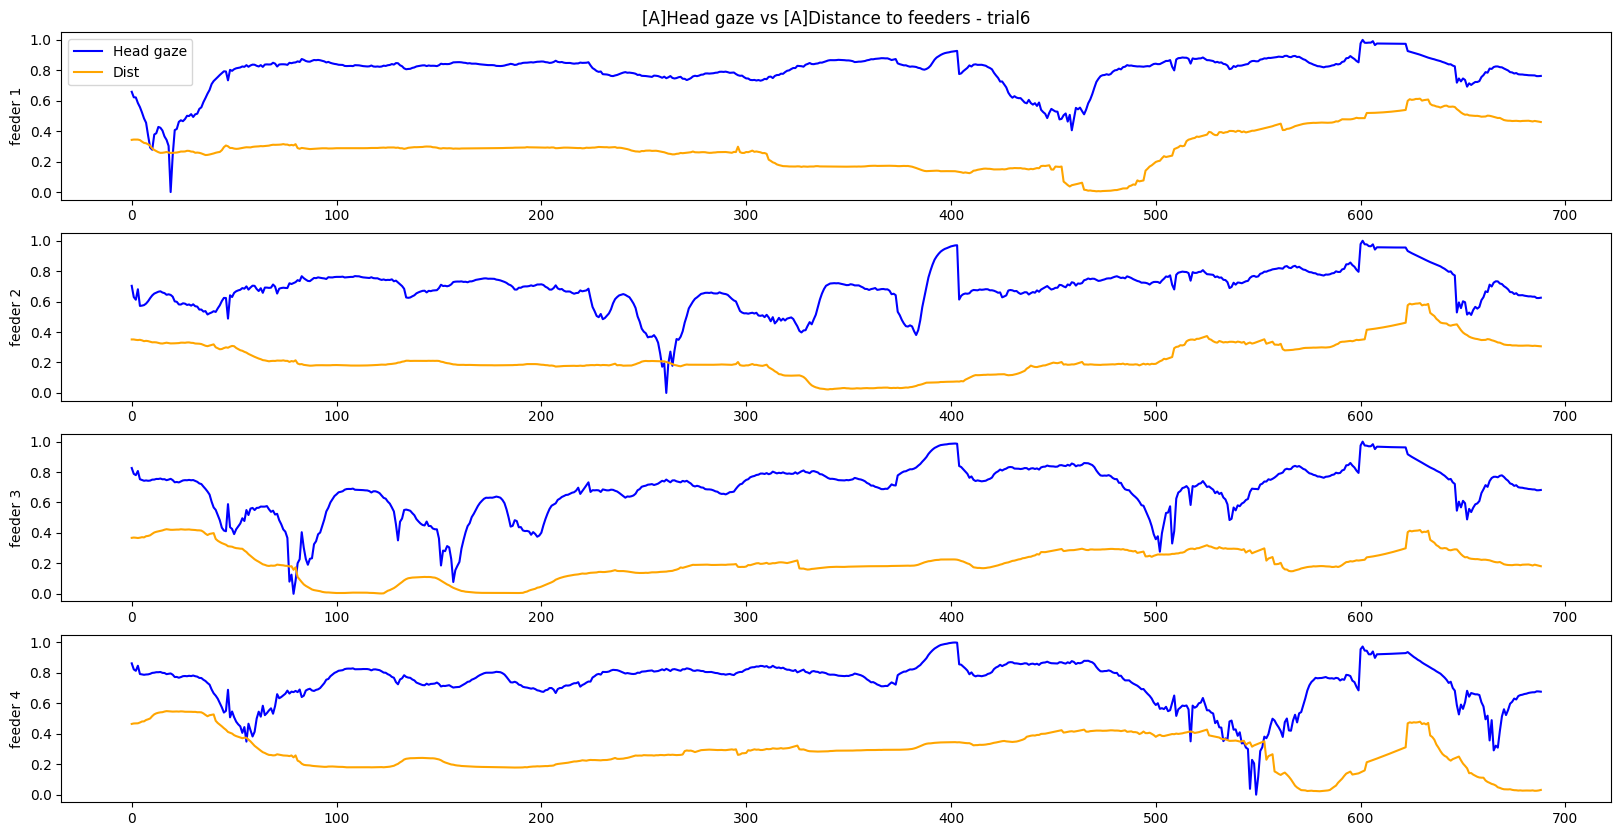

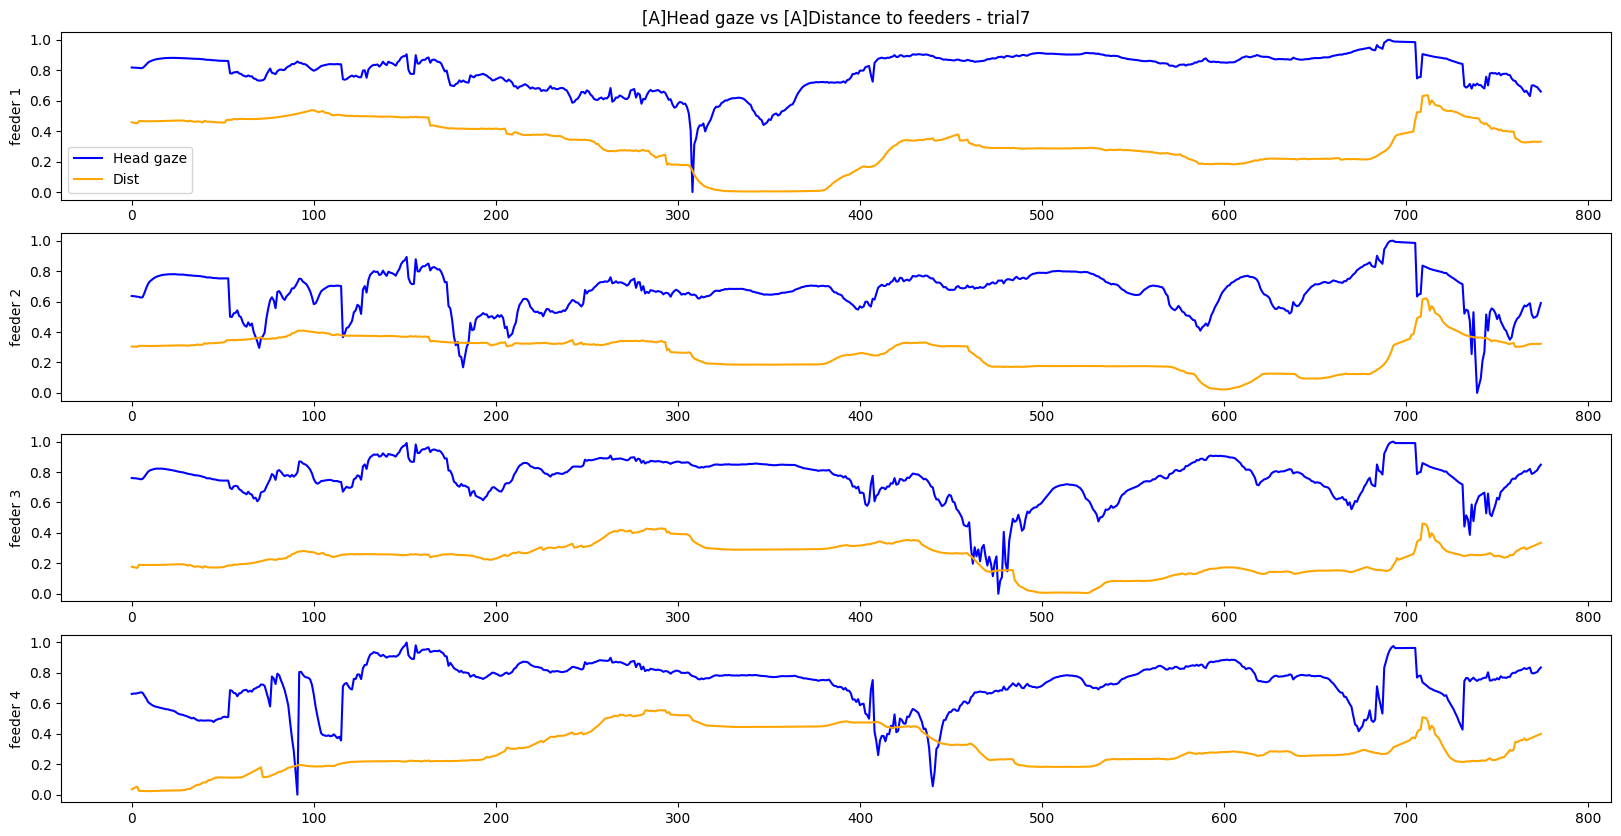

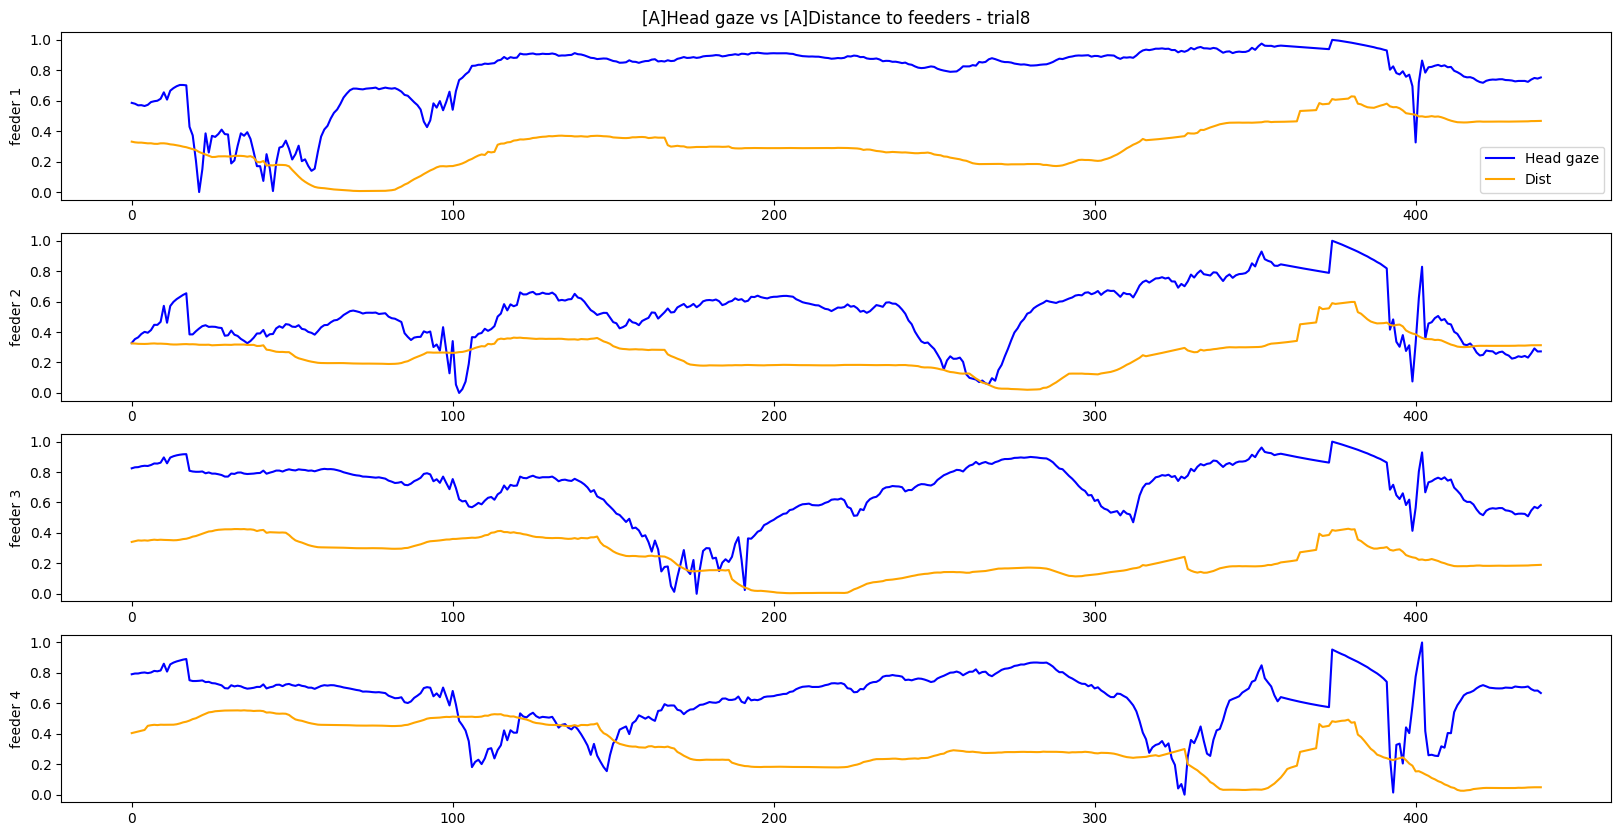

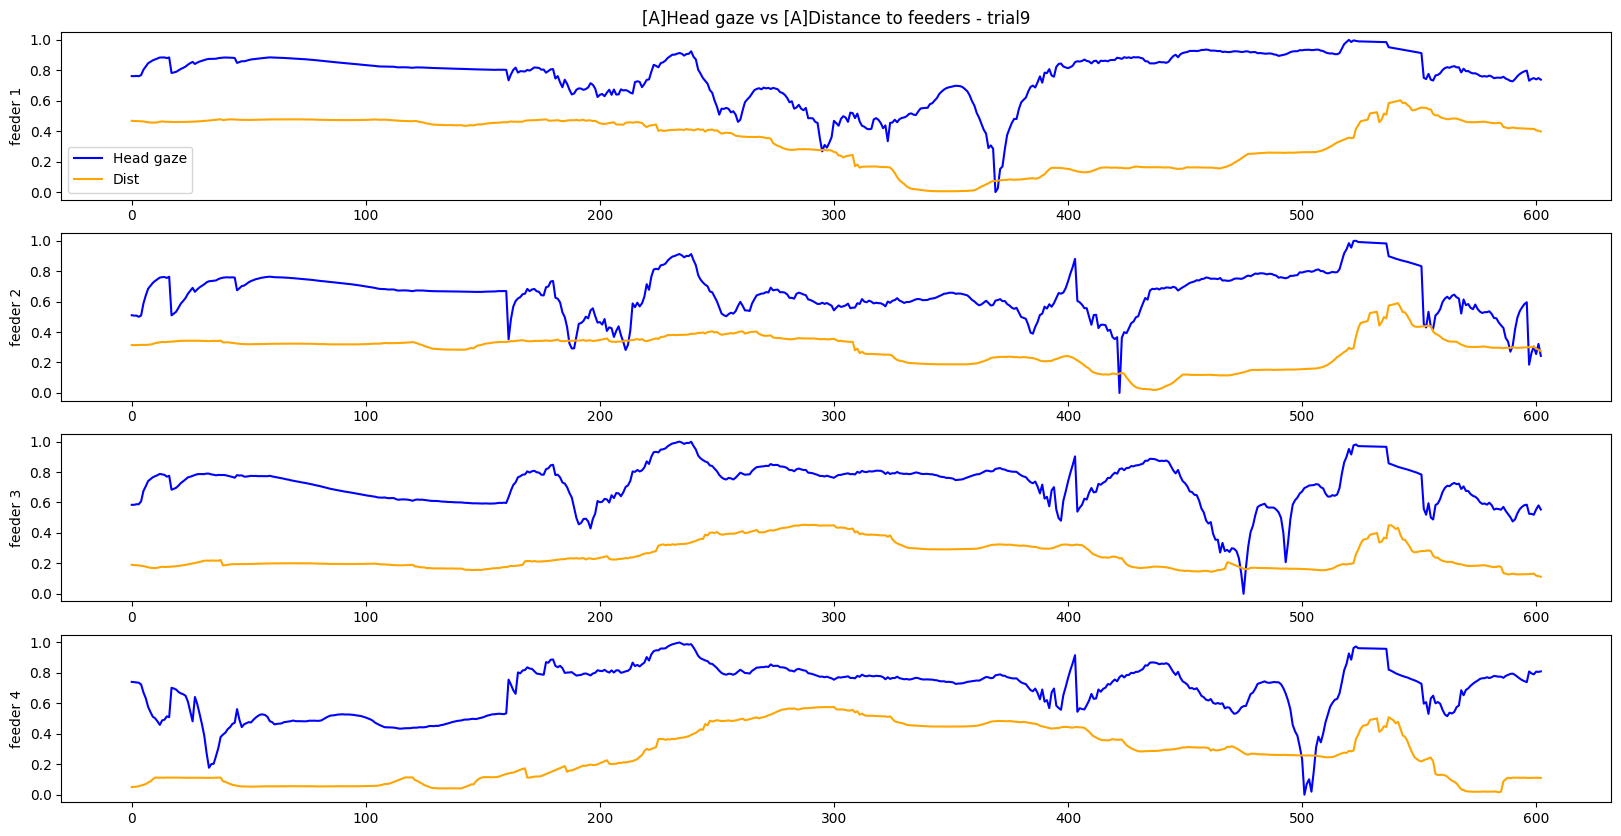

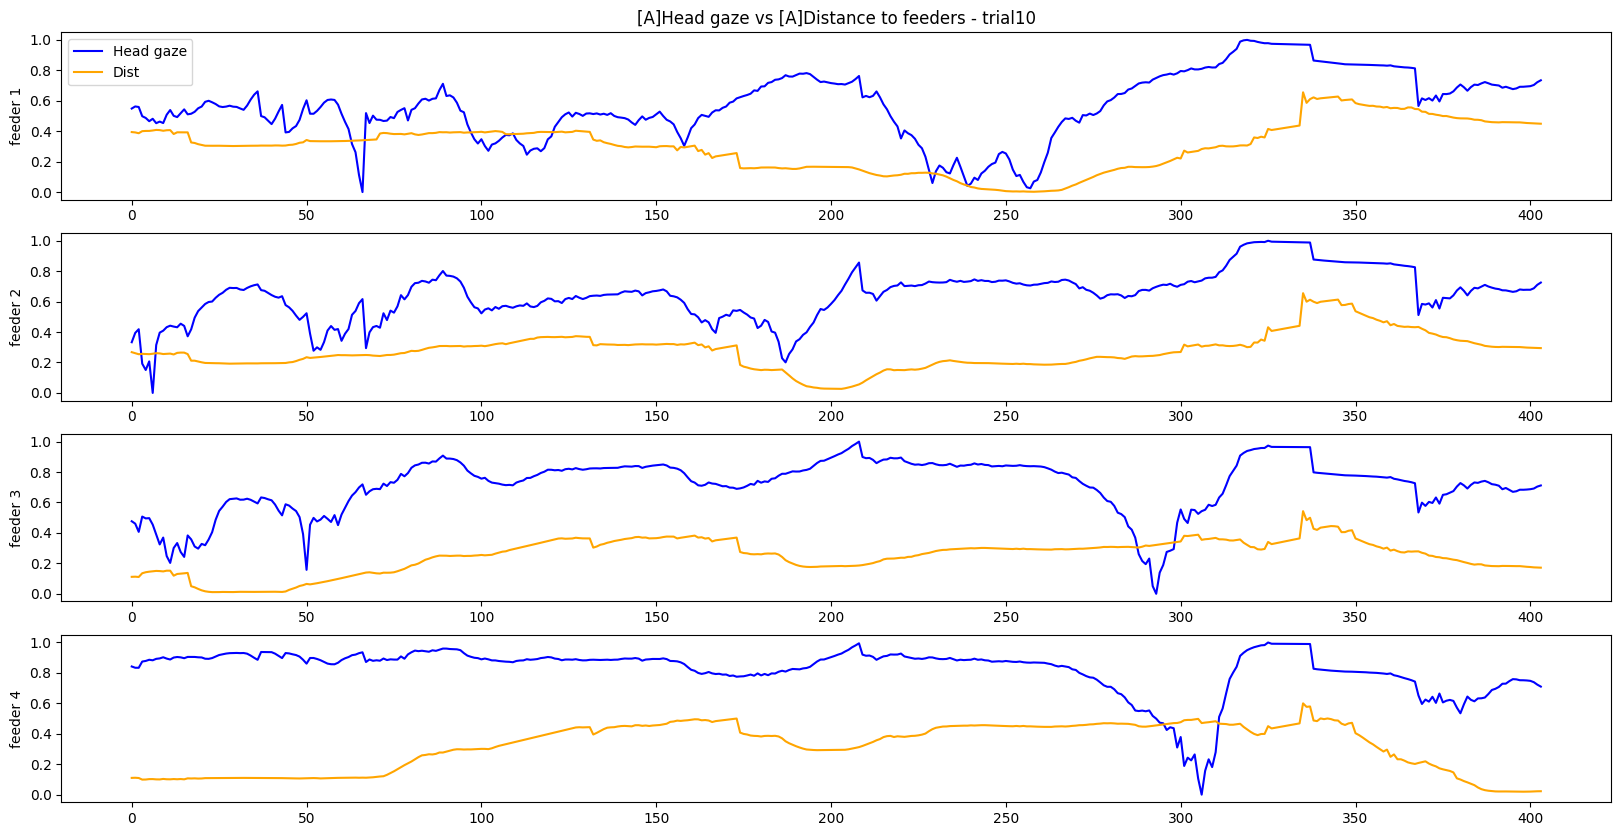

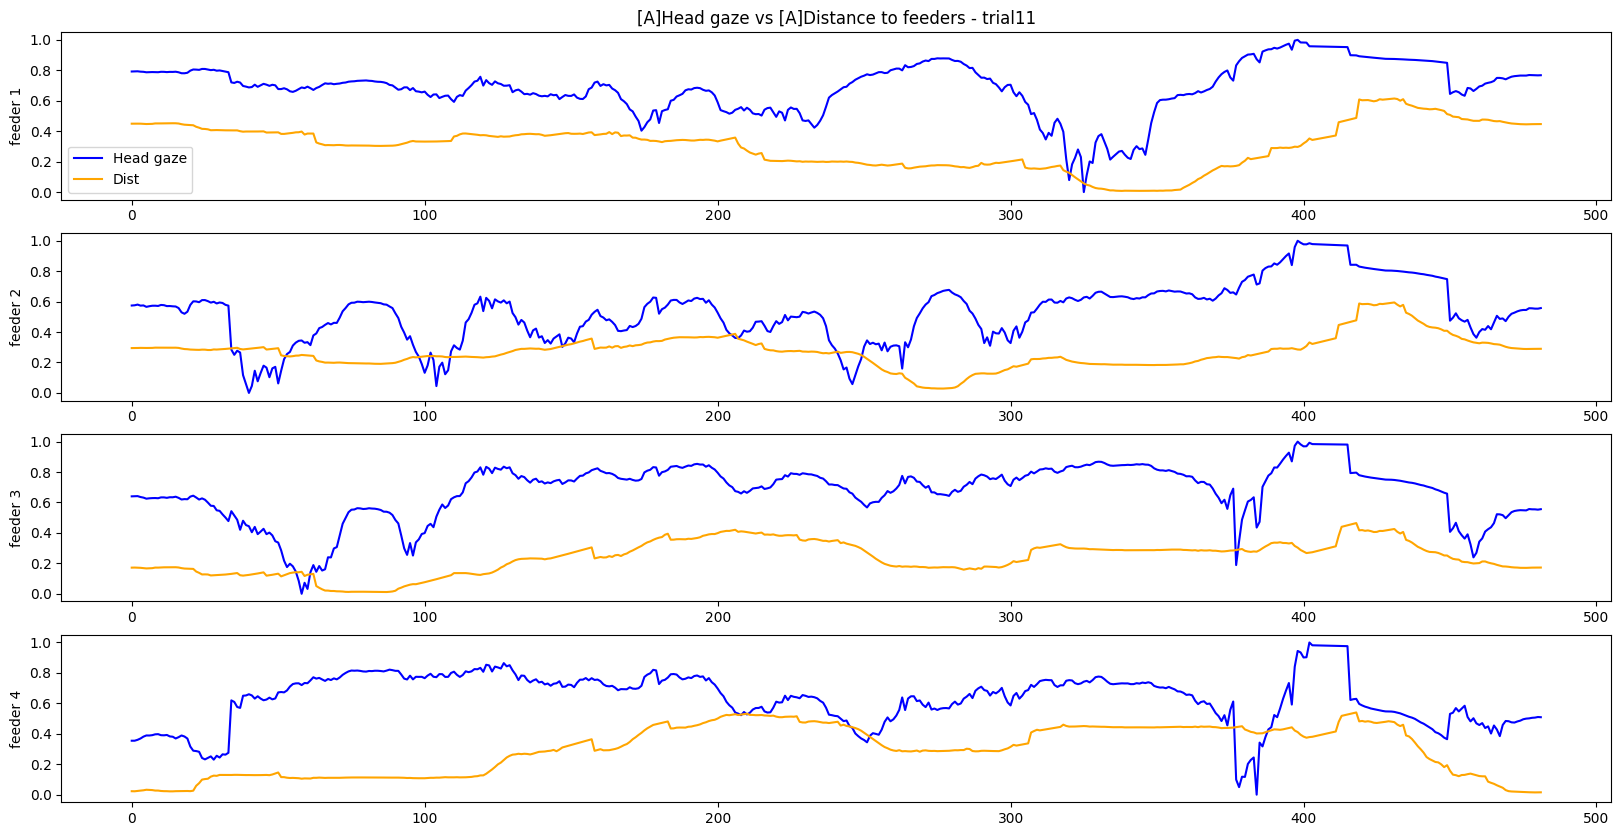

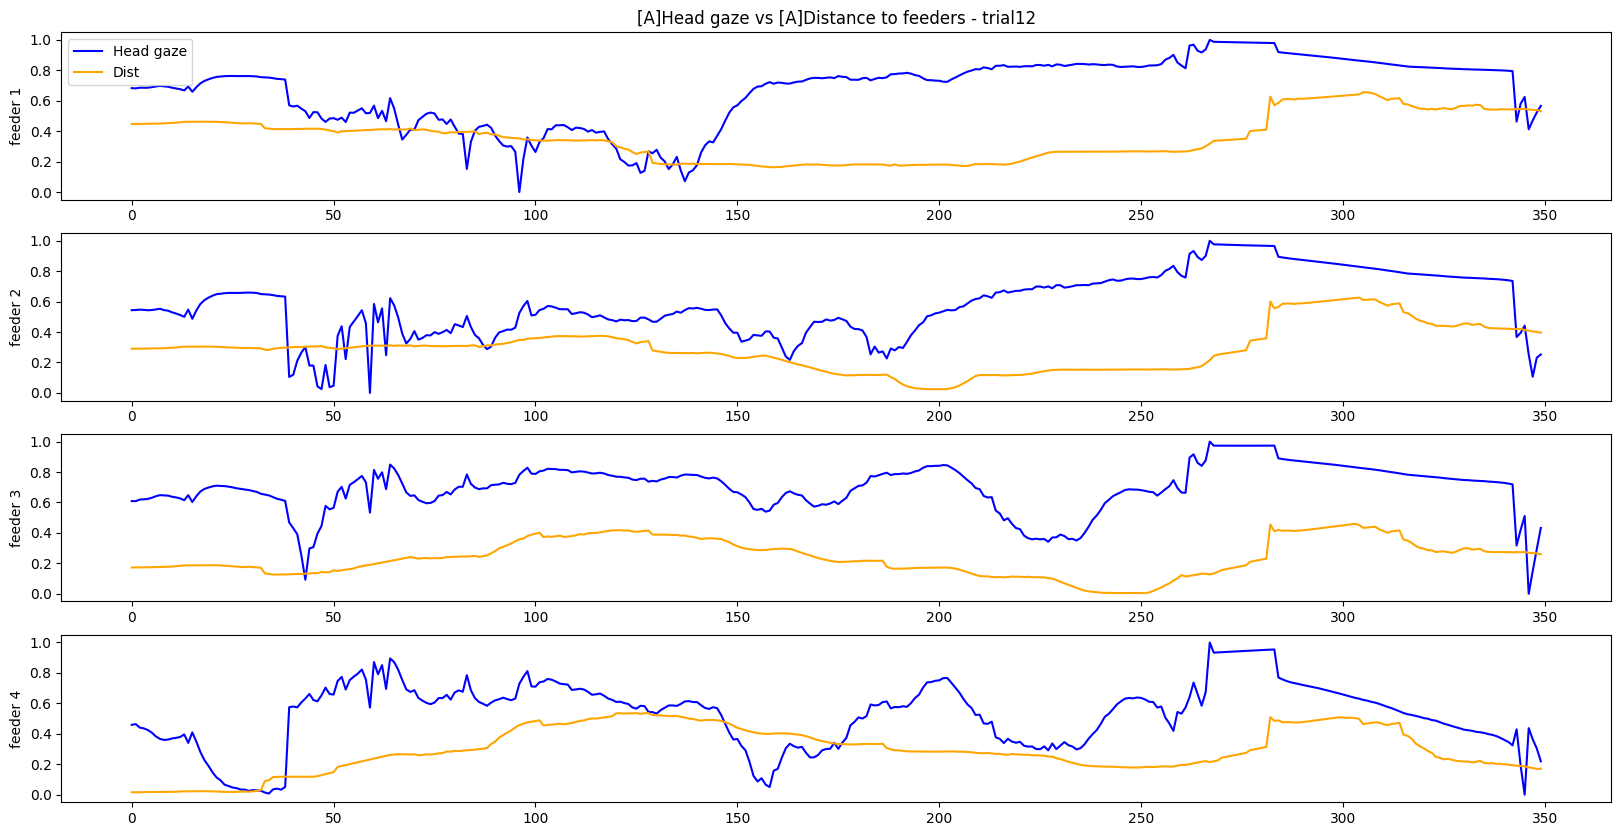

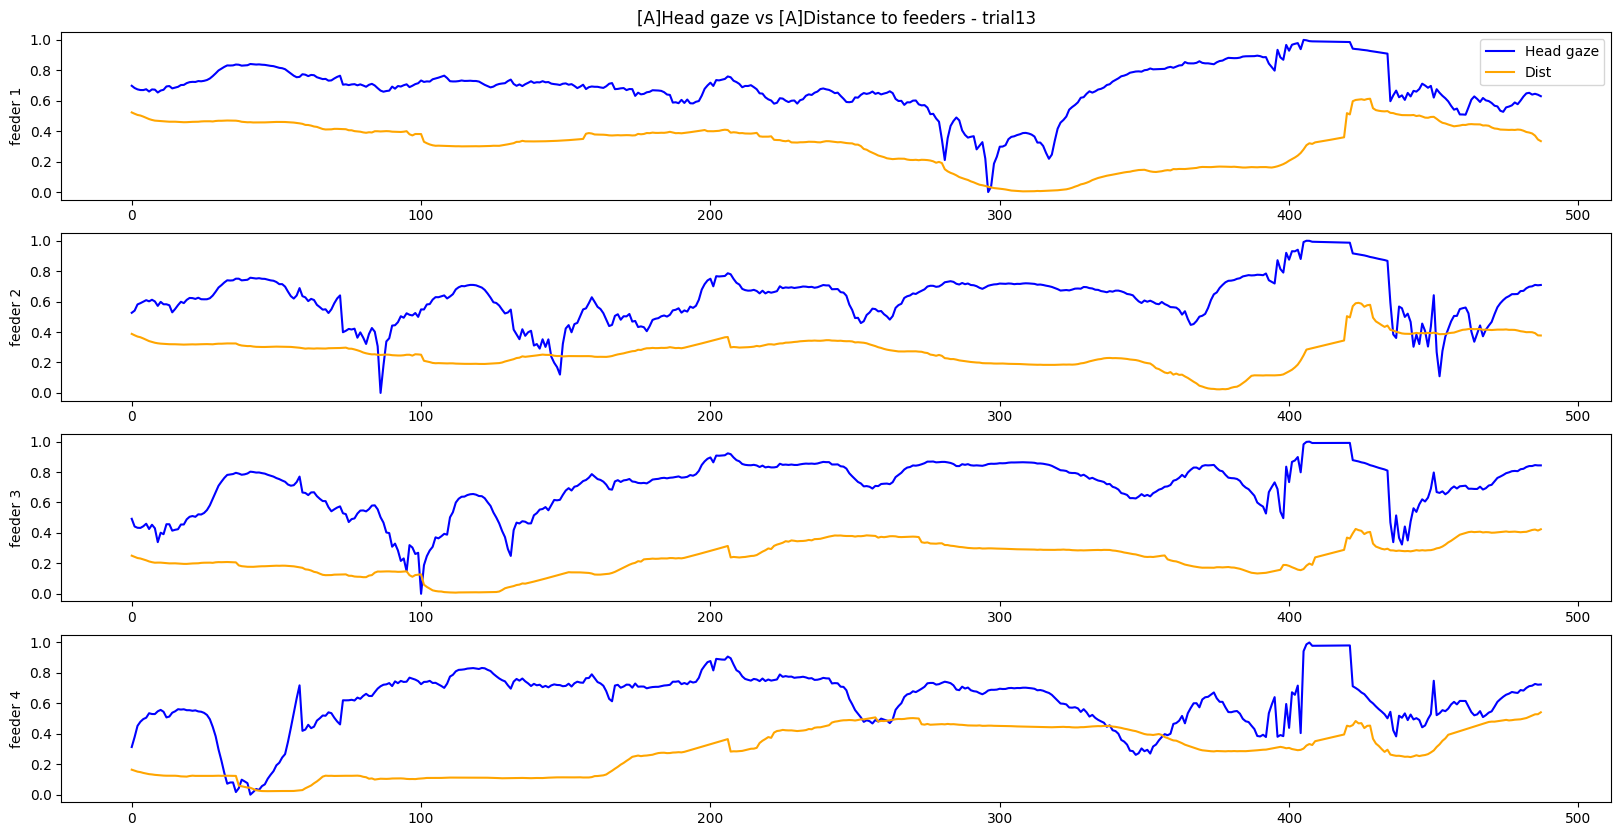

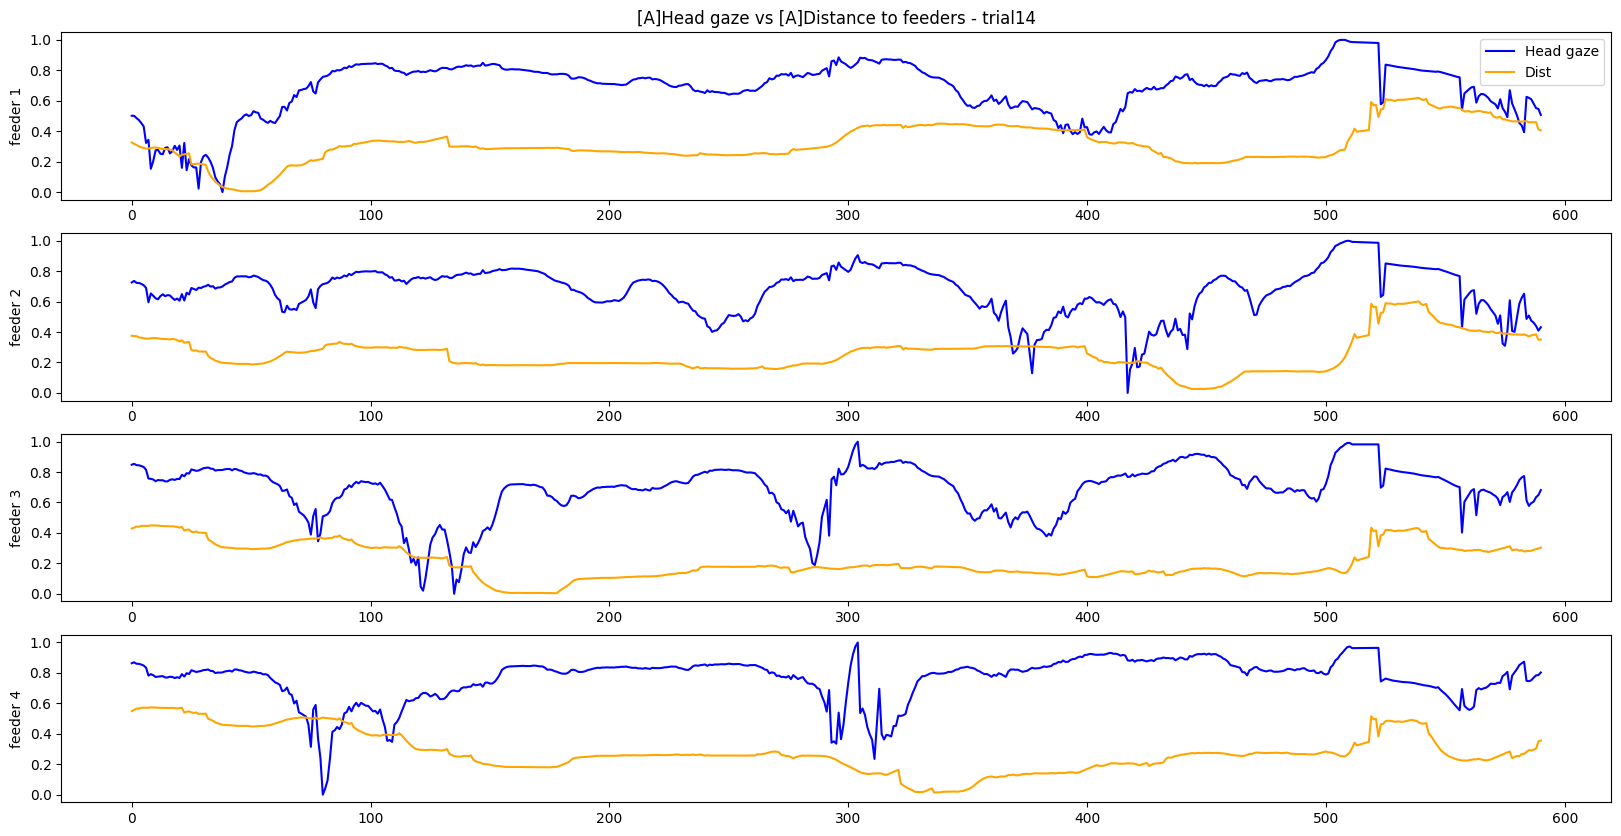

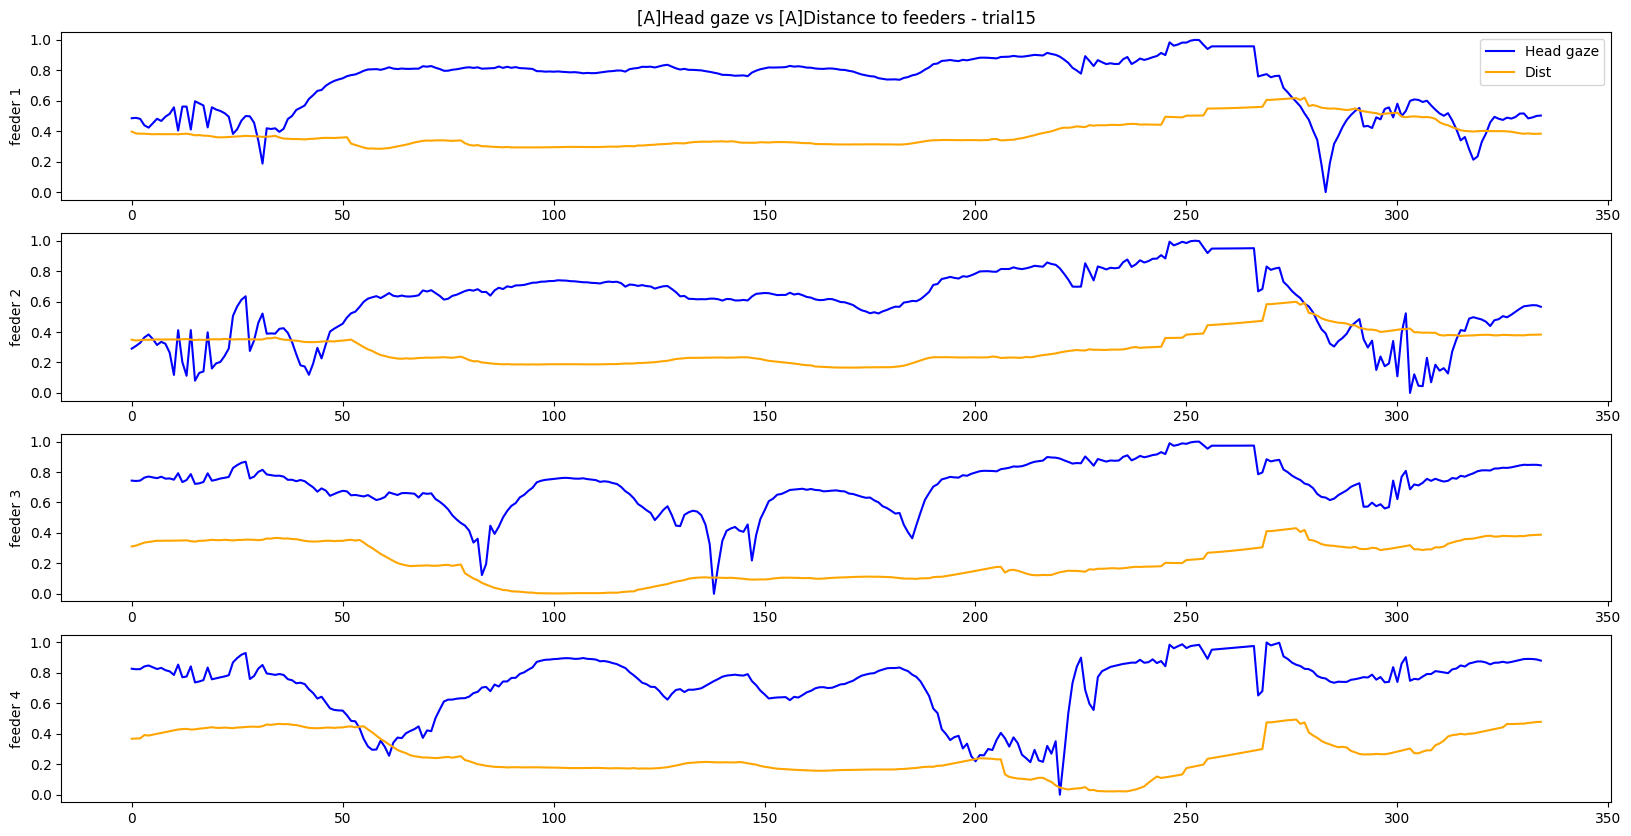

In [462]:
HG = ['aAngHGFeed1','aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4']
Dist = ['aDistReach_1','aDistReach_2', 'aDistReach_3', 'aDistReach_4']

for j in np.arange(2,16):
    df_tr = df[df['trial']==j]
    HG_np = df_tr[HG].to_numpy()
    HG_np_scaled = np.array([min_max_scaling(HG_np[:, k]) for k in range(HG_np.shape[1])]).T
    Dist_np = df_tr[Dist].to_numpy()


    fig, axs = plt.subplots(4, 1, figsize=(20,10), linewidth=0.01)  
    for i in np.arange(4):
        ax = axs[i]
        ax.plot(HG_np_scaled[:, i], label='Head gaze', linewidth=1.5, color='blue')  # True values in blue
        ax.plot(Dist_np[:, i], label='Dist', linewidth=1.5, color='orange')  # Predicted values in orange
        ax.set_ylabel(f'feeder {i+1}')

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'[A]Head gaze vs [A]Distance to feeders - trial{j}')
            ax.legend()
        
        #ax.set_xlabel('Time Step',labelpad=0.5)
    plt.savefig(f'HGvsDist_trial_{j}.png')
    plt.show()


In [387]:
encoder = ExperimentEncoder(input_size,hidden_size)
decoder_lin = NonlinearDecoder(hidden_size, output_size)
decoder_gru = GRUDecoder(hidden_size,output_size)
model = CoreAndReadout(encoder, decoder_gru)

for x,y in train_dataloader:
    out_enc = encoder(x)
    out_dec = decoder_gru(out_enc)
    out_declin = decoder_lin(out_enc)
    print(type(out_dec))
    model(x)
    

<class 'list'>


In [275]:
logged = shifted_df[labels].apply(np.log)
print(logged.head())
exped = logged.apply(np.exp)
print(exped.head())
print(shifted_df[labels].head())


   aDistReach_3
0     -1.117599
1     -1.104479
2     -1.091293
3     -1.078057
4     -1.064786
   aDistReach_3
0      0.327064
1      0.331384
2      0.335782
3      0.340256
4      0.344802
   aDistReach_3
0      0.327064
1      0.331384
2      0.335782
3      0.340256
4      0.344802


In [461]:
shifted_df.columns

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4', 'aAngHGFeed1_lagged', 'aAngHGFeed2_lagged',
       'aAngHGFeed3_lagged', 'aAngHGFeed4_lagged'],
      dtype='object')

In [263]:
shifted_df.columns
cor_plot = shifted_df[['oAngHGFeed1','oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1','oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4','b_1', 'b_2', 'b_3', 'b_4']]

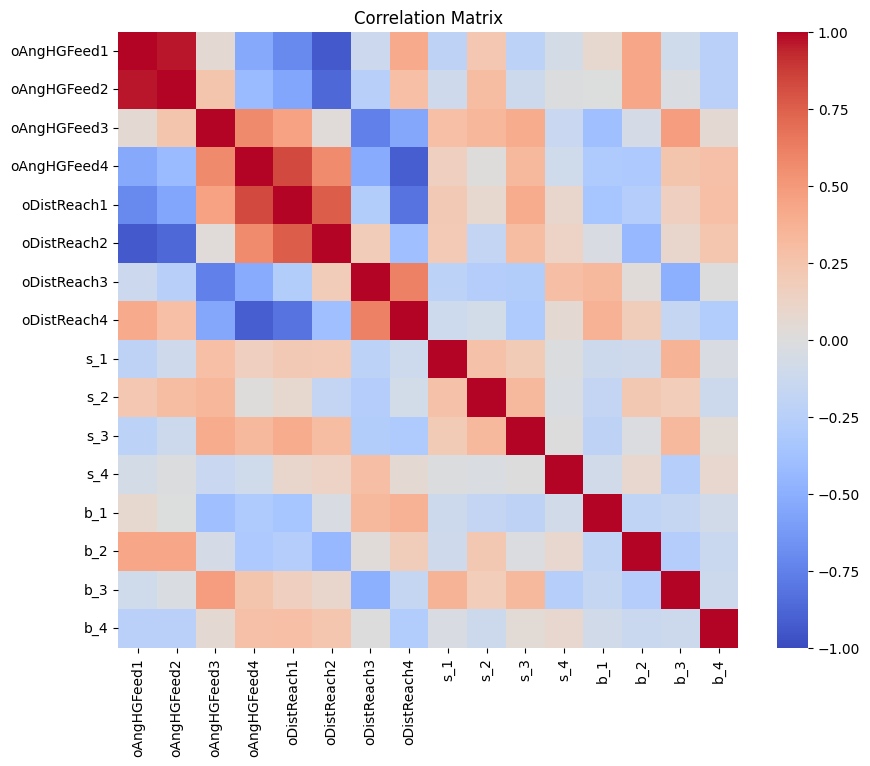

In [264]:
# Plot the heatmap of the correlation matrix
correlation_matrix = cor_plot.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [390]:
def train(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:

        optimizer.zero_grad()
        
        y_pred = model(x)
        
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), y_pred

def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())
    
    return np.mean(epoch_loss), y_pred

def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        
        val_losses.append(epoch_val_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
            
    return train_losses, val_losses, yPred_tr, yPred_val

In [180]:
encoder = ExperimentEncoder2(input_size,hidden_size)
decoder = NonlinearDecoder2(hidden_size,output_size)
model = CoreAndReadout(encoder,decoder)

for x,y in train_dataloader:
    out = encoder(x)
    print(type(y))
    out = decoder(out)
    print(type(x))
    model(x)


<class 'list'>
<class 'torch.nn.utils.rnn.PackedSequence'>


In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))  # Adjust size if necessary

# Plot both Train and Validation Loss on the same axis
ax.plot(np.log(train_losses), label='Train Loss', color='blue')
ax.plot(np.log(val_losses), label='Validation Loss', color='orange')

# Set title, labels, and legend
ax.set_title((f'Learning curve: (val trial: {set_value}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.grid()

plot_name = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}_LC.png'
lc_dir = os.path.join(save_dir, plot_name)
plt.savefig(lc_dir)
plt.show()

# Second subplot - Validation Prediction vs True Values
y_val_pred_np = yPred_val.detach().cpu().numpy().squeeze(0)
y_val_true_np = []

# Collect true values from validation dataset
for X_batch, y_batch in val_dataloader:
    y_val_true_np.append(y_batch.numpy())

# Flatten the list of arrays into a single array
y_val_true_np = np.concatenate(y_val_true_np, axis=0).squeeze(0)
plot_filename = f'm_model_{set_value}_e{n_epochs}_h{hidden_size}_b{batch_size}.png'
plot_dir = os.path.join(save_dir, plot_filename)
create_lineplots(np.exp(y_val_pred_np), np.exp(y_val_true_np), labels, trial=set_value, shift=shift, n_epochs=n_epochs, hidden_size=hidden_size, file_path=plot_dir
                    , size=(18, 5))
    

In [363]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(val trial: {trial}, lag {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()